# Making stacked histograms
- processes an `events[year][ch][sample]` object using `make_events_dict()`
- uses `plot_hists()` to make stacked histograms

In [938]:
import glob
import os
import json
import pickle
import yaml
import math

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import sys
sys.path
sys.path.append("../python/")

import utils

plt.rcParams.update({"font.size": 20})

In [939]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [940]:
# get lumi
with open("../fileset/luminosity.json") as f:
    luminosity = json.load(f)
    
luminosity

{'ele': {'Run2': 137640.0,
  '2016APV': 19492.72,
  '2016': 16809.96,
  '2017': 41476.02,
  '2018': 59816.23},
 'mu': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'lep': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96}}

In [746]:
def get_lumi(years, channels):
    lum_ = 0
    for year in years:
        lum = 0
        for ch in channels:
            lum += luminosity[ch][year] / 1000.0

        lum_ += lum / len(channels)    
    return lum_

In [882]:
def rename_column(ev_dict, old_name, new_name):
    for year in ev_dict:
        for ch in ev_dict[year]:
            for sample in ev_dict[year][ch]:
                df = ev_dict[year][ch][sample]
                df[new_name] = df[old_name]
                
                # drop old column
                df = df[df.columns.drop(list(df.filter(regex=old_name)))]

# tagger_old = "fj_ParT_score_finetuned_v2_1-12"
# tagger_new = "fj_ParT_score_finetuned_v2_1_12"
# rename_column(events_dict, tagger_old, tagger_new)                

In [931]:
 # define your regions here
presel = {
        "mu": {
            "lep_fj_dr003": "( ( lep_fj_dr>0.03) )", 
            "lep_fj_dr08": "( ( lep_fj_dr<0.8) )",   
            "fj_pt250": "( ( fj_pt>250) )",   
            "dphi<1.57": "(abs_met_fj_dphi<1.57)",
            "tagger>0.5": "fj_ParT_score_finetuned>0.5",
            "MET>20": "met_pt>20",
        },
        "ele": {
            "lep_fj_dr003": "( ( lep_fj_dr>0.03) )", 
            "lep_fj_dr08": "( ( lep_fj_dr<0.8) )",   
            "fj_pt250": "( ( fj_pt>250) )", 
            "dphi<1.57": "(abs_met_fj_dphi<1.57)",
            "tagger>0.5": "fj_ParT_score_finetuned>0.5",  
            "MET>20": "met_pt>20",
        },
}

from make_stacked_hists import make_events_dict
channels = ["ele", "mu"]
# channels = ["ele"]
samples = [
    "EWKvjets",    
    "ggF", 
    "VH",
    "VBF",
    "ttH",
    "QCD",
    "DYJets",
    "WJetsLNu",
    "WZQQ",
    "TTbar",
    "SingleTop",
    "Diboson",
    "Data",
]

years = ["2017", "2016", "2016APV", "2018"]
# years = ["2018"]

In [932]:
events_dict = {}

In [933]:
samples_dir = {
    "2016":    "../eos/Feb9_2016",
    "2016APV": "../eos/Feb9_2016APV",
    "2017":    "../eos/Feb9_2017",
    "2018":    "../eos/Feb9_2018",    
}
events_dict["wjetsHT"] = {}
for year in years:
    
    out = make_events_dict([year], channels, samples_dir[year], samples, presel, region="signal_region", keep_weights=True)
    events_dict["wjetsHT"] = {**events_dict["wjetsHT"], **out}

INFO:root:Finding VBFHToWWToAny_M-125_TuneCP5_withDipoleRecoil samples and should combine them under VBF
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1663 events
INFO:root:Applying lep_fj_dr08 selection on 1663 events
INFO:root:Applying lep_fj_dr08 selection on 1663 events


In [934]:
# rename_column(events_dict["new_correctionsHPO"],"fj_ParT_score_finetuned", "ParT-Finetuned (trained on H vs [W, Top, QCD])")
# rename_column(events_dict["new_correctionsHPO"],"fj_ParT_score_finetuned_v31_1", "ParT-Finetuned (trained on H vs [W])")
# rename_column(events_dict["new_correctionsHPO"],"fj_ParT_score_finetuned_v32_1", "ParT-Finetuned (trained on H vs [Top])")
# rename_column(events_dict["new_correctionsHPO"],"fj_ParT_score_finetuned_v33_1", "ParT-Finetuned (trained on H vs [QCD])")
# rename_column(events_dict["new_correctionsHPO"],"fj_ParT_score_finetuned_v34_1", "ParT-Finetuned (trained on H vs [Top, W])")

# rename_column(events_dict["new_correctionsHPO"],"fj_ParT_score", "ParT")

In [943]:
tagger_cuts = np.linspace(0.9, 0.99, 30)
# tagger_cuts = np.linspace(0.9, 0.975, 20)

mass_window = [100, 150]

years = ["2017", "2018", "2016", "2016APV"]
# years = ["2018"]
channels = ["ele", "mu"]
# channels = ["mu"]

s_over_b = {}

taggers = [
    "fj_ParT_score",
    "fj_ParT_score_finetuned",
    "fj_ParT_score_finetuned_v35_1",
    "fj_ParT_score_finetuned_v35_2",
    "fj_ParT_score_finetuned_v35_3",
    "fj_ParT_score_finetuned_v35_4",
    "fj_ParT_score_finetuned_v35_5",   
]

ev = events_dict["wjetsHT"]

for tagger in taggers:
        
    print("TAGGER:", tagger)
    s_over_b[tagger] = []

    for tagger_cut in tagger_cuts:
        print("tagger cut", tagger_cut)
        s, b = 0, 0
        for year in years:
            for ch in channels:
                for sample in ev[year][ch]:
                    if sample =="Data":
                        continue
                    
                    df = ev[year][ch][sample]   # doesnt include low pt bin

                    if "PKU definition" in tagger:
                        df = df[df["fj_ParT_score_finetuned"]>tagger_cut]
                    else:
                        df = df[df[tagger]>tagger_cut]

                    # add mass window        
                    df = df[(df["rec_higgs_m"]>=mass_window[0]) & (df["rec_higgs_m"]<=mass_window[1])]
                    df = df[(df["n_bjets_T"]==0)]
                    
#                     if "MET>" in tagger:
#                         metcut = int(tagger[-6:-4])
#                         df = df[df["met_pt"]>metcut]
                        
#                     if "eta" in tagger:
#                         etacut = np.absolute(df["lep_eta"]) < 1.5
#                         df = df[etacut]                        
                        
                    if sample == "QCD":
                        threshold = 30
                        den += len(df['event_weight'])
                        num += sum(df["event_weight"]>threshold)

                        df = df[df["event_weight"] < threshold]

                    ##############################    
                    if sample in utils.signals:
                        s += df["event_weight"].sum()
                    else:
                        b += df["event_weight"].sum()
        if b <= 0:
            b = 1
            
        if s/math.sqrt(b)>3:
            s_over_b[tagger].append(0)
        else:
            s_over_b[tagger].append(s/math.sqrt(b))

TAGGER: fj_ParT_score
tagger cut 0.9
tagger cut 0.9031034482758621
tagger cut 0.9062068965517242
tagger cut 0.9093103448275862
tagger cut 0.9124137931034483
tagger cut 0.9155172413793103
tagger cut 0.9186206896551724
tagger cut 0.9217241379310345
tagger cut 0.9248275862068965
tagger cut 0.9279310344827586
tagger cut 0.9310344827586207
tagger cut 0.9341379310344827
tagger cut 0.9372413793103448
tagger cut 0.9403448275862069
tagger cut 0.943448275862069
tagger cut 0.9465517241379311
tagger cut 0.9496551724137932
tagger cut 0.9527586206896552
tagger cut 0.9558620689655173
tagger cut 0.9589655172413794
tagger cut 0.9620689655172414
tagger cut 0.9651724137931035
tagger cut 0.9682758620689655
tagger cut 0.9713793103448276
tagger cut 0.9744827586206897
tagger cut 0.9775862068965517
tagger cut 0.9806896551724138
tagger cut 0.9837931034482759
tagger cut 0.9868965517241379
tagger cut 0.99
TAGGER: fj_ParT_score_finetuned
tagger cut 0.9
tagger cut 0.9031034482758621
tagger cut 0.9062068965517242
t

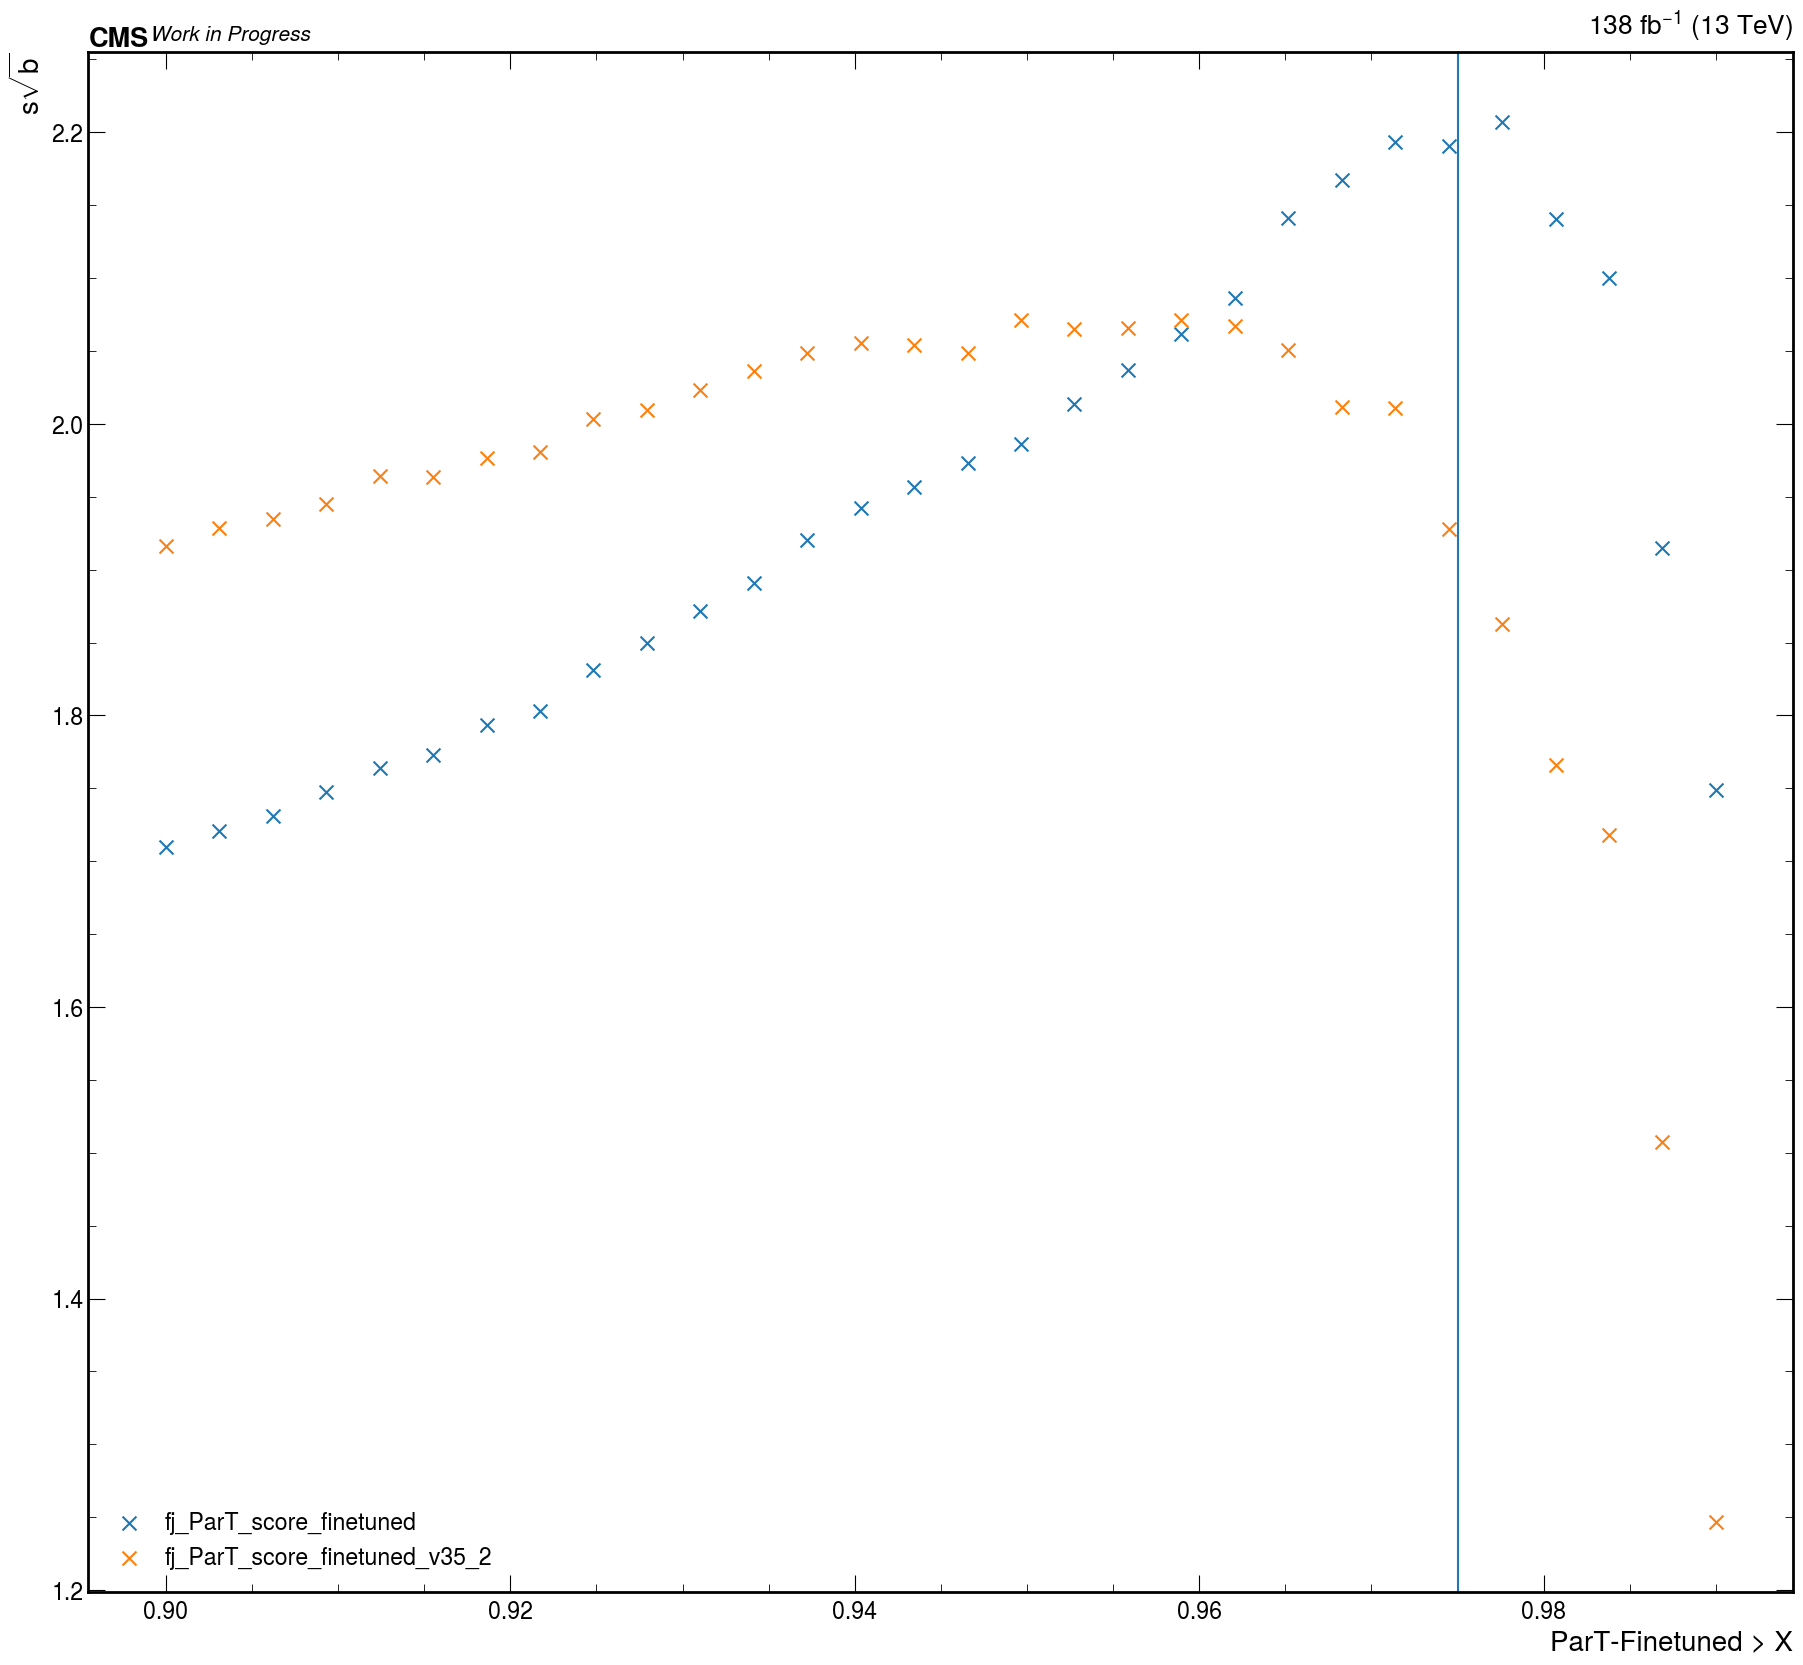

In [946]:
plt.rcParams.update({"font.size": 20})

channels = ["ele", "mu"]

fig, ax = plt.subplots(figsize=(22, 20))


taggers = [
#     "fj_ParT_score",
    "fj_ParT_score_finetuned",
#     "fj_ParT_score_finetuned_v35_1",
    "fj_ParT_score_finetuned_v35_2",
#     "fj_ParT_score_finetuned_v35_3",
#     "fj_ParT_score_finetuned_v35_4",
#     "fj_ParT_score_finetuned_v35_5",   
]

for tagger in taggers:
    lab = tagger
        
    ax.scatter(tagger_cuts, s_over_b[tagger], marker="x", s=100, label=lab)

ax.legend(loc="lower left")
ax.set_ylabel(r"$s\sqrt{b}$")
ax.set_xlabel("ParT-Finetuned > X")

ax.axvline(0.975)

# ax.set_xticks(tagger_cuts)
hep.cms.lumitext("%.0f " % get_lumi(years, channels) + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/soverb-new.pdf")

# Signal

In [663]:
tagger = "fj_ParT_score_finetuned"

presel = {    
    "Pre-selection": f"fj_pt>0",
}

channels = ["ele", "mu"]
years = ["2018", "2017", "2016", "2016APV"]

# fill histograms
var2 = "abs_met_fj_dphi"

samples = ["ggF", "VBF", "VH", "ttH"]


var1 = "rec_higgs_m"
var1 = "lep_fj_dr"
var1 = "lep_pt"
var1 = "met_pt"
var1 = "fj_genH_jet"

if var1 == "rec_higgs_m":
    h = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        hist2.axis.Variable(list(range(50, 240, 10)), name="var1", label=r"Higgs reconstructed mass [GeV]", overflow=True),
        hist2.axis.Regular(
        35, 0, 3.14, name="var2", label=r"$\left| \Delta \phi(MET, Jet) \right|$", overflow=True),
    )
elif var1 == "lep_fj_dr":
    h = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        hist2.axis.Regular(35, 0.0, 0.8, name="var1", label=r"$\Delta R(Jet, Lepton)$", overflow=True),
        hist2.axis.Regular(
        35, 0, 3.14, name="var2", label=r"$\left| \Delta \phi(MET, Jet) \right|$", overflow=True),
    ) 
elif var1 == "lep_pt":
    h = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        hist2.axis.Regular(40, 30, 450, name="var1", label=r"Lepton $p_T$ [GeV]", overflow=True),
        hist2.axis.Regular(
        35, 0, 3.14, name="var2", label=r"$\left| \Delta \phi(MET, Jet) \right|$", overflow=True),
    ) 
elif var1 == "met_pt":
    h = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        hist2.axis.Regular(40, 0, 450, name="var1", label=r"MET", overflow=True),
        hist2.axis.Regular(
        35, 0, 3.14, name="var2", label=r"$\left| \Delta \phi(MET, Jet) \right|$", overflow=True),
    ) 
elif var1 == "fj_genH_jet":
    h = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        hist2.axis.Regular(40, 0.0, 0.8, name="var1", label=r"dR(Jet, Higgs)", overflow=True),
        hist2.axis.Regular(
        35, 0, 3.14, name="var2", label=r"$\left| \Delta \phi(MET, Jet) \right|$", overflow=True),
    )     
    
ev = events_dict["new_corrections"]

region, sel = list(presel.items())[0]

for year in years:
    for ch in channels:    

        for sample in samples:
            for ismatched in [True, False]:

                df = ev[year][ch][sample]

                df = df.query(sel)    
                            
                h.fill(
                    samples=sample,
                    var1=df[var1],
                    var2=df[var2],
                    weight=df["event_weight"],
                )     

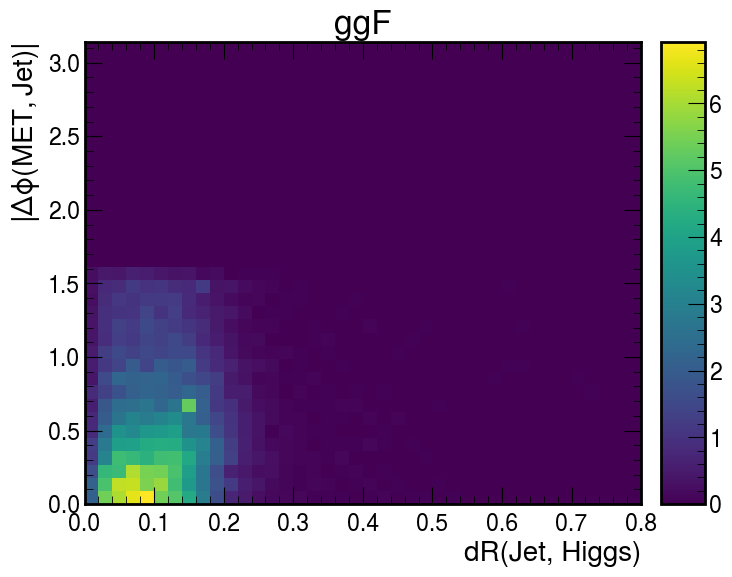

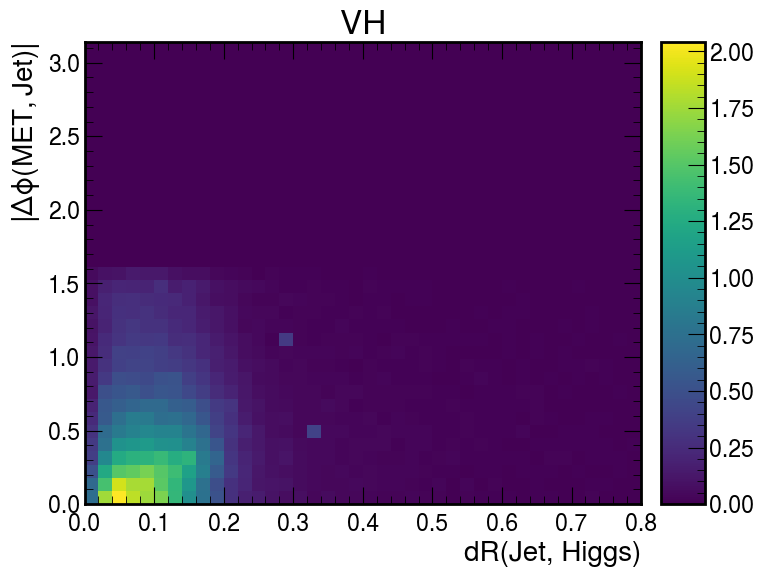

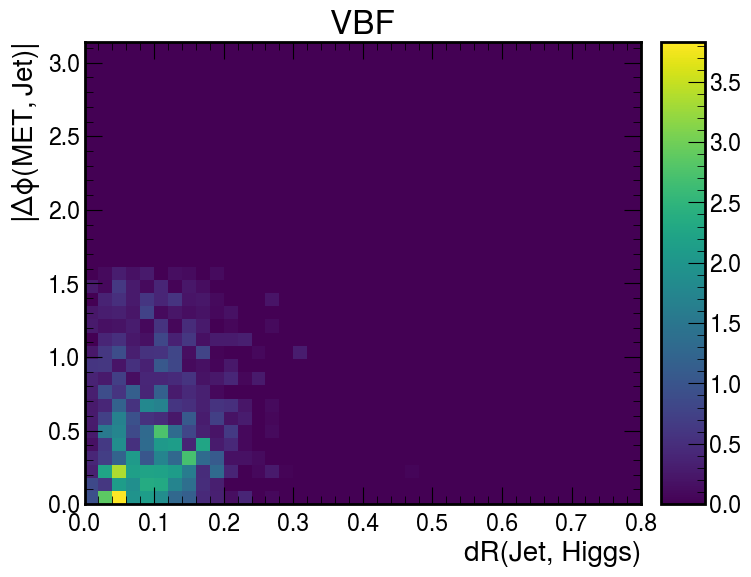

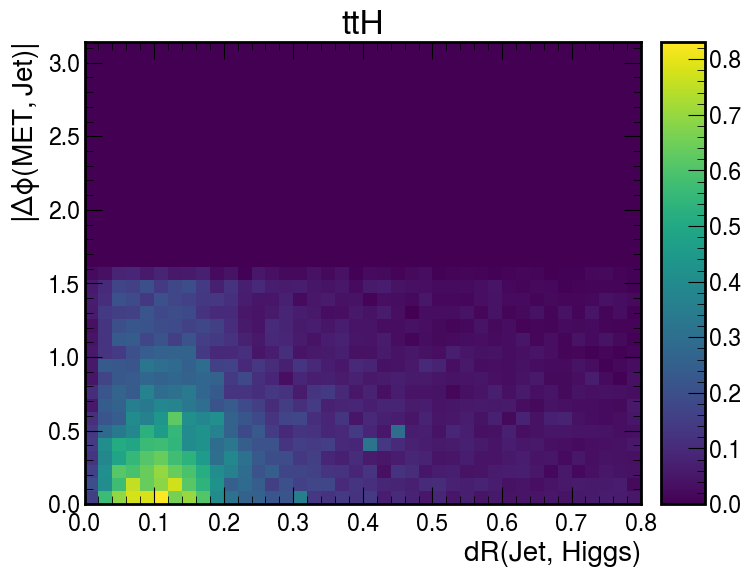

In [664]:
samples_to_plot = [
    "ggF", 
    "VH",
    "VBF",
    "ttH",
#      "QCD",
#     "DYJets",
#     "WJetsLNu",
#     "TTbar",
]

var1 = "abs_met_fj_dphi"
var2 = "met"

from matplotlib.colors import LogNorm


for sample in samples_to_plot:
    fig, ax = plt.subplots(figsize=(8, 6))
    hep.hist2dplot(h[{"samples": sample}], flow="none")
    ax.set_title(sample)

    plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku5/2d-{sample}.pdf")     

In [670]:
tagger = "fj_ParT_score_finetuned"

presel = {    
    "Pre-selection": "fj_pt>0",
}

channels = ["ele", "mu"]
years = ["2018", "2017", "2016", "2016APV"]

# fill histograms
samples = ["ggF", "VBF"]

var1 = "mjj"
var2 = "deta"

h = hist2.Hist(
    hist2.axis.StrCategory([], name="samples", growth=True),
    hist2.axis.Regular(80, 0, 3000, name="var1", label=r"$m_{jj}$", overflow=True),
    hist2.axis.Regular(80, 0, 7, name="var2", label=r"$\left| \Delta \eta_{jj} \right|$", overflow=True),
)

ev = events_dict["new_corrections"]

region, sel = list(presel.items())[0]        
        
for year in years:
    for ch in channels:    

        for sample in samples:

            df = ev[year][ch][sample]

            df = df.query(sel)    

            h.fill(
                samples=sample,
                var1=df[var1],
                var2=df[var2],
                weight=df["event_weight"],
            )     

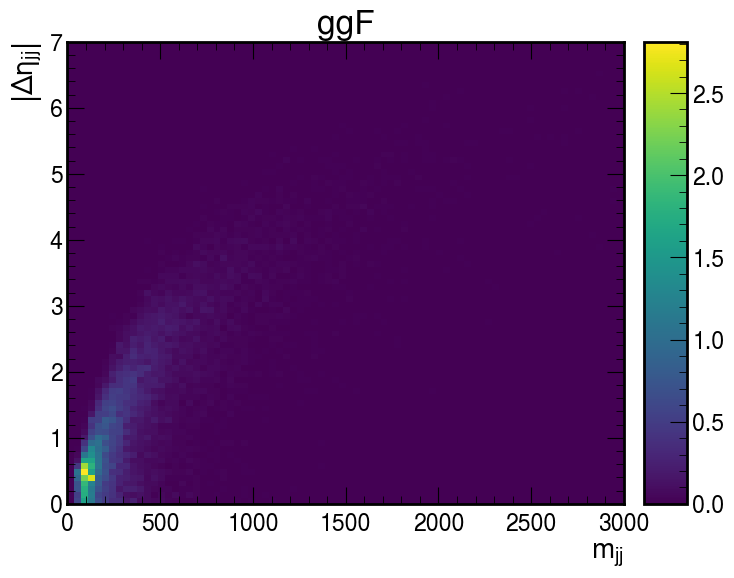

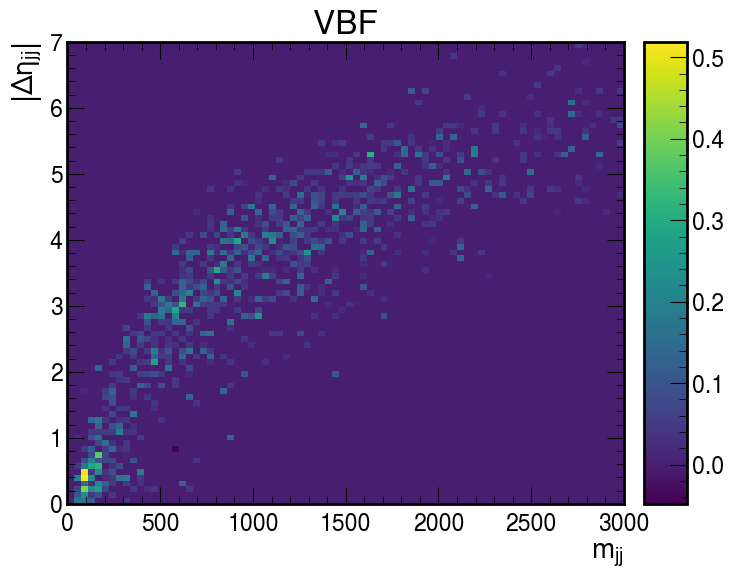

In [673]:
samples_to_plot = [
    "ggF", 
    "VBF",
]

from matplotlib.colors import LogNorm

for sample in samples_to_plot:
    fig, ax = plt.subplots(figsize=(8, 6))
    hep.hist2dplot(h[{"samples": sample}], flow="none")
    ax.set_title(sample)

    plt.savefig(f"/Users/fmokhtar/Desktop/AN/2d-{sample}.pdf")     

In [437]:
tagger = "fj_ParT_score"
tagger = "fj_ParT_score_finetuned"

presel = {    
    "Pre-selection": f"fj_pt>0",
    
#     "High purity signal region": f"({tagger}>0.97)",
#     "High purity signal region + MET>X": f"({tagger}>0.97) & (n_bjets_T==0)",
    
#     "High purity signal region + nbjetsL=0": f"({tagger}>0.97) & (n_bjets_L==0)",
#     "High purity signal region + nbjetsM=0": f"({tagger}>0.97) & (n_bjets_M==0)",
#     "High purity signal region + nbjetsT=0": f"({tagger}>0.97) & (n_bjets_T==0)",    
    
#     "Medium purity signal region + nbjetsT=0 + MET>X": f"({tagger}<0.97) & ({tagger}>0.85) & (n_bjets_T==0)",   
    
}

channels = ["ele", "mu"]
years = ["2018", "2017", "2016", "2016APV"]

# fill histograms
var = "rec_higgs_m"
var = "abs_met_fj_dphi"

samples = ["ggF", "VBF", "VH", "ttH"]

if var == "rec_higgs_m":
    h = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        hist2.axis.Variable(list(range(50, 240, 10)), name="var", label=r"Higgs reconstructed mass [GeV]", overflow=True)
    )
elif var == "abs_met_fj_dphi":
    h = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        hist2.axis.Regular(
        25, 0, 3.14, name="var", label=r"$\left| \Delta \phi(MET, Jet) \right|$", overflow=True
    ),
    )
    
else:
    h = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        utils.axis_dict[var],
    )    
ev = events_dict["sig"]

region, sel = list(presel.items())[0]

for year in ["2018"]:
    for ch in channels:    

        for sample in samples:
            for ismatched in [False]:

                df = ev[year][ch][sample]

                df = df.query(sel)    
                
                df = df[(df["fj_H_VV_isMatched"] == ismatched)]
                
                if ismatched:
                    lab = sample + "matched"
                else:
                    lab = sample
#                 df = df[(df["fj_H_VV_isVlepton"] == ismatched)]
#                 if ismatched:
#                     lab = sample + " (lepton from W)"
#                 else:
#                     lab = sample + " (lepton from W*)"
                if len(df[var])==0:
                    x = 0
                
                else:
                    x = df[var]
                    


                h.fill(
                    samples=lab,
                    var=x,
                    weight=df["event_weight"],
                )     

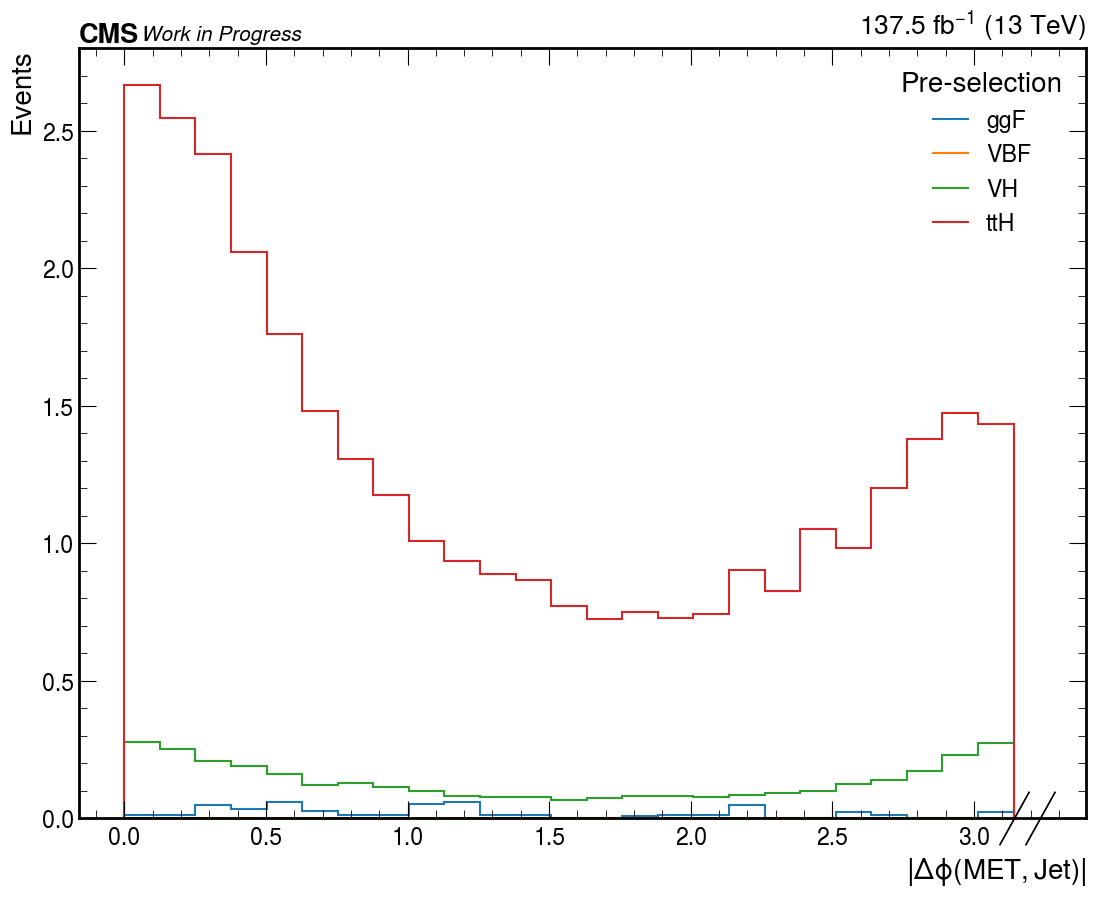

In [438]:
# different regions
fig, ax = plt.subplots(figsize=(13, 10))
for sample in list(h.axes["samples"]):
    hep.histplot(h[{"samples": sample}].project("var"),
        label=sample,
#         density=True,
#         yerr=True,
    )
ax.legend(title=region, loc="upper right")
ax.set_ylabel("Events")
ax.set_ylim(0)
# ax.set_yscale("log")

lum_=0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku5/z.pdf")     

In [124]:
dominant_backgrounds = ["WJetsLNu", "TTbar", "QCD", "DYJets"]
def get_soverb(ev, tagger, presel, categories_sel, years, channels, MET_cut=False, misocut=None, threshold=None):

    mass_window = [100, 150]

    num_sig = {
        "ggF": 0, 
        "ttH": 0, 
        "VH": 0,
        "VBF": 0,
    }
    num_bkg = {
        "WJetsLNu": 0, 
        "TTbar": 0, 
        "QCD": 0,
        "DYJets": 0,
        "Others": 0,
    }

    deno_sig, deno_bkg = 0, 0
    s, b = 0, 0

    samples = [
        "ggF", 
        "VH",
        "VBF",
        "ttH",
        "QCD",
        "DYJets",
        "WJetsLNu",
        "WZQQ",
        "TTbar",
        "SingleTop",
        "Diboson",
        "Data"
    ]

    for year in years:
        for ch in channels:
            for sample in samples:
                if sample=="Data":
                    continue

                region, sel = list(presel.items())[0]

                df = ev[year][ch][sample]

                df = df.query(sel)  

                for category, category_sel in categories_sel.items():
                    df = df.query(category_sel)

                if MET_cut:
                    df = df[df["met_pt"]>MET_cut]
                    
                if threshold:
                    if sample == "QCD":
                        df = df[df["event_weight"] < threshold]
    
                ######################## composition start
                if sample in utils.signals:

                    deno_sig += df["event_weight"].sum()
                    num_sig[sample] += df["event_weight"].sum()
                else:
                    deno_bkg += df["event_weight"].sum()

                    if sample in dominant_backgrounds:
                        num_bkg[sample] += df["event_weight"].sum()
                    else:
                        num_bkg["Others"] += df["event_weight"].sum()     
                ######################## composition end

                ######################## soverb start
                df = df[(df["rec_higgs_m"]>=mass_window[0]) & (df["rec_higgs_m"]<=mass_window[1])]

                if sample in utils.signals:                
                    s += df["event_weight"].sum()
                else:
                    b += df["event_weight"].sum()
                ######################## soverb end

    num_sig = dict(sorted(num_sig.items(), key=lambda item: item[1]))
    num_bkg = dict(sorted(num_bkg.items(), key=lambda item: item[1]))

    if len(years) == 4:
        lab = "RUN2"
    else:
        lab = "_".join(years)

    print("\033[1m" + f"{list(presel.keys())[0]} ({lab}):" + '\033[0m')
    if len(list(categories_sel.items()))!=0:
        print("Category:", list(categories_sel.keys())[0])

    print("------------------------")

    if "SR" in list(presel.keys())[0]:
        print("\033[1m" + rf"s/sqrt(b) in [{mass_window[0]},{mass_window[1]}]: {s/math.sqrt(b):.2f}" + '\033[0m')
        print("------------------------")

    print(f"Signal: {deno_sig:.2f}")
    for sample in num_sig:
        print(f"- {sample}: {100*(num_sig[sample]/deno_sig):.0f}%")

    print("------------------------")
    print(f"Background: {deno_bkg:.2f}")
    for sample in num_bkg:
        if sample=="":
            print("\033[1m" + f"- {sample}: {100*(num_bkg[sample]/deno_bkg):.0f}%")
        else:
            print(f"- {sample}: {100*(num_bkg[sample]/deno_bkg):.0f}%")             

In [126]:
presel = {
#     "Pre-selection": f"{tagger}>0.5",

#     "SR using pt flatten: score> 85": f"({tagger}>0.91) & (n_bjets_T==0)",
#     "SR2": f"({tagger}>0.97) & ({tagger}<0.98) & (n_bjets_T==0)",

#     "Signal region": f"({tagger}>0.98) & (n_bjets_T==0)",    
#     "Top control region": f"({tagger}>0.5) & (n_bjets_T>0)",
#     "W+Jets control region": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & (met_pt>100)",

    "VBF category": "(fj_ParT_score_finetuned>0.97 & n_bjets_T==0) & (mjj>1000) & (deta>3.5)",    
#     "ggF category $p_T \in [250, 300]$": "(fj_ParT_score_finetuned>0.98 & n_bjets_T==0) & ( (mjj<1000) | (deta<3.5) ) & (fj_pt>250) & (fj_pt<300)",
#     "ggF category $p_T \in [300, 450]$": "(fj_ParT_score_finetuned>0.98 & n_bjets_T==0) & ( (mjj<1000) | (deta<3.5) ) & (fj_pt>300) & (fj_pt<450)",
#     "ggF category $p_T \in [450, \\mathrm{Inf}]$": "(fj_ParT_score_finetuned>0.98 & n_bjets_T==0) & ( (mjj<1000) | (deta<3.5) ) & (fj_pt>450)",

}

mass_window = [100, 150]

num_sig = {
    "ggF": 0, 
    "ttH": 0, 
    "VH": 0,
    "VBF": 0,
}
num_bkg = {
    "WJetsLNu": 0, 
    "TTbar": 0, 
    "QCD": 0,
    "DYJets": 0,
    "Others": 0,
}

deno_sig, deno_bkg = 0, 0
s, b = 0, 0

samples = [
    "ggF", 
    "VH",
    "VBF",
    "ttH",
    "QCD",
    "DYJets",
    "WJetsLNu",
    "WZQQ",
    "TTbar",
    "SingleTop",
    "Diboson",
    "Data"
]

for year in years:
    for ch in channels:
        for sample in samples:
            if sample=="Data":
                continue

            region, sel = list(presel.items())[0]

            df = ev[year][ch][sample]

            df = df.query(sel)  

            for category, category_sel in categories_sel.items():
                df = df.query(category_sel)

            if MET_cut:
                df = df[df["met_pt"]>MET_cut]

            if threshold:
                if sample == "QCD":
                    df = df[df["event_weight"] < threshold]

            ######################## composition start
            if sample in utils.signals:

                deno_sig += df["event_weight"].sum()
                num_sig[sample] += df["event_weight"].sum()
            else:
                deno_bkg += df["event_weight"].sum()

                if sample in dominant_backgrounds:
                    num_bkg[sample] += df["event_weight"].sum()
                else:
                    num_bkg["Others"] += df["event_weight"].sum()     
            ######################## composition end

            ######################## soverb start
            df = df[(df["rec_higgs_m"]>=mass_window[0]) & (df["rec_higgs_m"]<=mass_window[1])]

            if sample in utils.signals:                
                s += df["event_weight"].sum()
            else:
                b += df["event_weight"].sum()
            ######################## soverb end

num_sig = dict(sorted(num_sig.items(), key=lambda item: item[1]))
num_bkg = dict(sorted(num_bkg.items(), key=lambda item: item[1]))

if len(years) == 4:
    lab = "RUN2"
else:
    lab = "_".join(years)

print("\033[1m" + f"{list(presel.keys())[0]} ({lab}):" + '\033[0m')
if len(list(categories_sel.items()))!=0:
    print("Category:", list(categories_sel.keys())[0])

print("------------------------")

if "SR" in list(presel.keys())[0]:
    print("\033[1m" + rf"s/sqrt(b) in [{mass_window[0]},{mass_window[1]}]: {s/math.sqrt(b):.2f}" + '\033[0m')
    print("------------------------")

print(f"Signal: {deno_sig:.2f}")
for sample in num_sig:
    print(f"- {sample}: {100*(num_sig[sample]/deno_sig):.0f}%")

print("------------------------")
print(f"Background: {deno_bkg:.2f}")
for sample in num_bkg:
    if sample=="":
        print("\033[1m" + f"- {sample}: {100*(num_bkg[sample]/deno_bkg):.0f}%")
    else:
        print(f"- {sample}: {100*(num_bkg[sample]/deno_bkg):.0f}%")    

KeyError: 'ttH'

In [ ]:
# make_pi_chart():

import matplotlib.pyplot as plt

labels, sizes = num_bkg.keys(), num_bkg.values()

colors_ = []
for sample in num_bkg.keys():
    if sample == "Others":
        colors_.append("tab:grey")
    else:
        colors_.append(utils.color_by_sample[sample])

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors_);
plt.savefig(f"/Users/fmokhtar/Desktop/AN/pie_wjets.pdf")

In [127]:
def make_composition_table(ev, presel, add_soverb=False):

    from collections import OrderedDict

    all_MCsamples = [
        "ggF", 
        "VH",
        "VBF",
        "ttH",
        "QCD",
        "DYJets",
        "WJetsLNu",
        "WZQQ",
        "TTbar",
        "SingleTop",
        "Diboson",
        "EWKvjets",        
    ]
    sig = ["ttH", "VH", "VBF", "ggF"]
    bkg = ["TTbar", "WJetsLNu", "QCD", "Others"]

    mass_window = [100, 150]
    
    # make table
    print("\\begin{table}[!ht]")
    print("\\begin{center}")
    
    if add_soverb:
        print("\\caption{Event yield contribution from different processes in the search regions for the full Run2 dataset. The last column includes $s/\sqrt{b}$ in a mass window of 100-150\GeV in the mass observable (the Higgs reconstructed mass).}")
    else:
        print("\\caption{Event yield contribution from different processes in the search regions for the full Run2 dataset.}")
        
    if add_soverb:
        print("\\begin{tabular}{c|cccc|cccc|c}")
    else:
        print("\\begin{tabular}{c|cccc|cccc}")

    if add_soverb:    
        print("& \\multicolumn{4}{c|}{Signal yield} & \\multicolumn{4}{c|}{Background yield} & \\multicolumn{1}{c}{$s/\sqrt{b}$} \\\\\n")
        print("& ttH & VBF & VH  & ggF & \\ttbar & W$+$jets & QCD & Other & \\\\\n")        
    else:
        print("& \\multicolumn{4}{c|}{Signal yield} & \\multicolumn{4}{c}{Background yield} \\\\\n")
        print("& ttH & VBF & VH  & ggF & \\ttbar & W$+$jets & QCD & Other \\\\\n")        
    print("\\hline")
    print("\\hline")

    for region, sel in presel.items():

        sig_dict = OrderedDict({
            "ttH": 0, 
            "VH": 0, 
            "VBF": 0,
            "ggF": 0,  
        })

        bkg_dict = OrderedDict({
            "TTbar": 0,
            "WJetsLNu": 0,  
            "QCD": 0,
            "Others": 0,    
        })

        tot_sig, tot_bkg = 0, 0
        s, b = 0, 0   # in mass window [100, 150]
        for year in years:
            for ch in channels:
                for sample in all_MCsamples:

                    try:
                        df = ev[year][ch][sample]
                    except:
                        continue

                    df = df.query(sel)  

                    if sample in sig_dict:
                        tot_sig += df["event_weight"].sum()                    
                        sig_dict[sample] += df["event_weight"].sum()
                    elif sample in bkg_dict:
                        tot_bkg += df["event_weight"].sum()
                        bkg_dict[sample] += df["event_weight"].sum()
                    else:
                        tot_bkg += df["event_weight"].sum()                        
                        bkg_dict["Others"] += df["event_weight"].sum()                    

                    ######################## soverb start
                    df = df[(df["rec_higgs_m"]>=mass_window[0]) & (df["rec_higgs_m"]<=mass_window[1])]

                    if sample in sig_dict:                
                        s += df["event_weight"].sum()
                    else:
                        b += df["event_weight"].sum()
                    ######################## soverb end

        texdata = "\multirow{2}{*}{" + region + "} & \multicolumn{4}{c|}{"
        texdata += str(round(tot_sig))
        
        if add_soverb:
            texdata += "} & \multicolumn{4}{c|}{"
            texdata += str(round(tot_bkg))
            texdata += "} & \multicolumn{1}{c}{"            
#             texdata += str(round(s/(b**0.5),3))
            texdata += "\multirow{2}{*}{" + str(round(s/(b**0.5),3)) + "}"
            
            texdata += "} \\\\\n"
        else:
            texdata += "} & \multicolumn{4}{c}{"
            texdata += str(round(tot_bkg))
            texdata += "} \\\\\n"
        
#         texdata += "\\cline{2-9} \n"
        
        for sample in sig_dict:
            texdata += f" & {(100*sig_dict[sample]/tot_sig):.0f}\%"
        for sample in bkg_dict:
            texdata += f" & {(100*bkg_dict[sample]/tot_bkg):.0f}\%"
        
        if add_soverb:
            texdata += " & "

        texdata += " \\\\\n"
        print(texdata)
        print("\\hline")

    print("\\hline")
    print("\\end{tabular}")
    print("\\label{region}")
    print("\\end{center}")
    print("\\end{table}")      

In [179]:
tagger = "fj_ParT_score_finetuned"
presel = {
#     "Pre-selection": f"{tagger}>0.5",

#     "SR using pt flatten: score> 85": f"({tagger}>0.91) & (n_bjets_T==0)",
#     "SR2": f"({tagger}>0.97) & ({tagger}<0.98) & (n_bjets_T==0)",

    "Signal region": f"(fj_ParT_score_finetuned>0.98) & (n_bjets_T==0)",    
    "Top control region": f"(fj_ParT_score_finetuned>0.5) & (n_bjets_T>0)",
    "W+Jets control region": f"(fj_ParT_score_finetuned<0.97) & (fj_ParT_score_finetuned>0.50) & (n_bjets_T==0) & (met_pt>100)",

#     "VBF category": "(fj_ParT_score_finetuned>0.97 & n_bjets_T==0) & (mjj>1000) & (deta>3.5)",    
#     "ggF category $p_T \in [250, 300]$": "(fj_ParT_score_finetuned>0.98 & n_bjets_T==0) & ( (mjj<1000) | (deta<3.5) ) & (fj_pt>250) & (fj_pt<300)",
#     "ggF category $p_T \in [300, 450]$": "(fj_ParT_score_finetuned>0.98 & n_bjets_T==0) & ( (mjj<1000) | (deta<3.5) ) & (fj_pt>300) & (fj_pt<450)",
#     "ggF category $p_T \in [450, \\mathrm{Inf}]$": "(fj_ParT_score_finetuned>0.98 & n_bjets_T==0) & ( (mjj<1000) | (deta<3.5) ) & (fj_pt>450)",

}

make_composition_table(events_dict["new_corrections2"], presel, add_soverb=True)

\begin{table}[!ht]
\begin{center}
\caption{Event yield contribution from different processes in the search regions for the full Run2 dataset. The last column includes $s/\sqrt{b}$ in a mass window of 100-150\GeV in the mass observable (the Higgs reconstructed mass).}
\begin{tabular}{c|cccc|cccc|c}
& \multicolumn{4}{c|}{Signal yield} & \multicolumn{4}{c|}{Background yield} & \multicolumn{1}{c}{$s/\sqrt{b}$} \\

& ttH & VBF & VH  & ggF & \ttbar & W$+$jets & QCD & Other & \\

\hline
\hline
\multirow{2}{*}{Signal region} & \multicolumn{4}{c|}{67} & \multicolumn{4}{c|}{846} & \multicolumn{1}{c}{\multirow{2}{*}{2.242}} \\
 & 2\% & 11\% & 38\% & 49\% & 26\% & 56\% & 2\% & 17\% &  \\

\hline
\multirow{2}{*}{Top control region} & \multicolumn{4}{c|}{41} & \multicolumn{4}{c|}{16216} & \multicolumn{1}{c}{\multirow{2}{*}{0.22}} \\
 & 62\% & 10\% & 8\% & 21\% & 72\% & 16\% & 5\% & 7\% &  \\

\hline
\multirow{2}{*}{W+Jets control region} & \multicolumn{4}{c|}{76} & \multicolumn{4}{c|}{26519} & \mult

# Stacked hists

In [844]:
def fix_neg_yields(h):
    """
    Will set the bin yields of a process to 0 if the nominal yield is negative, and will
    set the yield to 0 for the full Systematic axis.
    """
    for sample in h.axes["samples"]:
        neg_bins = np.where(h[{"samples": sample}].values() < 0)[0]

        if len(neg_bins) > 0:
            print(f"{sample}, has {len(neg_bins)} bins with negative yield.. will set them to 0")

            sample_index = np.argmax(np.array(h.axes["samples"]) == sample)

            for neg_bin in neg_bins:
                h.view(flow=True)[sample_index, neg_bin + 1] = 0

In [947]:
vars_to_plot = [
#     "fj_msoftdrop",        
#     "rec_W_lnu_m",
#     "fj_pt",
#     "lep_pt",
#     "lep_eta",
    "rec_higgs_m",
    
#     "lep_fj_dr",
#     "lep_met_mt",
#     "met_fj_dphi",
#     "met_pt",    
    
#     "btag_1a",
#     "0btag_1b",
#     "1pbtag_1b",
    
#     "0btagT_btagSF",
#     "1plusbtagT_btagSF"
    
#     "rec_higgs_etajet_m",
#     "fj_ParT_mass",
#     "fj_ParT_score_finetuned"
    
    # AN
#     "FirstFatjet_pt",
#     "SecondFatjet_pt",
#     "fj_pt",
#     "lep_pt",
#     "NumFatjets",
#     "NumOtherJets",
#     "lep_fj_dr",
#     "met_pt",
#     "met_fj_dphi",
#     "lep_met_mt",    
#     "ht",
#     "fj_mass",
#     "rec_W_qq_m",
#     "rec_W_lnu_m",    
#     "fj_lsf3",
    
#     "lep_isolation",
#     "lep_isolation_ele",
#     "lep_isolation_ele_highpt",
#     "lep_isolation_ele_lowpt",
    
#     "lep_isolation_mu",
#     "lep_isolation_mu_highpt",
#     "lep_isolation_mu_lowpt",   
    
#     "lep_misolation",
#     "lep_misolation_highpt",
#     "lep_misolation_lowpt",    
]

samples_to_plot = [
    "ggF", 
    "VH",
    "VBF",
    "ttH",
    "QCD",
    "DYJets",
    "WJetsLNu",
#     "WJetsLNu_unmatched",
#     "WJetsLNu_matched",
    "WZQQ",
    "TTbar",
    "SingleTop",
    "Diboson",
    "EWKvjets",
    "Data",
]

# samples_to_plot = ["QCD"]

In [1016]:
# tagger = "fj_ParT_score"
# tagger = "fj_ParT_score_finetuned"
tagger = "fj_ParT_score_finetuned_v35_2"

tagger_cut = 0.975
# tagger_cut = 0.9
presel = {
#     "Pre-selection": f"fj_pt>0",   # dummy
    "SR": f"({tagger}>{tagger_cut}) & (n_bjets_T==0)",   # dummy
    
#     "Pre-selection": f"{tagger}>0.95",
    
#     "Pre-selection": f"(fj_ParT_score_finetuned>0.95) & (fj_msoftdrop>10)",   # dummy    
    
#     "Pre-selection": f"met_pt>100 & ({tagger}<0.5) & n_bjets_T>0",   # dummy    
#     "Pre-selection": f"met_pt>100 & n_bjets_T>0",   # dummy    

#     "Pre-selection": f"met_pt>100 & n_bjets_L==0 & {tagger}>0.5 & {tagger}<0.97",   # dummy    
    
#     "Pre-selection": f"met_pt>20",

#     "SR": f"({tagger}>0.98) & (n_bjets_T==0)",    
    
#     "SR2": f"({tagger}>0.97) & ({tagger}<0.98) & (n_bjets_T==0)",
#     "WJets CR": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & (met_pt>100)",
#     "Top CR": f"({tagger}>0.5) & (n_bjets_T>0)",
}

categories_sel = {
#     "VBF": f"( (fj_ParT_score_finetuned>{tagger_cut}) & (n_bjets_T==0) ) & ( (mjj>1000) & (deta>3.5) )",
#     rf"ggF": "(mjj<1000) | (deta<3.5)",
        
#     r"ggF pT [250, 300]": f"( (fj_ParT_score_finetuned>{tagger_cut}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (fj_pt>250) & (fj_pt<300) )",
    f"ggF pT [300, 450]": f"( (fj_ParT_score_finetuned>{tagger_cut}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (fj_pt>300) & (fj_pt<450) )",
#     r"ggF pT [450, Inf]": f"( (fj_ParT_score_finetuned>{tagger_cut}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (fj_pt>450) )",
}

channels = ["ele", "mu"]
# channels = ["ele"]
years = ["2018", "2017", "2016", "2016APV"]
# years = ["2018"]

num, den = 0, 0
threshold = 0

# fill histograms
hists = {}

# ev = events_dict["new_correctionsNOTAGGER"]

ev = events_dict["wjetsHT"]
# ev = events_dict["wjetsNLO"]

# ev = events_dict["new_correctionsNODPHI"]

MET_cut = False
import utilsAN

massbin = 20
for var in vars_to_plot:

    if var == "rec_higgs_m":
        hists[var] = hist2.Hist(
            hist2.axis.StrCategory([], name="samples", growth=True),
#             hist2.axis.Variable(list(range(45, 210, massbin)), name="var", label=r"Higgs reconstructed mass [GeV]", overflow=True)
            hist2.axis.Variable(list(range(45, 210, massbin)), name="var", label=r"Higgs reconstructed mass (Option 1) [GeV]", overflow=True)
        )
    elif var == "rec_higgs_etajet_m":
        hists[var] = hist2.Hist(
            hist2.axis.StrCategory([], name="samples", growth=True),
#             hist2.axis.Variable(list(range(45, 210, massbin)), name="var", label=r"PKU definition Higgs reconstructed mass [GeV]", overflow=True)
            hist2.axis.Variable(list(range(45, 210, massbin)), name="var", label=r"Higgs reconstructed mass (Option 2) [GeV]", overflow=True)

        )      
    elif var == "fj_ParT_mass":
        hists[var] = hist2.Hist(
            hist2.axis.StrCategory([], name="samples", growth=True),
            hist2.axis.Variable(list(range(45, 210, massbin)), name="var", label=r"ParT regressed mass [GeV]", overflow=True)
        )              
    else:
        hists[var] = hist2.Hist(
            hist2.axis.StrCategory([], name="samples", growth=True),
            utilsAN.axis_dict[var],
#             hist2.axis.Regular(50, 0, 1, name="var", label=r"tagger", overflow=True)
            
        )        
        
    for sample in samples_to_plot:
        for year in years:
            for ch in channels:
            
                region, sel = list(presel.items())[0]
                
#                 if sample == "DYJets":
#                     continue  
#                 if sample == "WJetsLNu":
#                     df = ev[year][ch][sample]
#                     df = pd.concat([df, ev[year][ch]["DYJets"]])
#                 else:
#                     df = ev[year][ch][sample]


#                 if "WJetsLNu" in sample:
#                     df = ev[year][ch]["WJetsLNu"]
                    
#                     if "unmatched" in sample:
#                         df = df[df["fj_V_isMatched"]!=1]
#                     else:
#                         df = df[df["fj_V_isMatched"]==1]
                
#                 else:
#                     df = ev[year][ch][sample]
        
                df = ev[year][ch][sample]
                
                df = df.query(sel)
                    
                if "MET>X" in region:
                    MET_cut = 100
                    df = df[df["met_pt"]>MET_cut]
                                
                if len(categories_sel)>=1:
                    category, category_sel = list(categories_sel.items())[0]
                    df = df.query(category_sel)
            
                if sample == "QCD":
                    threshold = 30
                    den += len(df['event_weight'])
                    num += sum(df["event_weight"]>threshold)

                    df = df[df["event_weight"] < threshold]
                
                
                if "lep_isolation_ele" in var:
                    if ch=="ele":
                        
                        if "highpt" in var:
                            df = df[(df["lep_pt"]>120)]
                        elif "lowpt" in var:
                            df = df[(df["lep_pt"]<120)]                            

                        x = df["lep_isolation"]
                    else:
                        continue
                        
                elif "lep_isolation_mu" in var:
                    if ch=="mu":
                        
                        if "highpt" in var:
                            df = df[(df["lep_pt"]>55)]
                        elif "lowpt" in var:
                            df = df[(df["lep_pt"]<55)] 

                        x = df["lep_isolation"]

                    else:
                        continue
                    
                elif "lep_misolation" in var:
                    if ch == "mu":
                        if "highpt" in var:
                            df = df[(df["lep_pt"]>55)]
                        elif "lowpt" in var:
                            df = df[(df["lep_pt"]<55)] 

                        x = df["lep_misolation"]
                        
                    else:
                        continue

                else:
                    x = df[var]
                    
#                 if var == "lep_eta":
#                     x = np.absolute(df[var])
                
#                 df = df[np.absolute(df["lep_eta"])<0.5]
#                 x = df[var]
                
                w = df["event_weight"]
                
#                 if sample != "Data":
# #                     w *= df["btag_1a"]
#                     w *= df["0btag_1b"]
# #                     w *= df["1pbtag_1b"]

                hists[var].fill(
                    samples=sample,
                    var=x,
                    weight=w,
                )     
try:
    print(f"Removing {num} out of {den} qcd events by applying event_weight<{threshold} ({(100*num/den):.2f}%)")
except:
    z=1
    
for var in vars_to_plot:
    fix_neg_yields(hists[var])

Removing 0 out of 4 qcd events by applying event_weight<30 (0.00%)
SingleTop, has 1 bins with negative yield.. will set them to 0


Will plot rec_higgs_m histogram
SR (RUN2):
Category: ggF pT [300, 450]
------------------------
s/sqrt(b) in [100,150]: 1.21
------------------------
Signal: 17.52
- ttH: 3%
- VH: 14%
- VBF: 26%
- ggF: 58%
------------------------
Background: 225.09
- DYJets: 1%
- QCD: 2%
- Others: 13%
- TTbar: 35%
- WJetsLNu: 49%


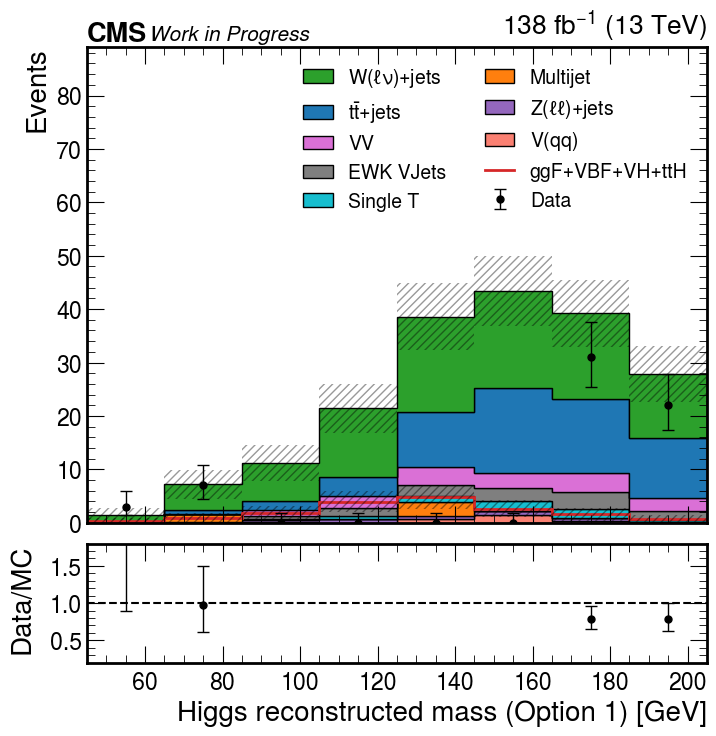

In [1017]:
plt.rcParams.update({"font.size": 20})
add_data = True

    
if "SR" in region or ("Signal region") in region:
    add_soverb=True
    blind_region=[90,160]
    if "SR1" in region:
        mult=1
    else:
        mult=1
else:
    add_soverb=True
    blind_region=None
    mult=1
    
    
from utils import plot_hists
if len(years) > 1:
    from utilsF import plot_hists
    PATH = f"/Users/fmokhtar/Desktop/AN_2024/preselection_Run2/"
    
#     PATH = f"/Users/fmokhtar/Desktop/AN_2024/sig_region_{list(categories_sel.keys())[0]}_Run2/"
else:
    from utilsAN import plot_hists
    PATH = f"/Users/fmokhtar/Desktop/AN_2024/preselection_{years[0]}/"
#     PATH = f"/Users/fmokhtar/Desktop/AN_2024/sig_region_{list(categories_sel.keys())[0]}_{years[0]}/"

PATH = f"/Users/fmokhtar/Desktop/AN_2024/lol/"
# from utilsF import plot_hists

if not os.path.exists(PATH):
    # Create the directory
    os.makedirs(PATH)    


plot_hists(hists, years, channels, vars_to_plot,             
            add_data=add_data,
            logy=False,
            add_soverb=add_soverb,
            only_sig=False,
            mult=mult,
            outpath=PATH,
            text_=region,
#             text_=region + f"\n {list(categories_sel.keys())[0]} category",
#             text_=region + f"\n category: {list(categories_sel.keys())[0]} \n Applying qcd event_weight<{threshold}",
#             text_=region + f"\n Applying qcd event_weight<{threshold}",

            blind_region=blind_region,
#            save_as=f"{years[0]}_{channels[0]}"
#            save_as=f"{ch}"
           
          )
# print()
get_soverb(ev, tagger, presel, categories_sel, years, channels, threshold=threshold, MET_cut=MET_cut)

In [1065]:
! ls ../eos/Feb9_2016/

DYJetsToLL_LHEFilterPtZ-0To50
DYJetsToLL_LHEFilterPtZ-100To250
DYJetsToLL_LHEFilterPtZ-250To400
DYJetsToLL_LHEFilterPtZ-400To650
DYJetsToLL_LHEFilterPtZ-50To100
DYJetsToLL_LHEFilterPtZ-650ToInf
EWKWminus_WToLNu
EWKWminus_WToQQ
EWKWplus_WToLNu
EWKWplus_WToQQ
EWKZ_ZToLL
EWKZ_ZToNuNu
EWKZ_ZToQQ
GluGluHToTauTau
GluGluHToWW_Pt-200ToInf_M-125
GluGluZH_HToWW_M-125_TuneCP5_13TeV-powheg-pythia8
HWminusJ_HToWW_M-125
HWplusJ_HToWW_M-125
HZJ_HToWW_M-125
QCD_Pt_1000to1400
QCD_Pt_120to170
QCD_Pt_1400to1800
QCD_Pt_170to300
QCD_Pt_1800to2400
QCD_Pt_2400to3200
QCD_Pt_300to470
QCD_Pt_3200toInf
QCD_Pt_470to600
QCD_Pt_600to800
QCD_Pt_800to1000
ST_s-channel_4f_hadronicDecays
ST_s-channel_4f_leptonDecays
ST_t-channel_antitop_4f_InclusiveDecays
ST_t-channel_top_4f_InclusiveDecays
ST_tW_antitop_5f_inclusiveDecays
ST_tW_top_5f_inclusiveDecays
SingleElectron_Run2016F
SingleElectron_Run2016G
SingleElectron_Run2016H
SingleMuon_Run2016F
SingleMuon_Run2016G
SingleMuon_Run2016H
TTTo2L2Nu
TTToHadronic
TTToSemiLeptoni

In [1081]:
! ls ../eos/Feb9_2016/TTToSemiLeptonic/outfiles

0-10.pkl              290-300_mu.parquet    640-650_ele.parquet
0-10_ele.parquet      30-40.pkl             640-650_mu.parquet
0-10_mu.parquet       30-40_ele.parquet     650-660.pkl
10-20.pkl             30-40_mu.parquet      650-660_ele.parquet
10-20_ele.parquet     300-310.pkl           650-660_mu.parquet
10-20_mu.parquet      300-310_ele.parquet   660-670.pkl
100-110.pkl           300-310_mu.parquet    660-670_ele.parquet
100-110_ele.parquet   310-320.pkl           660-670_mu.parquet
100-110_mu.parquet    310-320_ele.parquet   670-680.pkl
1000-1010.pkl         310-320_mu.parquet    670-680_ele.parquet
1000-1010_ele.parquet 320-330.pkl           670-680_mu.parquet
1000-1010_mu.parquet  320-330_ele.parquet   680-690.pkl
1010-1020.pkl         320-330_mu.parquet    680-690_ele.parquet
1010-1020_ele.parquet 330-340.pkl           680-690_mu.parquet
1010-1020_mu.parquet  330-340_ele.parquet   690-700.pkl
1020-1030.pkl         330-340_mu.parquet    690-700_ele.parquet
1020-1030_ele.parquet

In [1084]:
df = pd.read_parquet("../eos/Feb9_2016/TTToSemiLeptonic/outfiles/0-10_ele.parquet")
[x for x in df.keys() if ("weight_ele") in x and "Up" in x]

['weight_ele_pileupUp',
 'weight_ele_trigger_electronUp',
 'weight_ele_id_electronUp',
 'weight_ele_L1PrefiringUp',
 'weight_ele_isolation_electronUp',
 'weight_ele_pileupIDSFUp',
 'weight_ele_reco_electronUp']

In [1078]:
df = pd.read_parquet("../eos/Feb9_2016/GluGluHToWW_Pt-200ToInf_M-125/outfiles/0-2_ele.parquet")
[x for x in df.keys() if ("weight_ele") in x and "Up" in x]

['weight_ele_isolation_electronUp',
 'weight_ele_reco_electronUp',
 'weight_ele_trigger_electronUp',
 'weight_ele_pileupUp',
 'weight_ele_PSFSRUp',
 'weight_ele_PSISRUp',
 'weight_ele_id_electronUp',
 'weight_ele_pileupIDSFUp',
 'weight_ele_L1PrefiringUp']

In [1076]:
df = pd.read_parquet("../eos/Feb9_2016/WJetsToLNu_HT-200To400/outfiles/0-10_ele.parquet")
[x for x in df.keys() if ("weight_mu") in x and "Up" in x]

['weight_mu_d2K_NLOUp',
 'weight_mu_pileupIDSFUp',
 'weight_mu_d1K_NLOUp',
 'weight_mu_trigger_iso_muonUp',
 'weight_mu_id_muonUp',
 'weight_mu_L1PrefiringUp',
 'weight_mu_pileupUp',
 'weight_mu_isolation_muonUp',
 'weight_mu_W_d3kappa_EWUp',
 'weight_mu_trigger_noniso_muonUp',
 'weight_mu_d1kappa_EWUp',
 'weight_mu_d3K_NLOUp',
 'weight_mu_W_d2kappa_EWUp']

In [1077]:
df = pd.read_parquet("../eos/Feb9_2016/QCD_Pt_170to300/outfiles/0-10_ele.parquet")
[x for x in df.keys() if ("weight_mu") in x and "Up" in x]

['weight_mu_pileupIDSFUp',
 'weight_mu_trigger_iso_muonUp',
 'weight_mu_id_muonUp',
 'weight_mu_L1PrefiringUp',
 'weight_mu_pileupUp',
 'weight_mu_trigger_noniso_muonUp',
 'weight_mu_isolation_muonUp']

In [ ]:
df = pd.read_parquet("../eos/Feb9_2016/QCD_Pt_170to300/outfiles/0-10_ele.parquet")
[x for x in df.keys() if ("weight_mu") in x and "Up" in x]

In [1024]:
df = pd.read_parquet("../eos/Feb9_2016/GluGluHToWW_Pt-200ToInf_M-125/outfiles/0-2_ele.parquet")

In [1047]:
[x for x in df.keys() if "weight" in x]

['weight_ewkcorr',
 'weight_qcdcorr',
 'weight_altqcdcorr',
 'weight_ele',
 'weight_ele_isolation_electronDown',
 'weight_ele_pileupIDSFDown',
 'weight_ele_pileupIDSFUp',
 'weight_ele_L1PrefiringUp',
 'weight_ele_pileupUp',
 'weight_ele_reco_electronUp',
 'weight_ele_trigger_electronDown',
 'weight_ele_pileupDown',
 'weight_ele_isolation_electronUp',
 'weight_ele_id_electronDown',
 'weight_ele_L1PrefiringDown',
 'weight_ele_reco_electronDown',
 'weight_ele_trigger_electronUp',
 'weight_ele_id_electronUp',
 'weight_btag',
 'weight_btagSFlight2016Up',
 'weight_btagSFlight2016Down',
 'weight_btagSFbc2016Up',
 'weight_btagSFbc2016Down',
 'weight_btagSFlightCorrelatedUp',
 'weight_btagSFlightCorrelatedDown',
 'weight_btagSFbcCorrelatedUp',
 'weight_btagSFbcCorrelatedDown',
 'weight_mu',
 'weight_mu_trigger_iso_muonDown',
 'weight_mu_isolation_muonDown',
 'weight_mu_pileupIDSFDown',
 'weight_mu_id_muonDown',
 'weight_mu_pileupIDSFUp',
 'weight_mu_trigger_iso_muonUp',
 'weight_mu_trigger_noni

In [1028]:
[x for x in df.keys() if "up" in x]

['fj_ptJES_up',
 'fj_ptJER_up',
 'fj_massJMS_up',
 'fj_massJMR_up',
 'mjjJES_up',
 'mjjJER_up',
 'rec_higgs_mUES_up',
 'rec_higgs_ptUES_up',
 'rec_higgs_mJES_up',
 'rec_higgs_ptJES_up',
 'rec_higgs_mJER_up',
 'rec_higgs_ptJER_up',
 'rec_higgs_mJMS_up',
 'rec_higgs_ptJMS_up',
 'rec_higgs_mJMR_up',
 'rec_higgs_ptJMR_up',
 'weight_ele_pileupDown',
 'weight_ele_pileupIDSFDown',
 'weight_ele_pileupUp',
 'weight_ele_pileupIDSFUp',
 'weight_mu_pileupDown',
 'weight_mu_pileupIDSFDown',
 'weight_mu_pileupUp',
 'weight_mu_pileupIDSFUp']

In [1029]:
df["rec_higgs_mUES_up"]

0       62.063765
1       53.597247
2       99.441690
3      192.811297
4       97.289242
          ...    
144     85.355470
145    100.704027
146    132.290624
147    129.838581
148    219.134222
Name: rec_higgs_mUES_up, Length: 149, dtype: float64

In [1031]:
df["rec_higgs_m"]

0       61.246383
1       52.808486
2      103.822484
3      192.363285
4       97.144464
          ...    
144     84.392250
145    100.862193
146    128.687347
147    131.025771
148    217.213500
Name: rec_higgs_m, Length: 149, dtype: float64

In [1032]:
df["rec_higgs_m"]/df["rec_higgs_mUES_up"]

0      0.986830
1      0.985284
2      1.044054
3      0.997676
4      0.998512
         ...   
144    0.988715
145    1.001571
146    0.972762
147    1.009144
148    0.991235
Length: 149, dtype: float64

Text(0, 1, 'ggHWW events')

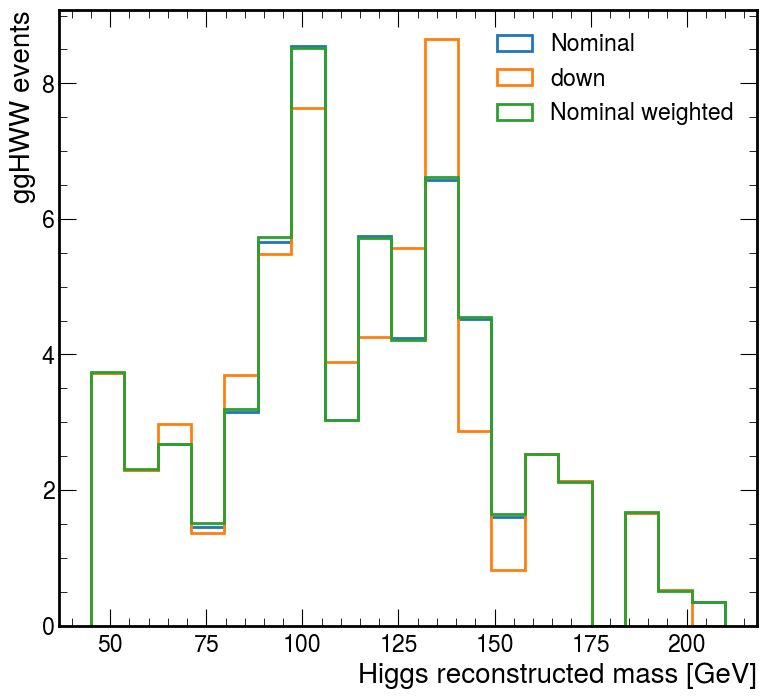

In [1041]:
fig, ax = plt.subplots(figsize=(9,8))

bins = np.linspace(45,210,20)

ax.hist(df["rec_higgs_m"], label="Nominal", weights=df["weight_ele"],
        bins=bins, lw=2, histtype="step", 
       )
ax.hist(df["rec_higgs_mUES_down"], label="down", weights=df["weight_ele"],
        bins=bins, lw=2, histtype="step", 
       )

w  = df["rec_higgs_m"]/df["rec_higgs_mUES_down"]
ax.hist(df["rec_higgs_m"], label="Nominal weighted", weights=df["weight_ele"] * w,
        bins=bins, lw=2, histtype="step", 
       )

ax.legend()
ax.set_xlabel("Higgs reconstructed mass [GeV]")
ax.set_ylabel("ggHWW events")
#         plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/JMSR/weight_{ch}_{syst}.pdf")

In [1014]:
df = {}
df["ele"] = pd.read_parquet("outfiles/0-15_ele.parquet")
[x for x in df["ele"].keys() if "rec_higgs" in x]
[x for x in df["ele"].keys()]
[x for x in df["ele"].keys() if "weight" in x]

FileNotFoundError: [Errno 2] No such file or directory: 'outfiles/0-15_ele.parquet'

Text(0, 1, 'ggHWW events')

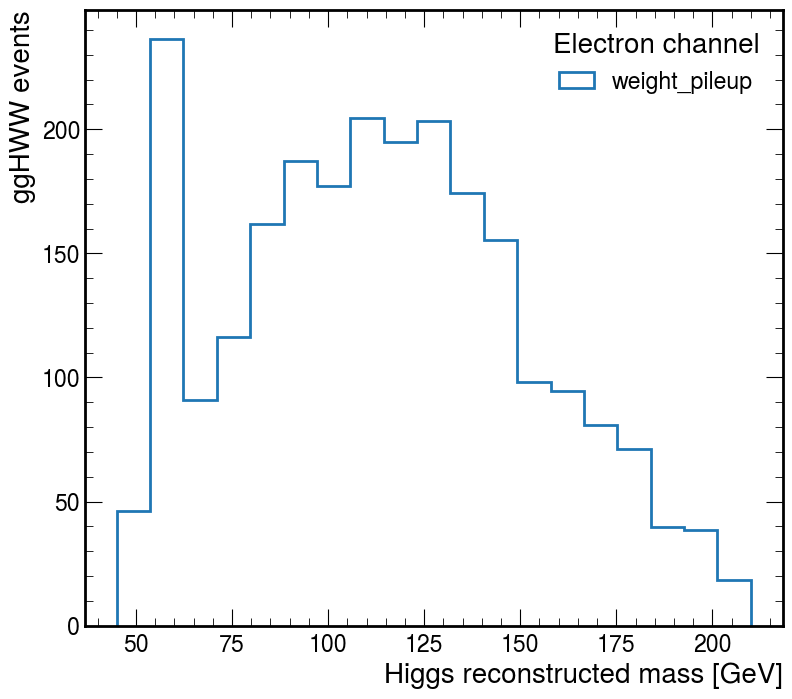

In [651]:
fig, ax = plt.subplots(figsize=(9,8))

bins = np.linspace(45,210,20)

syst = "weight_pileup"
ax.hist(df["ele"]["rec_higgs_m"], label=syst, weights=df["ele"][syst],
        bins=bins, lw=2, histtype="step", 
       )

ax.legend(title=f"{lab['ele']} channel")
ax.set_xlabel("Higgs reconstructed mass [GeV]")
ax.set_ylabel("ggHWW events")
#         plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/JMSR/weight_{ch}_{syst}.pdf")

Text(0, 1, 'ggHWW events')

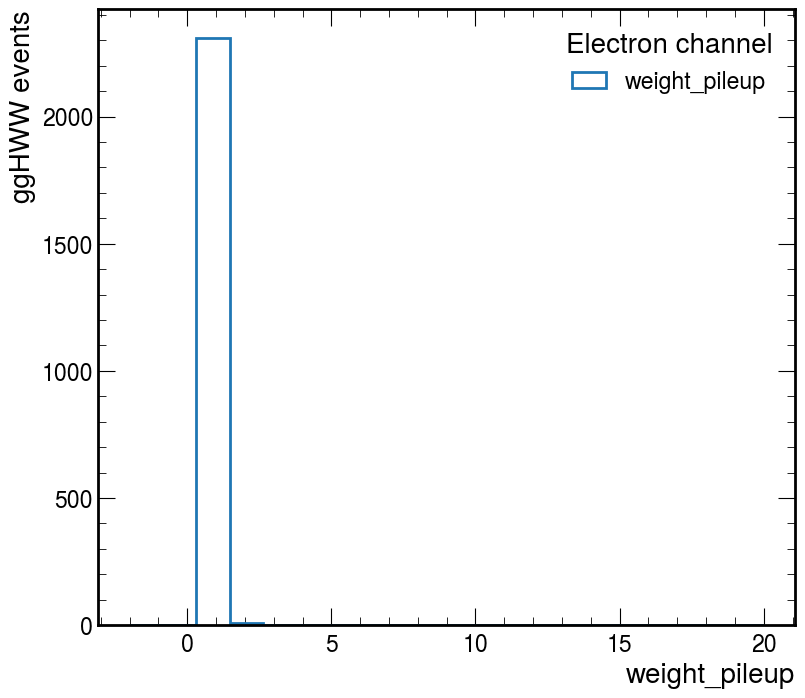

In [653]:
fig, ax = plt.subplots(figsize=(9,8))

bins = np.linspace(-2,20,20)

syst = "weight_pileup"
ax.hist(df["ele"][syst], label=syst,
        bins=bins, lw=2, histtype="step", 
       )

ax.legend(title=f"{lab['ele']} channel")
ax.set_xlabel(syst)
ax.set_ylabel("ggHWW events")
#         plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/JMSR/weight_{ch}_{syst}.pdf")

In [671]:
(df["ele"]["weight_pileup"]>4).sum()

4

In [731]:
with open("outfiles/0-5.pkl", "rb") as f:
    metadata = pickle.load(f)

In [732]:
metadata

{'GluGluHToWW_Pt-200ToInf_M-125': {'mc': 12,
  '2018': {'sumgenweight': 56116.35,
   'sumlheweight': {0: 69628.08,
    1: 67911.484,
    2: 66556.51,
    3: 58102.4,
    4: 56116.35,
    5: 54459.75,
    6: 48660.293,
    7: 46675.25,
    8: 44982.07},
   'sumpdfweight': {0: 56116.35,
    1: 56092.797,
    2: 56027.555,
    3: 56122.984,
    4: 56221.168,
    5: 56039.3,
    6: 56227.477,
    7: 56120.816,
    8: 56148.53,
    9: 56102.203,
    10: 56080.695,
    11: 56123.67,
    12: 56182.156,
    13: 56195.473,
    14: 56245.617,
    15: 56214.797,
    16: 56190.207,
    17: 56199.734,
    18: 56005.992,
    19: 56030.586,
    20: 56099.66,
    21: 56034.066,
    22: 56091.207,
    23: 56171.88,
    24: 55996.836,
    25: 56121.06,
    26: 56076.1,
    27: 56074.49,
    28: 56098.39,
    29: 55968.793,
    30: 56118.22,
    31: 55971.305,
    32: 56113.375,
    33: 56092.86,
    34: 56002.35,
    35: 56128.652,
    36: 56211.242,
    37: 56057.402,
    38: 56117.47,
    39: 56088.9,

In [742]:
df = {}
df["ele"] = pd.read_parquet("outfiles/0-1_ele.parquet")
df["mu"] = pd.read_parquet("outfiles/0-1_mu.parquet")

lab = {
    "ele": "Electron",
    "mu": "Muon",    
}

[thing for thing in df["mu"] if "weight" in thing]

['weight_ewkcorr',
 'weight_qcdcorr',
 'weight_altqcdcorr',
 'weight_scale0',
 'weight_scale1',
 'weight_scale3',
 'weight_scale5',
 'weight_scale7',
 'weight_scale8',
 'weight_scale4',
 'weight_ele',
 'weight_ele_pileupIDSFUp',
 'weight_ele_W_d3kappa_EWUp',
 'weight_ele_isolation_electronDown',
 'weight_ele_d1kappa_EWDown',
 'weight_ele_W_d2kappa_EWDown',
 'weight_ele_d3K_NLODown',
 'weight_ele_pileupUp',
 'weight_ele_id_electronDown',
 'weight_ele_d3K_NLOUp',
 'weight_ele_pileupDown',
 'weight_ele_d2K_NLOUp',
 'weight_ele_pileupIDSFDown',
 'weight_ele_d2K_NLODown',
 'weight_ele_trigger_electronUp',
 'weight_ele_isolation_electronUp',
 'weight_ele_W_d3kappa_EWDown',
 'weight_ele_W_d2kappa_EWUp',
 'weight_ele_d1kappa_EWUp',
 'weight_ele_trigger_electronDown',
 'weight_ele_d1K_NLODown',
 'weight_ele_id_electronUp',
 'weight_ele_reco_electronDown',
 'weight_ele_reco_electronUp',
 'weight_ele_d1K_NLOUp',
 'weight_btag',
 'weight_btagSFlight2018Up',
 'weight_btagSFlight2018Down',
 'weight_

In [736]:
df["mu"]

lep_pt   lep_eta  lep_isolation  lep_misolation  lep_fj_dr  \
0    79.174911 -0.452942       0.000000        0.010618   0.441163   
1   156.148529 -0.772095       0.019725        0.000000   0.319123   
2   145.272858 -0.732910       0.857200        0.160730   0.048672   
3   224.233871  2.145508       0.005307        0.000000   0.061611   
4   225.362488  0.315125       0.001662        0.000000   0.237980   
5   131.486572 -0.961304       0.033611        0.013681   0.037579   
6   174.056854 -0.662354       0.858262        0.000000   0.155607   
7   221.230347  0.343750       0.046539        0.034863   0.032443   
8   154.580002 -0.061050       0.007776        0.000000   0.411769   
9   241.391739  1.155029       0.000000        0.000000   0.088351   
10   61.938240 -0.710571       1.037676        0.127877   0.041937   
11   98.287804 -1.683105       0.043855        0.000000   0.251146   
12   75.189194  0.218353       0.012352        0.000000   0.431916   
13  183.117218  0.476807       0.022161        0.003505   0.149381   

    lep_met_mt  met_fj_dphi      met_pt      deta         mjj  ...  \
0    44.371452     0.355560   74.749687  0.791504  119.879272  ...   
1    45.482895     0.299805   83.752968  2.814209  579.915771  ...   
2     7.501979    -0.096680   44.110584  2.098083  496.330444  ...   
3    12.270339    -0.169403   55.871403  0.620117  314.586823  ...   
4    92.535431    -0.716309  104.570869  0.514160  135.393143  ...   
5    87.645279     1.316467   38.495487  0.395691   24.294971  ...   
6    31.895987    -0.073364  117.743858  0.548767  145.064377  ...   
7    27.527304    -0.160645  135.463943  1.122314  605.282349  ...   
8    28.988731    -0.243652   94.269135  0.219177  311.807251  ...   
9    82.620880    -0.223145  307.958954  0.108398  138.004532  ...   
10   51.303246    -0.497314  153.196075  1.433777  439.318085  ...   
11   69.325287    -1.518677   23.336487  0.403202   99.825386  ...   
12   17.260366    -0.630081   77.595177  1.290161  329.844086  ...   
13   69.477356    -0.330185  277.308319  0.212517  518.914307  ...   

    fj_ParT_hidNeuron118  fj_ParT_hidNeuron119  fj_ParT_hidNeuron120  \
0               0.771431             -1.464588              0.723043   
1               1.055669             -1.878142              1.129743   
2               1.174512              0.170911              0.030588   
3               0.691739             -1.549104              0.515524   
4               0.551027             -2.075327              0.913526   
5               0.789261             -0.107824              0.198179   
6               0.434265             -0.594129              0.392172   
7              -0.318778             -0.767108              0.372184   
8               0.693858             -2.068759              0.796307   
9               0.579207             -1.476188              0.576719   
10              0.831753             -0.392701             -0.103963   
11              0.898361             -1.576308              0.671713   
12              0.634926             -1.763693              0.604905   
13              0.670988             -1.521144              0.694238   

    fj_ParT_hidNeuron121  fj_ParT_hidNeuron122  fj_ParT_hidNeuron123  \
0               1.705169              0.636431              1.019328   
1               1.535581              1.470662              0.960315   
2              -0.730278              0.303990             -0.749579   
3               1.215570              0.355595              0.802597   
4               1.676705              1.240140              1.261017   
5               0.262359             -0.062501             -0.005548   
6               0.791873             -0.038458              0.544660   
7               1.030579             -0.086065             -0.375453   
8               2.107420              1.132927              1.444787   
9               1.484288              0.711896              0.835531   
10             -0.332257         

In [718]:
# df["ele"][f"weight_{ch}"]
df["mu"][f"rec_higgs_m"]

0     114.654600
1     169.303514
2      33.965342
3      45.822925
4     195.383539
5     124.148404
6      79.189790
7      30.705182
8     175.390078
9     110.793155
10    143.600953
11    155.226771
12    138.193718
13    133.133725
Name: rec_higgs_m, dtype: float64

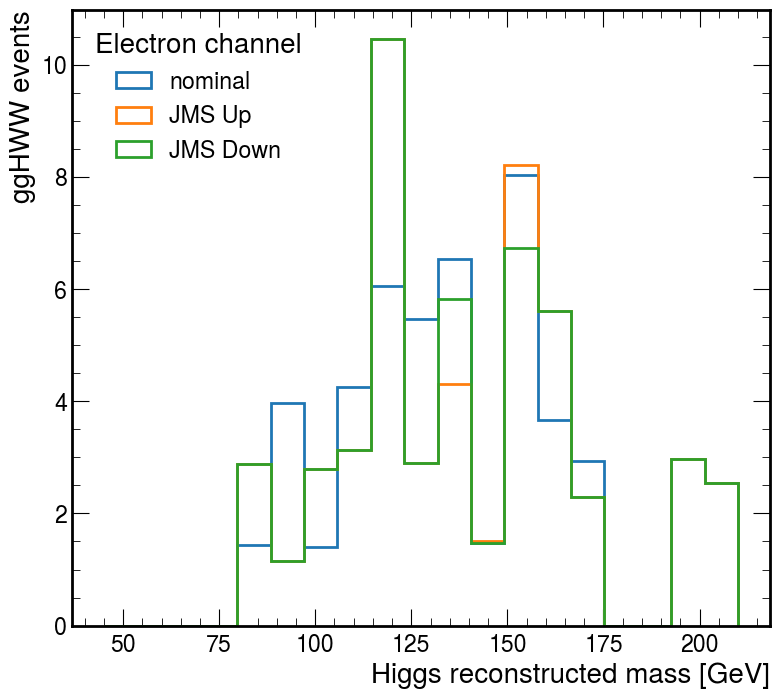

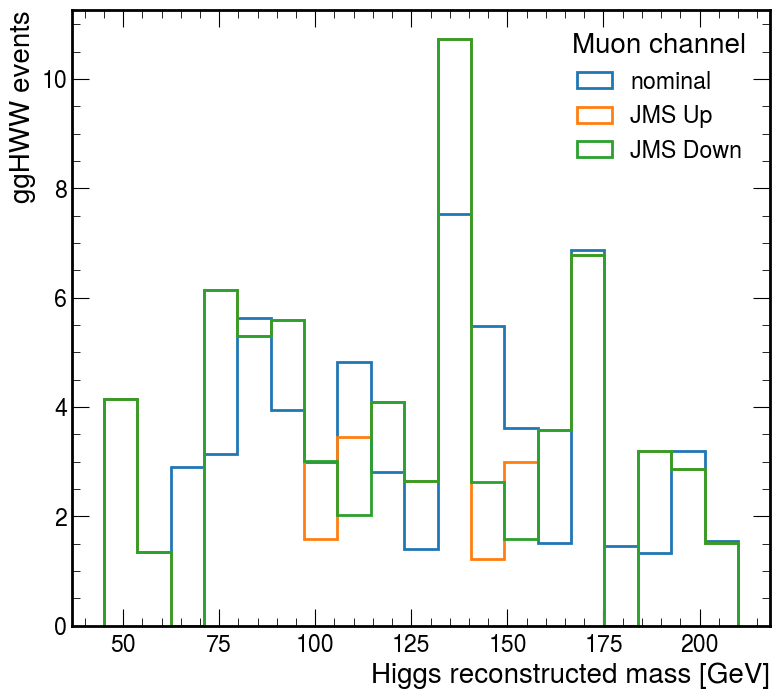

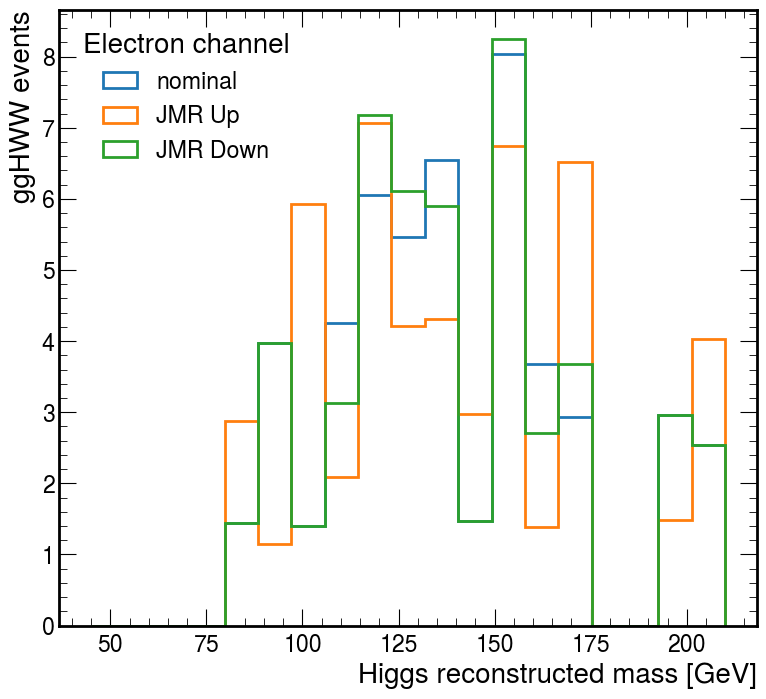

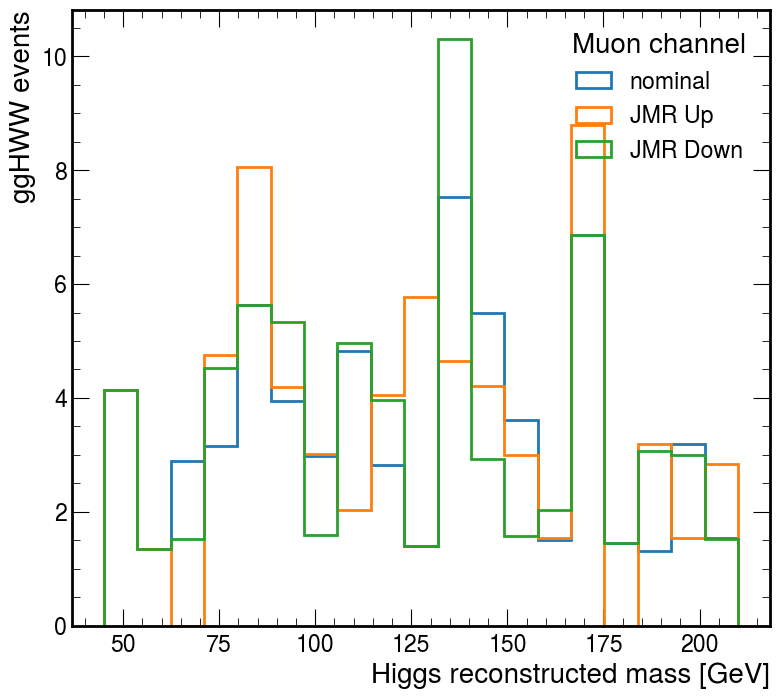

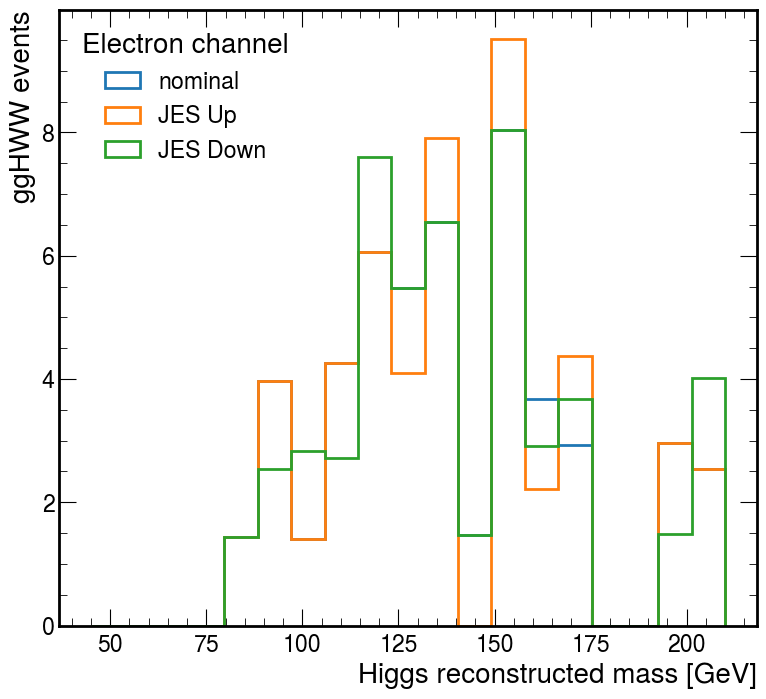

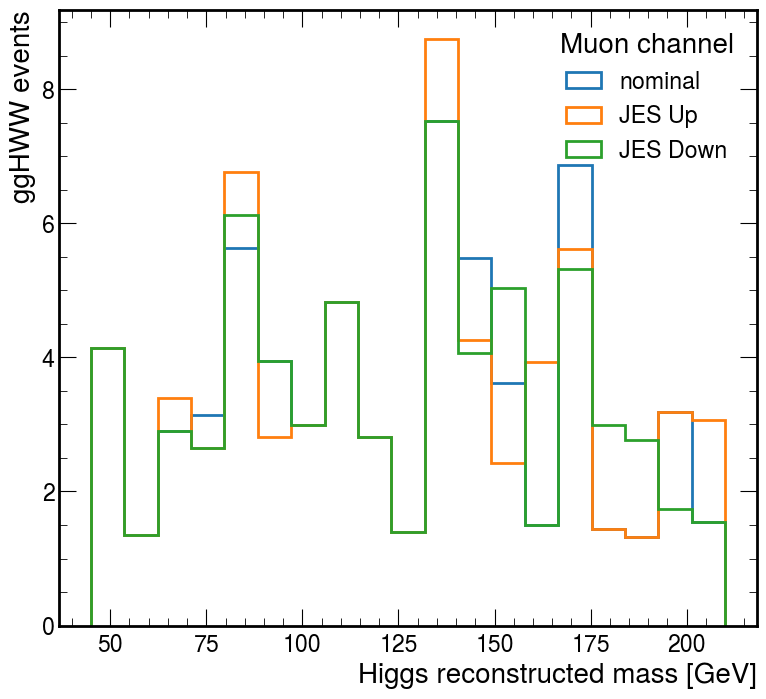

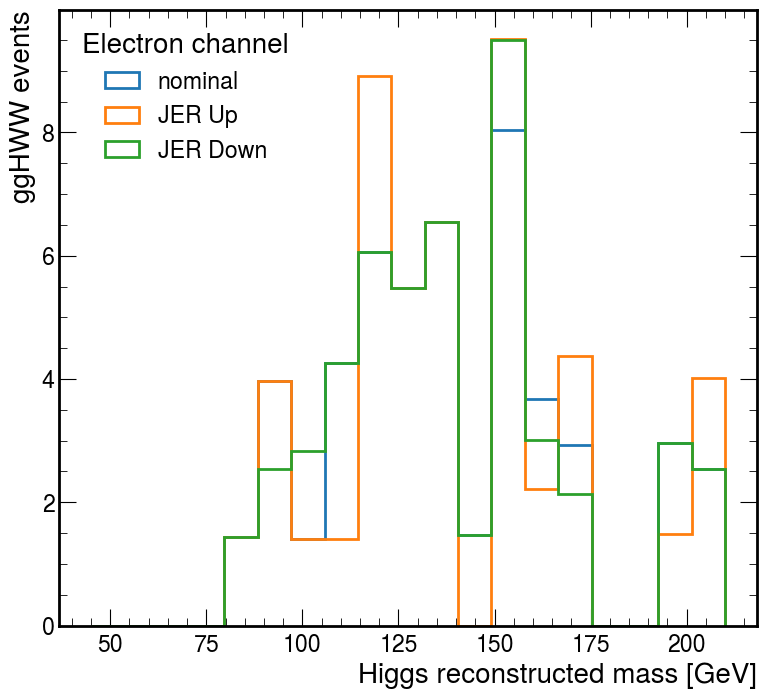

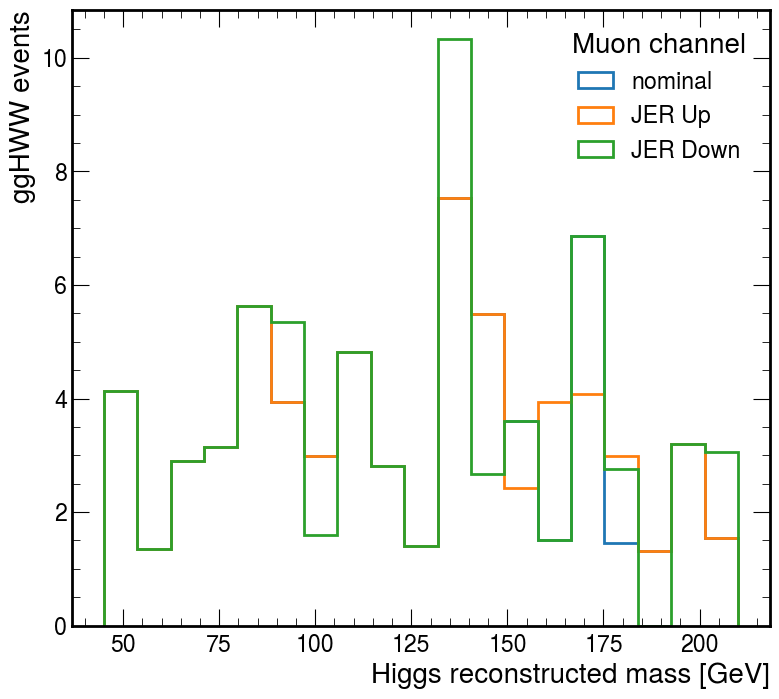

In [702]:
for syst in ["JMS", "JMR", "JES", "JER"]:
    for ch in ["ele", "mu"]:
        fig, ax = plt.subplots(figsize=(9,8))
        
        bins = np.linspace(45,210,20)

        ax.hist(df[ch]["rec_higgs_m"], label="nominal", weights=df[ch][f"weight_{ch}"],
                bins=bins, lw=2, histtype="step", 
               )
        ax.hist(df[ch][f"rec_higgs_m{syst}_up"], label=f"{syst} Up", weights=df[ch][f"weight_{ch}"],
                bins=bins, lw=2, histtype="step", 
               )
        ax.hist(df[ch][f"rec_higgs_m{syst}_down"], label=f"{syst} Down", weights=df[ch][f"weight_{ch}"],
                bins=bins, lw=2, histtype="step", 
               )

        ax.legend(title=f"{lab[ch]} channel")
        ax.set_xlabel("Higgs reconstructed mass [GeV]")
        ax.set_ylabel("ggHWW events")
#         plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/JMSR/weight_{ch}_{syst}.pdf")

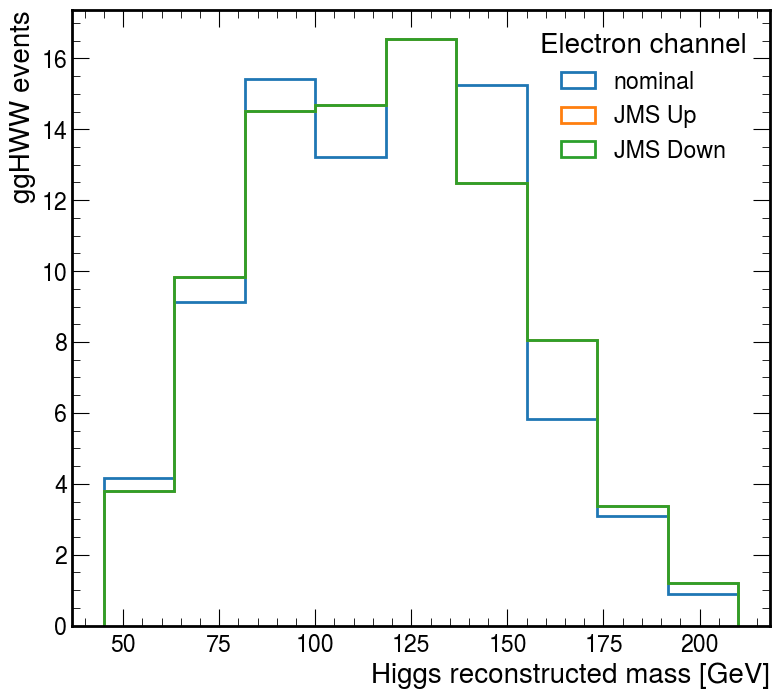

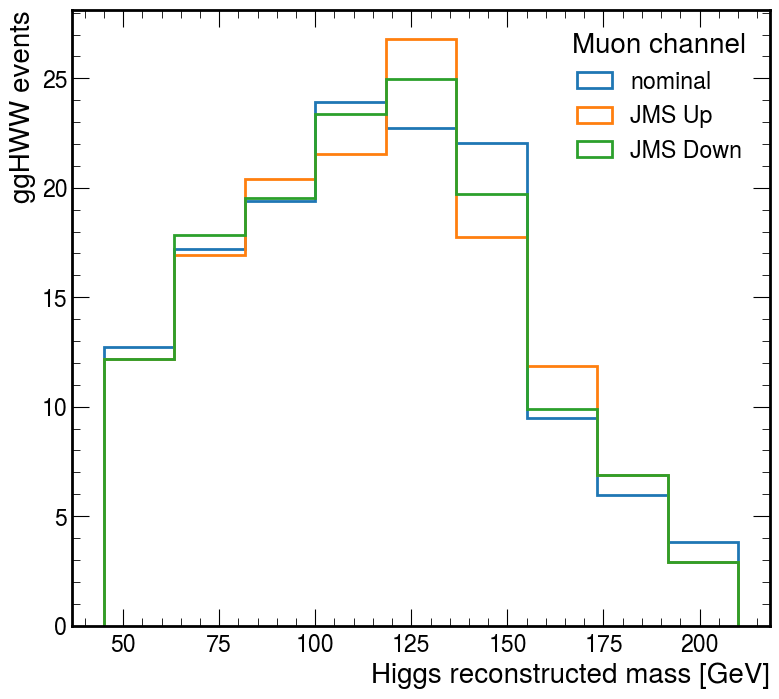

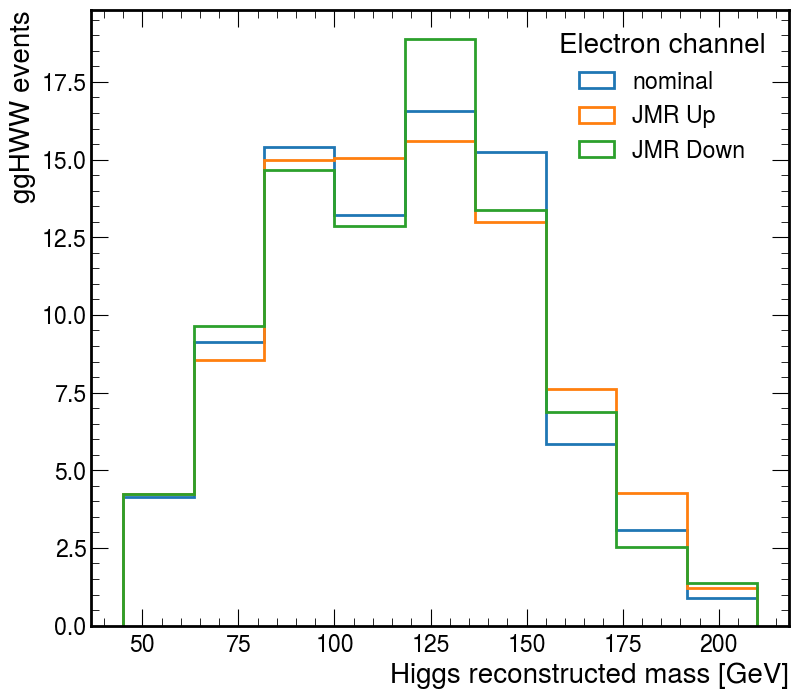

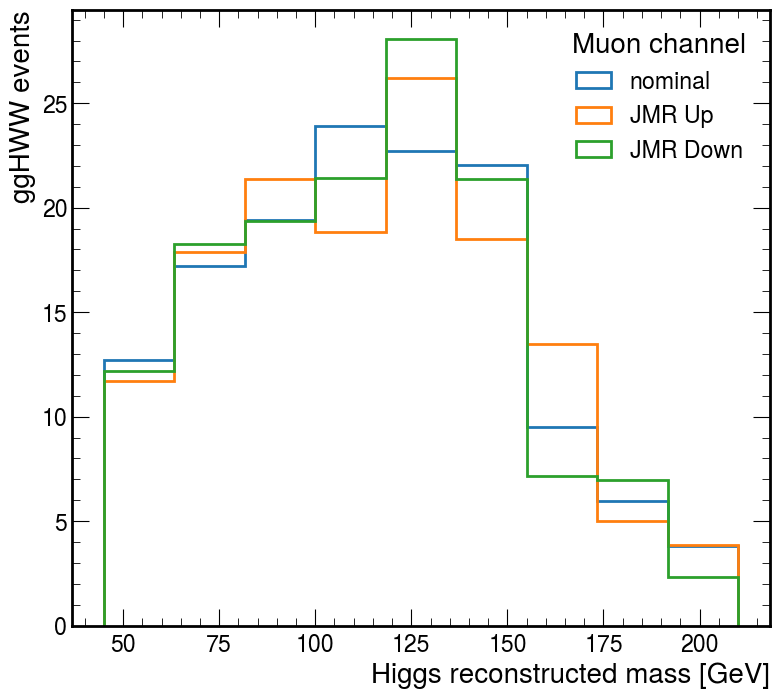

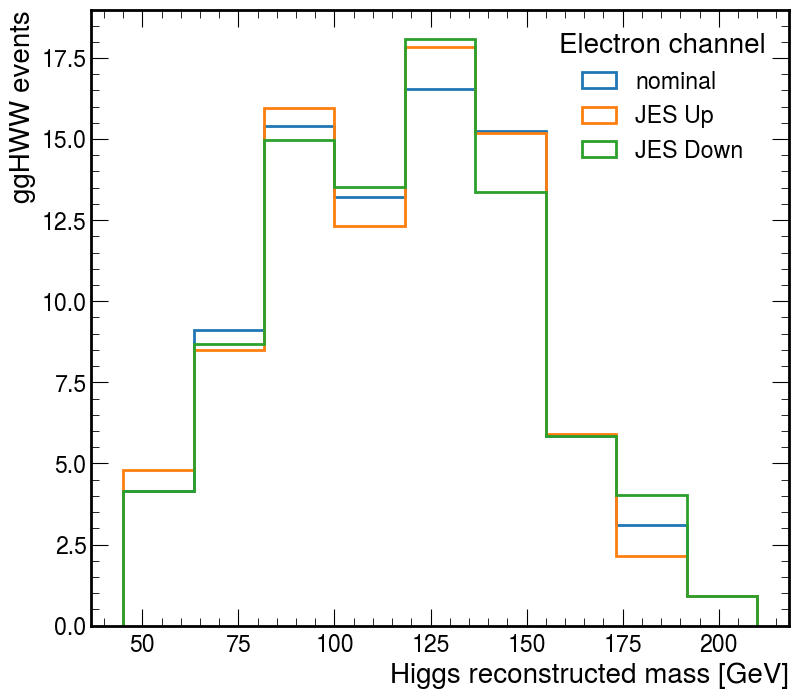

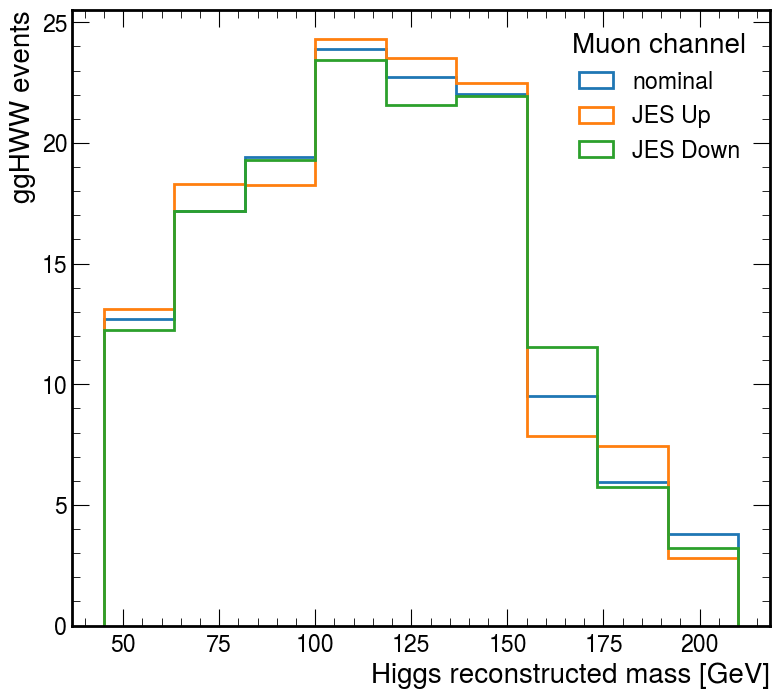

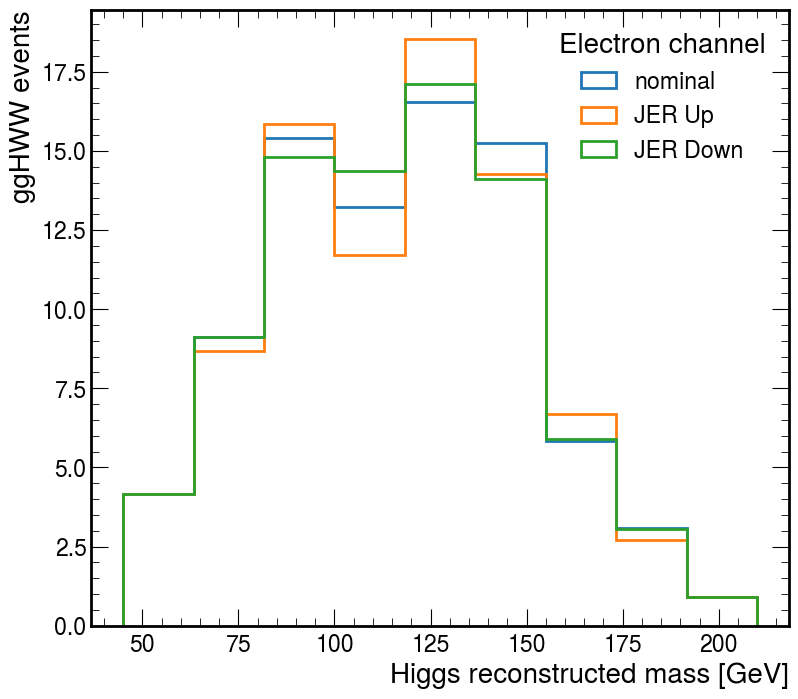

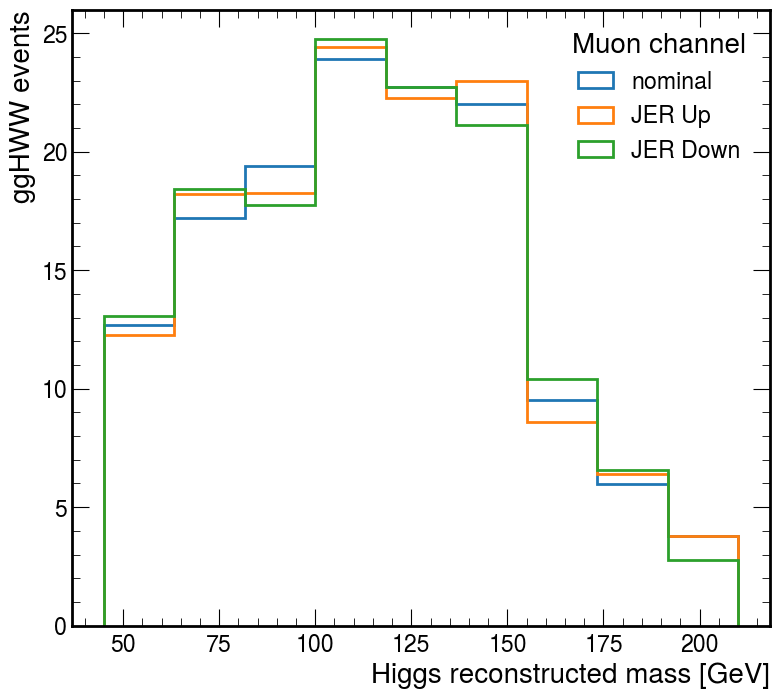

In [603]:
for syst in ["JMS", "JMR", "JES", "JER"]:
    for ch in ["ele", "mu"]:
        fig, ax = plt.subplots(figsize=(9,8))
        
        bins = np.linspace(45,210,10)

        ax.hist(df[ch]["rec_higgs_m"], label="nominal",
                bins=bins, lw=2, histtype="step", weights=df[ch][f"weight_{ch}"],
               )
        ax.hist(df[ch][f"rec_higgs_m{syst}_up"], label=f"{syst} Up",
                bins=bins, lw=2, histtype="step", weights=df[ch][f"weight_{ch}"],
               )
        ax.hist(df[ch][f"rec_higgs_m{syst}_down"], label=f"{syst} Down",
                bins=bins, lw=2, histtype="step", weights=df[ch][f"weight_{ch}"],
               )

        ax.legend(title=f"{lab[ch]} channel")
        ax.set_xlabel("Higgs reconstructed mass [GeV]")
        ax.set_ylabel("ggHWW events")
        plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/JMSR/weight_{ch}_{syst}.pdf")

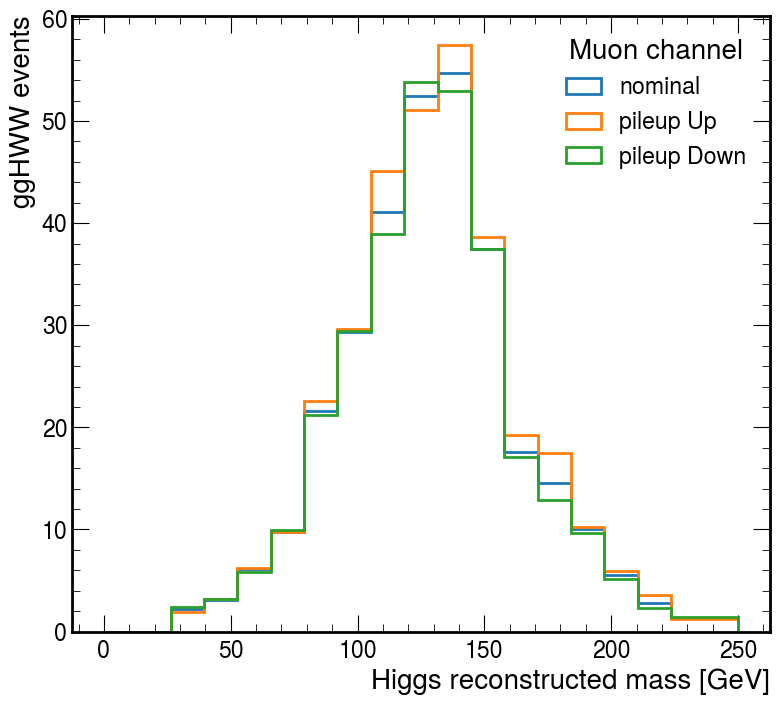

In [223]:
fig, ax = plt.subplots(figsize=(9,8))

syst = "UEPS_ISR"
syst = "pileup"

ch = "mu"

if ch == "ele":
#     df = df_ele
    lab = "Electron"
else:
#     df = df_mu
    lab = "Muon"

bins = np.linspace(0,250,20)
ax.hist(df["rec_higgs_m"], bins=bins, lw=2, histtype="step", weights=df["weight_ele"], label="nominal")
ax.hist(df["rec_higgs_m"], bins=bins, lw=2, histtype="step", weights=df[f"weight_ele_{syst}Up"], label=f"{syst} Up")
ax.hist(df["rec_higgs_m"], bins=bins, lw=2, histtype="step", weights=df[f"weight_ele_{syst}Down"], label=f"{syst} Down")

ax.legend(title=f"{lab} channel")
ax.set_xlabel("Higgs reconstructed mass [GeV]")
ax.set_ylabel("ggHWW events")
plt.savefig(f"outfiles/weight_{ch}_{syst}.pdf")

(array([1.000e+00, 2.000e+00, 0.000e+00, 4.720e+02, 1.416e+03, 6.030e+02,
        1.350e+02, 1.900e+01, 5.000e+00, 3.000e+00]),
 array([-0.76469591, -0.5003874 , -0.23607889,  0.02822962,  0.29253814,
         0.55684665,  0.82115516,  1.08546367,  1.34977218,  1.6140807 ,
         1.87838921]),
 <BarContainer object of 10 artists>)

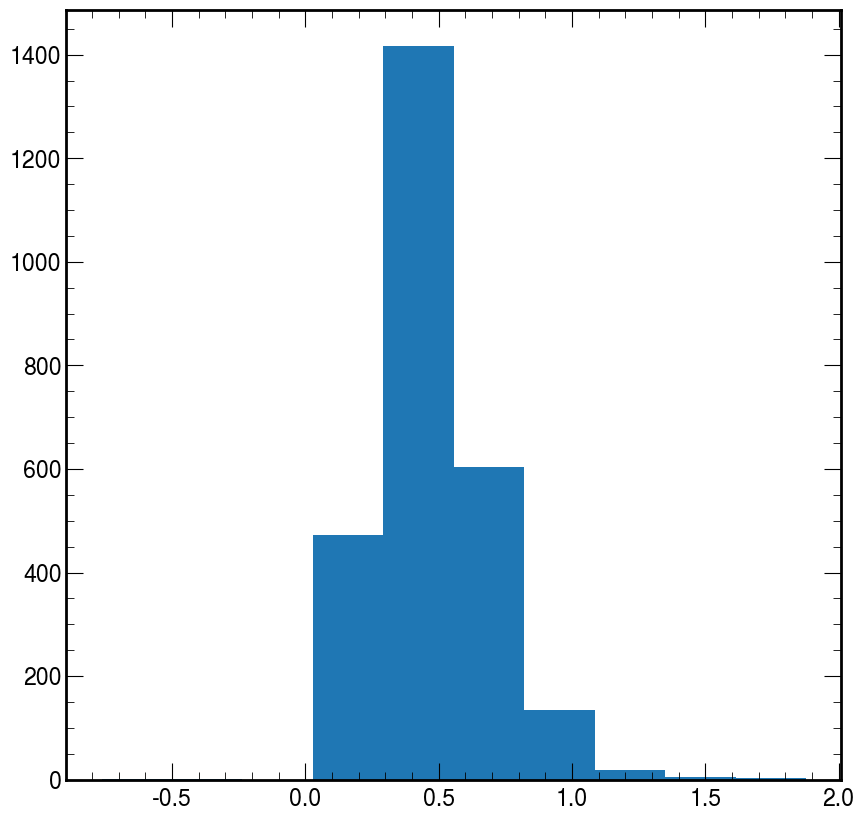

In [205]:
for key in df:
    print(key)

fj_msoftdrop
lep_pt
lep_isolation
lep_misolation
lep_fj_dr
lep_met_mt
met_fj_dphi
met_pt
deta
mjj
n_bjets_L
n_bjets_M
n_bjets_T
n_bjetsDeepCSV_L
n_bjetsDeepCSV_M
n_bjetsDeepCSV_T
fj_lsf3
fj_minus_lep_m
fj_pt
rec_higgs_m
fj_minus_lep_mJES_up
fj_ptJES_up
rec_higgs_mJES_up
fj_minus_lep_mJES_down
fj_ptJES_down
rec_higgs_mJES_down
fj_minus_lep_mJER_up
fj_ptJER_up
rec_higgs_mJER_up
fj_minus_lep_mJER_down
fj_ptJER_down
rec_higgs_mJER_down
fj_minus_lep_mUES_up
fj_ptUES_up
rec_higgs_mUES_up
fj_minus_lep_mUES_down
fj_ptUES_down
rec_higgs_mUES_down
fj_genH_pt
fj_genH_jet
fj_genV_dR
fj_genVstar
genV_genVstar_dR
fj_nquarks
fj_ncquarks
fj_lepinprongs
fj_H_VV_4q
fj_H_VV_elenuqq
fj_H_VV_munuqq
fj_H_VV_taunuqq
fj_H_VV_isVlepton
fj_H_VV_isVstarlepton
fj_H_VV_isMatched
gen_Vlep_pt
fj_genRes_mass
fj_genjetmass
fj_genjetpt
weight_mu
weight_mu_pileupUp
weight_mu_trigger_iso_muonUp
weight_mu_scalevar_3ptUp
weight_mu_trigger_noniso_muonUp
weight_mu_scalevar_3ptDown
weight_mu_aS_weightUp
weight_mu_PDFaS_weight

In [72]:
ev["2018"]["ele"]["TTbar"]["event_weight"].sum() + ev["2018"]["mu"]["TTbar"]["event_weight"].sum()

9482.113067850856

In [73]:
ev["2018"]["ele"]["WJetsLNu"]["event_weight"].sum() + ev["2018"]["mu"]["WJetsLNu"]["event_weight"].sum()

27511.822793005882

In [71]:
ev["2018"]["ele"]["QCD"]["event_weight"].sum()

4138.354757191497

In [58]:
! ls outfiles

0-1.pkl          0-1_mu.parquet   0-20_ele.parquet
0-1_ele.parquet  0-20.pkl         0-20_mu.parquet


In [26]:
import uproot
f = uproot.open("yes.root")

In [37]:
f["Events"]["FatJet_pt"].array()

<Array [[189], [], [235, ... [269], [233]] type='400 * var * float32'>

In [86]:
df_ele = pd.read_parquet("outfiles/0-10_ele.parquet")
df_mu = pd.read_parquet("outfiles/0-10_mu.parquet")

In [87]:
for key in df_ele:
    print(key)

lep_pt
lep_eta
lep_isolation
lep_misolation
lep_fj_dr
lep_met_mt
met_fj_dphi
met_pt
deta
mjj
ht
n_bjets_L
n_bjets_M
n_bjets_T
fj_lsf3
NumFatjets
NumOtherJets
FirstFatjet_pt
FirstFatjet_eta
FirstFatjet_phi
FirstFatjet_msd
SecondFatjet_pt
SecondFatjet_eta
SecondFatjet_phi
SecondFatjet_msd
fj_pt
fj_eta
fj_phi
fj_mass
fj_ptJES_up
fj_ptJES_down
fj_ptJER_up
fj_ptJER_down
rec_higgs_m
rec_higgs_pt
rec_W_qq_m
rec_W_qq_pt
rec_W_lnu_m
rec_W_lnu_pt
rec_higgs_etajet_m
rec_higgs_etajet_pt
rec_W_lnu_etajet_m
rec_W_lnu_etajet_pt
rec_higgs_mJES_up
rec_higgs_ptJES_up
rec_W_qq_mJES_up
rec_W_qq_ptJES_up
rec_W_lnu_mJES_up
rec_W_lnu_ptJES_up
rec_higgs_etajet_mJES_up
rec_higgs_etajet_ptJES_up
rec_W_lnu_etajet_mJES_up
rec_W_lnu_etajet_ptJES_up
rec_higgs_mJES_down
rec_higgs_ptJES_down
rec_W_qq_mJES_down
rec_W_qq_ptJES_down
rec_W_lnu_mJES_down
rec_W_lnu_ptJES_down
rec_higgs_etajet_mJES_down
rec_higgs_etajet_ptJES_down
rec_W_lnu_etajet_mJES_down
rec_W_lnu_etajet_ptJES_down
rec_higgs_mJER_up
rec_higgs_ptJER_up
re

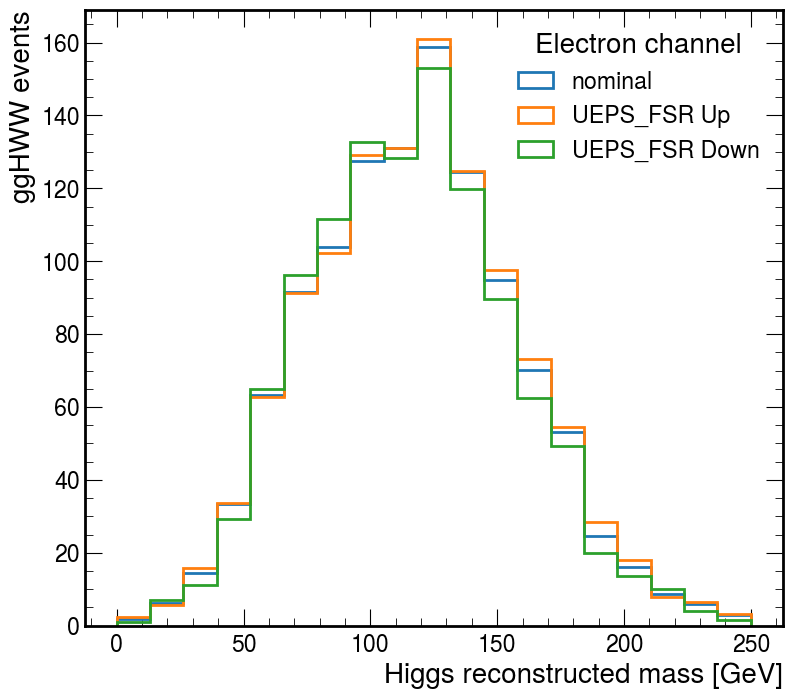

In [117]:
fig, ax = plt.subplots(figsize=(9,8))

syst = "UEPS_FSR"
ch = "ele"

if ch == "ele":
    df = df_ele
    lab = "Electron"
else:
    df = df_mu
    lab = "Muon"

bins = np.linspace(0,250,20)
ax.hist(df["rec_higgs_m"], bins=bins, lw=2, histtype="step", weights=df["weight_ele"], label="nominal")
ax.hist(df["rec_higgs_m"], bins=bins, lw=2, histtype="step", weights=df[f"weight_ele_{syst}Up"], label=f"{syst} Up")
ax.hist(df["rec_higgs_m"], bins=bins, lw=2, histtype="step", weights=df[f"weight_ele_{syst}Down"], label=f"{syst} Down")

ax.legend(title=f"{lab} channel")
ax.set_xlabel("Higgs reconstructed mass [GeV]")
ax.set_ylabel("ggHWW events")
plt.savefig(f"outfiles/weight_{ch}_{syst}.pdf")

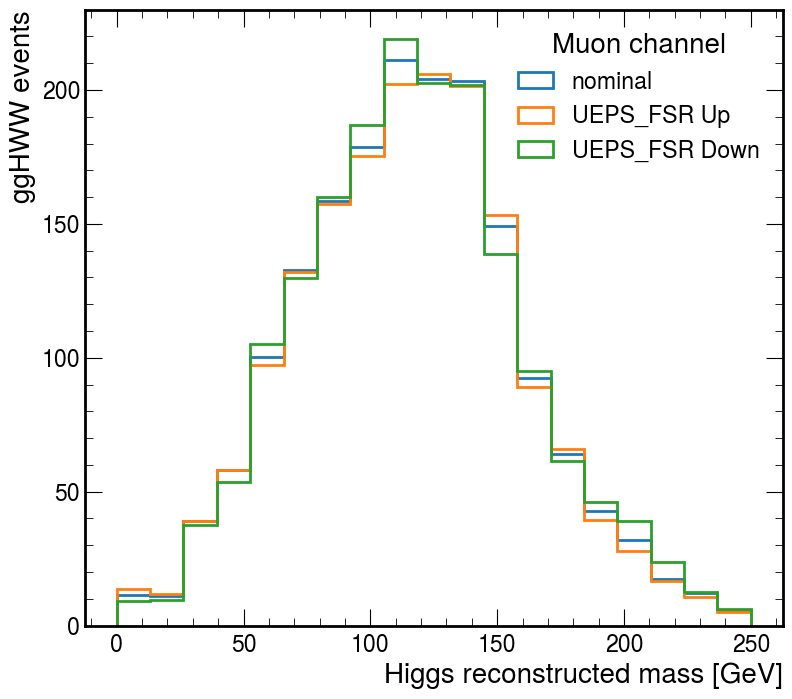

In [118]:
fig, ax = plt.subplots(figsize=(9,8))

syst = "UEPS_FSR"
ch = "mu"

if ch == "ele":
    df = df_ele
    lab = "Electron"
else:
    df = df_mu
    lab = "Muon"

bins = np.linspace(0,250,20)
ax.hist(df["rec_higgs_m"], bins=bins, lw=2, histtype="step", weights=df["weight_ele"], label="nominal")
ax.hist(df["rec_higgs_m"], bins=bins, lw=2, histtype="step", weights=df[f"weight_ele_{syst}Up"], label=f"{syst} Up")
ax.hist(df["rec_higgs_m"], bins=bins, lw=2, histtype="step", weights=df[f"weight_ele_{syst}Down"], label=f"{syst} Down")

ax.legend(title=f"{lab} channel")
ax.set_xlabel("Higgs reconstructed mass [GeV]")
ax.set_ylabel("ggHWW events")
plt.savefig(f"outfiles/weight_{ch}_{syst}.pdf")

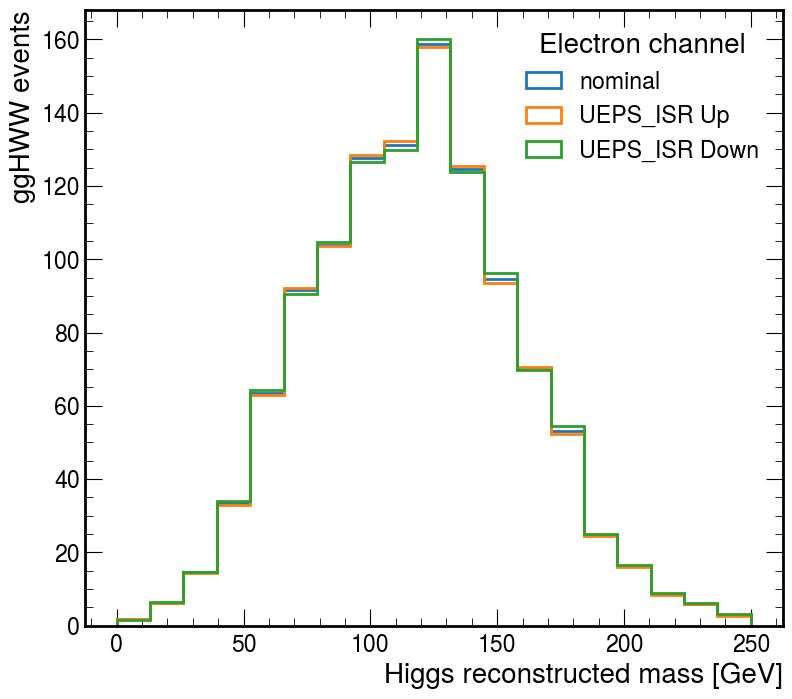

In [119]:
fig, ax = plt.subplots(figsize=(9,8))

syst = "UEPS_ISR"
ch = "ele"

if ch == "ele":
    df = df_ele
    lab = "Electron"
else:
    df = df_mu
    lab = "Muon"

bins = np.linspace(0,250,20)
ax.hist(df["rec_higgs_m"], bins=bins, lw=2, histtype="step", weights=df["weight_ele"], label="nominal")
ax.hist(df["rec_higgs_m"], bins=bins, lw=2, histtype="step", weights=df[f"weight_ele_{syst}Up"], label=f"{syst} Up")
ax.hist(df["rec_higgs_m"], bins=bins, lw=2, histtype="step", weights=df[f"weight_ele_{syst}Down"], label=f"{syst} Down")

ax.legend(title=f"{lab} channel")
ax.set_xlabel("Higgs reconstructed mass [GeV]")
ax.set_ylabel("ggHWW events")
plt.savefig(f"outfiles/weight_{ch}_{syst}.pdf")

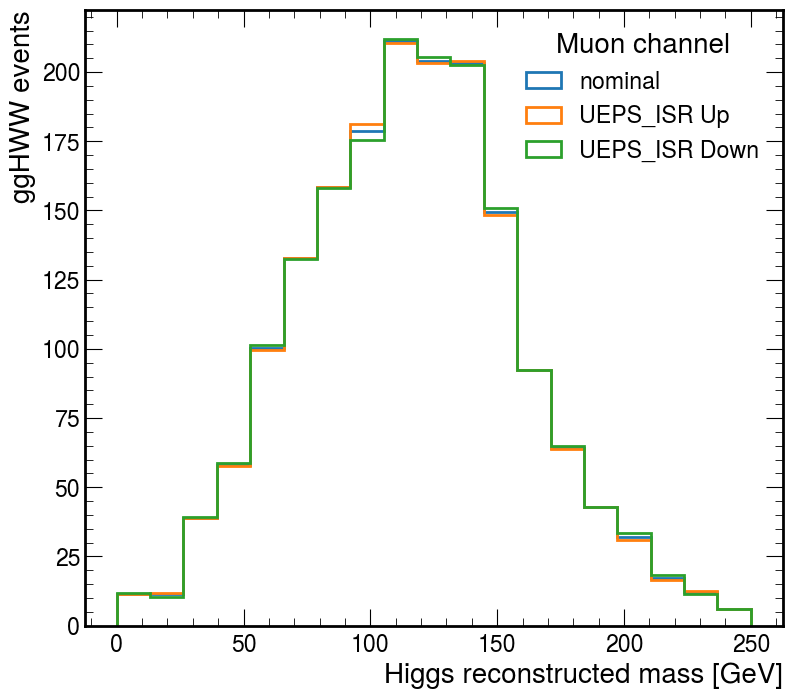

In [120]:
fig, ax = plt.subplots(figsize=(9,8))

syst = "UEPS_ISR"
ch = "mu"

if ch == "ele":
    df = df_ele
    lab = "Electron"
else:
    df = df_mu
    lab = "Muon"

bins = np.linspace(0,250,20)
ax.hist(df["rec_higgs_m"], bins=bins, lw=2, histtype="step", weights=df["weight_ele"], label="nominal")
ax.hist(df["rec_higgs_m"], bins=bins, lw=2, histtype="step", weights=df[f"weight_ele_{syst}Up"], label=f"{syst} Up")
ax.hist(df["rec_higgs_m"], bins=bins, lw=2, histtype="step", weights=df[f"weight_ele_{syst}Down"], label=f"{syst} Down")

ax.legend(title=f"{lab} channel")
ax.set_xlabel("Higgs reconstructed mass [GeV]")
ax.set_ylabel("ggHWW events")
plt.savefig(f"outfiles/weight_{ch}_{syst}.pdf")

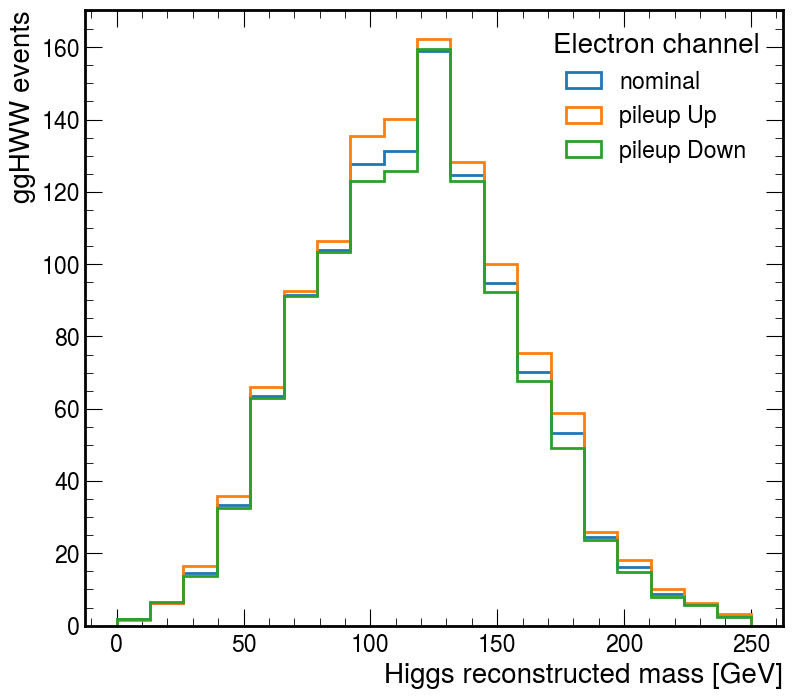

In [224]:
fig, ax = plt.subplots(figsize=(9,8))

syst = "pileup"
ch = "ele"

if ch == "ele":
    df = df_ele
    lab = "Electron"
else:
    df = df_mu
    lab = "Muon"

bins = np.linspace(0,250,20)
ax.hist(df["rec_higgs_m"], bins=bins, lw=2, histtype="step", weights=df["weight_ele"], label="nominal")
ax.hist(df["rec_higgs_m"], bins=bins, lw=2, histtype="step", weights=df[f"weight_ele_{syst}Up"], label=f"{syst} Up")
ax.hist(df["rec_higgs_m"], bins=bins, lw=2, histtype="step", weights=df[f"weight_ele_{syst}Down"], label=f"{syst} Down")

ax.legend(title=f"{lab} channel")
ax.set_xlabel("Higgs reconstructed mass [GeV]")
ax.set_ylabel("ggHWW events")
plt.savefig(f"outfiles/weight_{ch}_{syst}.pdf")

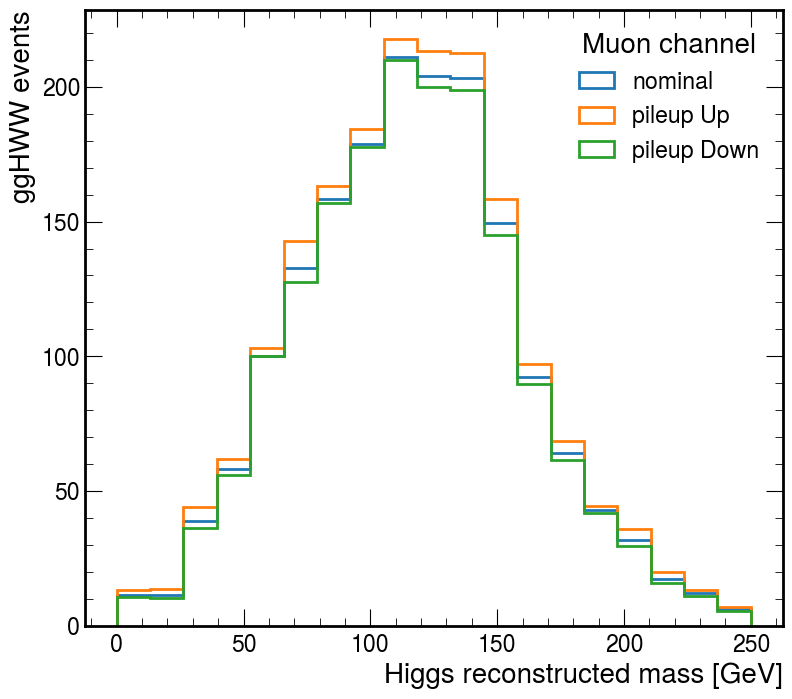

In [225]:
fig, ax = plt.subplots(figsize=(9,8))

syst = "pileup"
ch = "mu"

if ch == "ele":
    df = df_ele
    lab = "Electron"
else:
    df = df_mu
    lab = "Muon"

bins = np.linspace(0,250,20)
ax.hist(df["rec_higgs_m"], bins=bins, lw=2, histtype="step", weights=df["weight_ele"], label="nominal")
ax.hist(df["rec_higgs_m"], bins=bins, lw=2, histtype="step", weights=df[f"weight_ele_{syst}Up"], label=f"{syst} Up")
ax.hist(df["rec_higgs_m"], bins=bins, lw=2, histtype="step", weights=df[f"weight_ele_{syst}Down"], label=f"{syst} Down")

ax.legend(title=f"{lab} channel")
ax.set_xlabel("Higgs reconstructed mass [GeV]")
ax.set_ylabel("ggHWW events")
plt.savefig(f"outfiles/weight_{ch}_{syst}.pdf")

In [1075]:
((df["lep_isolation"]==0) & (df["lep_pt"]<55)).sum()

283

In [475]:
make_composition_table(events_dict["new_corrections"], presel)

\begin{table}[!ht]
\begin{center}
\caption{Event yield contribution from different processes in the search regions for the full Run2 dataset.}
\begin{tabular}{c|cccc|cccc}
& \multicolumn{4}{c|}{Signal yield} & \multicolumn{4}{c}{Background yield} \\

& ttH & VBF & VH  & ggF & \ttbar & W$+$jets & QCD & Other \\

\hline
\hline
\multirow{2}{*}{Pre-selection} & \multicolumn{4}{c|}{157} & \multicolumn{4}{c}{41393} \\
 & 11\% & 16\% & 18\% & 55\% & 23\% & 58\% & 19\% & 8\% \\

\hline
\hline
\end{tabular}
\label{region}
\end{center}
\end{table}


In [665]:
tagger = "fj_ParT_score"
tagger = "fj_ParT_score_finetuned"

presel = {    
#     "Pre-selection + jetpt>200": f"{tagger}>0.5",    
#     "Pre-selection + jetpt>250": f"{tagger}>0.5 & fj_pt>250",  
#     "Pre-selection + jetpt>300": f"{tagger}>0.5 & fj_pt>300",
        
#     "SR1": f"({tagger}>0.98) & (n_bjets_T==0)",
#     "SR2": f"({tagger}<0.98) & ({tagger}>0.97) & (n_bjets_T==0)",
#     "WJets CR": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0)",
    
#     "WJets CR + jetpt>200": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>200",   
#     "WJets CR + jetpt>250": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>250", 
#     "WJets CR + jetpt>300": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>300", 
      
#     "WJets CR + jetpt>200 + MET>X": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>200", 
#     "WJets CR + jetpt>250 + MET>X": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>250", 
#     "WJets CR + jetpt>300 + MET>X": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>300", 
    
#     "Top CR": f"({tagger}>0.50) & (n_bjets_T>=0)",
}

channels = ["ele", "mu"]
# channels = ["mu"]
years = ["2018", "2017", "2016", "2016APV"]

# fill histograms
var = "met_pt"

# samples = ["ggF", "VBF", "VH", "ttH"]
samples = ["QCD"]
# samples = ["WJetsLNu", "QCD"]
# samples = ["WJetsLNu"]
# samples = ["WJetsLNu", "DYJets"]

# samples = ["TTbar"]
# samples = ["WJetsLNu", "QCD", "TTbar"]


h = hist2.Hist(
#     hist2.axis.StrCategory([], name="corr", growth=True),
    hist2.axis.StrCategory([], name="region", growth=True),    
#     hist2.axis.Variable(list(range(50, 240, 10)), name="var", label=r"Higgs reconstructed mass [GeV]", overflow=True)
#     hist2.axis.Variable(list(range(200, 800, 30)), name="var", label=r"Jet $p_T$ [GeV]", overflow=True)

#     hist2.axis.Variable(list(range(200, 800, 30)), name="var", label=r"Jet $p_T$ [GeV]", overflow=True)
     hist2.axis.Regular(30, 0, 250, name="var", label=r"MET", overflow=True),
)
ev = events_dict["new_corrections200"]

num, den = 0, 0
threshold = 0
for region, sel in presel.items():

    for year in years:
        for ch in channels:   
            for sample in samples:

                df = ev[year][ch][sample]

                df = df.query(sel)    

                if "MET>X" in region:
                    if ch=="ele":
                        df = df[df["met_pt"]>70]
                    else:
                        df = df[df["met_pt"]>50]
                        
#                 if (sample == "QCD") and ("SR" in region):
#                     threshold = 10
#                     den += len(df['event_weight'])
#                     num += sum(df["event_weight"]>threshold)

#                     df = df[df["event_weight"] < threshold]
                    
                h.fill(
                    region=region,
                    var=df[var],
                    weight=df["event_weight"],
                )   


try:
    print(f"Removing {num} out of {den} qcd events by applying qcd event_weight<{threshold} ({(100*num/den):.2f}%)")
except:
    z=1                

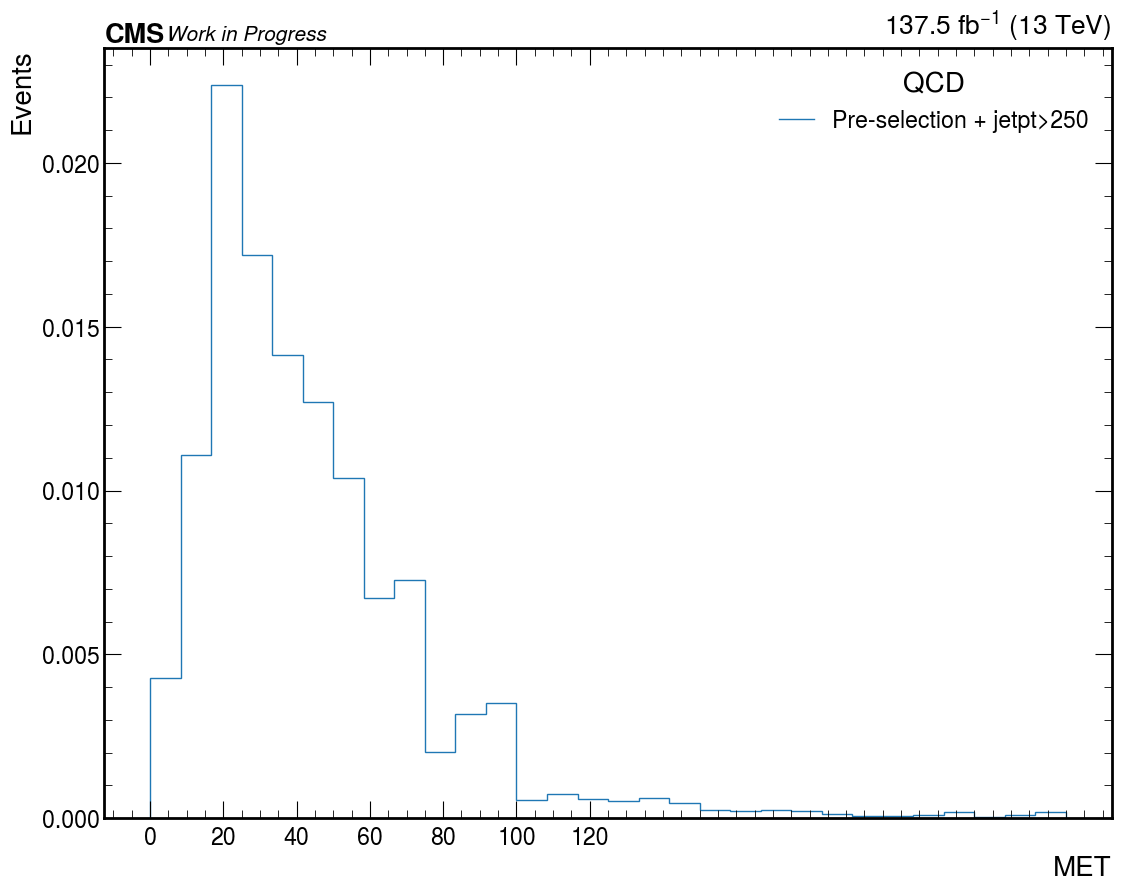

In [541]:
# different regions
fig, ax = plt.subplots(figsize=(13, 10))

for region in presel:
    
    bkg = h[{"region": region}].project("var")    
    
    hep.histplot(
        bkg,
        ax=ax,
        density=True,
        linewidth=1,
        label=region,
        flow="none",
#         color=color_region[region]
    )
    
ax.set_xlabel(bkg.axes.label[0])
ax.legend(title=" + ".join(sample for sample in samples), loc="upper right")
ax.set_ylabel("Events")
# ax.set_ylim(0, 0.015)
# ax.set_yscale("log")

ax.set_xticks([0,20,40,60,80,100,120])

lum_=0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/AN/z.pdf")     

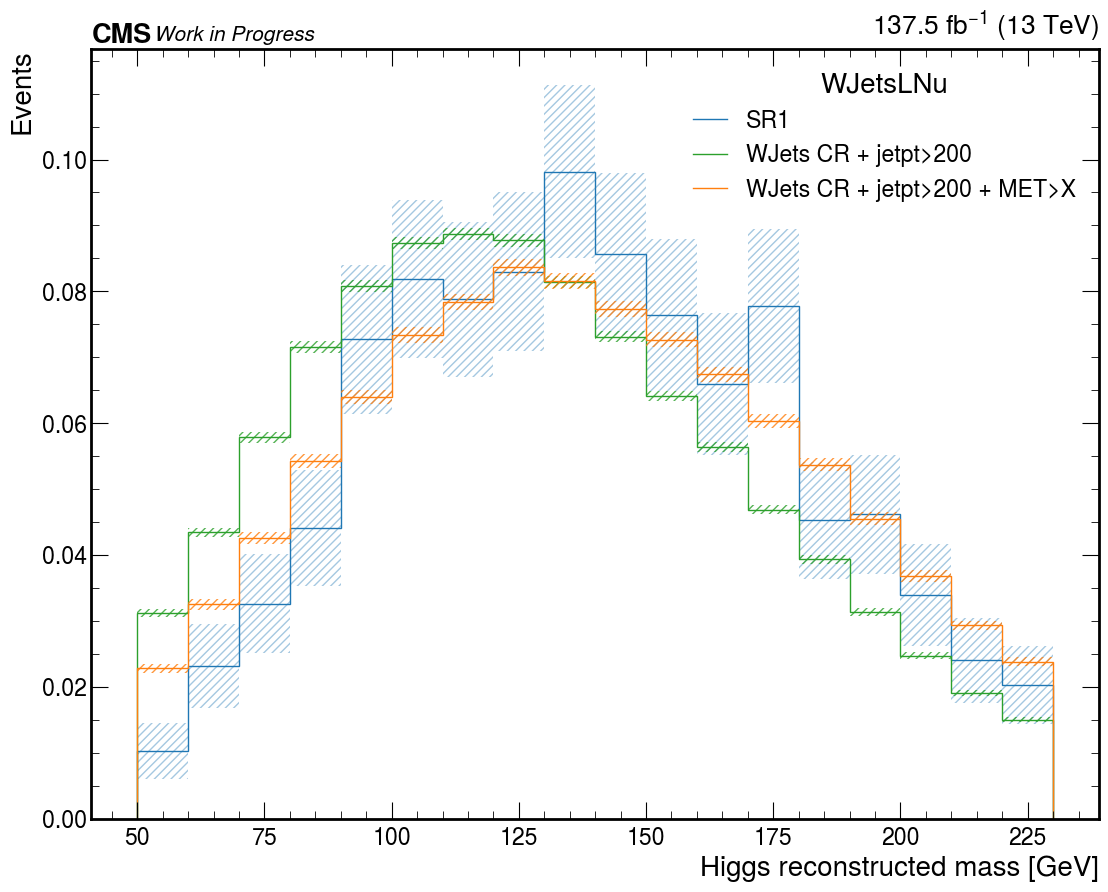

In [243]:
# different regions
fig, ax = plt.subplots(figsize=(13, 10))
color_region = {
    "SR1": "tab:blue",
    "SR2": "tab:orange",
    "WJets CR": "tab:green",
    "Top CR": "tab:green", 
    
    "WJets CR + jetpt>200": "tab:green",
    "WJets CR + jetpt>250": "tab:orange",
    "WJets CR + jetpt>300": "tab:blue",
    
    "WJets CR + jetpt>200 + MET>X": "tab:orange",
    "WJets CR + jetpt>250 + MET>X": "tab:green",
    "WJets CR + jetpt>300 + MET>X": "tab:red",

}

errps = {
    "SR1": {
        "hatch": "////",
        "facecolor": "none",
        "lw": 0,
        "color": color_region["SR1"],
#         "edgecolor": (0, 0, 0, 0.5),
        "linewidth": 0,
        "alpha": 0.4,
    },
    "SR2": {
        "hatch": "////",
        "facecolor": "none",
        "lw": 0,
        "color": color_region["SR2"],
#         "edgecolor": (0, 0, 0, 0.5),
        "linewidth": 0,
        "alpha": 0.4,
    },
    "WJets CR": {
        "hatch": "////",
        "facecolor": "none",
        "lw": 0,
        "color": color_region["WJets CR"],
#         "edgecolor": (0, 0, 0, 0.5),
        "linewidth": 0,
        "alpha": 0.8,
    },   
    "Top CR": {
        "hatch": "////",
        "facecolor": "none",
        "lw": 0,
        "color": color_region["WJets CR"],
#         "edgecolor": (0, 0, 0, 0.5),
        "linewidth": 0,
        "alpha": 0.8,
    },  
    "WJets CR + jetpt>200": {
        "hatch": "////",
        "facecolor": "none",
        "lw": 0,
        "color": color_region["WJets CR + jetpt>200"],
#         "edgecolor": (0, 0, 0, 0.5),
        "linewidth": 0,
        "alpha": 0.8,
    },
    "WJets CR + jetpt>250": {
        "hatch": "////",
        "facecolor": "none",
        "lw": 0,
        "color": color_region["WJets CR + jetpt>250"],
#         "edgecolor": (0, 0, 0, 0.5),
        "linewidth": 0,
        "alpha": 0.8,
    },
    "WJets CR + jetpt>300": {
        "hatch": "////",
        "facecolor": "none",
        "lw": 0,
        "color": color_region["WJets CR + jetpt>300"],
#         "edgecolor": (0, 0, 0, 0.5),
        "linewidth": 0,
        "alpha": 0.8,
    },   
    "WJets CR + jetpt>200 + MET>X": {
        "hatch": "////",
        "facecolor": "none",
        "lw": 0,
        "color": color_region["WJets CR + jetpt>200 + MET>X"],
#         "edgecolor": (0, 0, 0, 0.5),
        "linewidth": 0,
        "alpha": 0.8,
    },       
    
    "WJets CR + jetpt>250 + MET>X": {
        "hatch": "////",
        "facecolor": "none",
        "lw": 0,
        "color": color_region["WJets CR + jetpt>250 + MET>X"],
#         "edgecolor": (0, 0, 0, 0.5),
        "linewidth": 0,
        "alpha": 0.8,
    },       
    
    "WJets CR + jetpt>300 + MET>X": {
        "hatch": "////",
        "facecolor": "none",
        "lw": 0,
        "color": color_region["WJets CR + jetpt>300 + MET>X"],
#         "edgecolor": (0, 0, 0, 0.5),
        "linewidth": 0,
        "alpha": 0.8,
    },       
        
    
}

if False:
    bkg = h[{"region": ["SR1", "SR2"]}].project("var")
    bkg2 = bkg.values()/bkg.values().sum()
    hep.histplot(
    #         bkg,
        bkg2,
        bins=bkg.axes[0].edges,        
        ax=ax,
    #         density=True,
        linewidth=1,
        label="Signal Region (SR1+SR2)",
        flow="none",
    )

    ax.stairs(
        values=(bkg + np.sqrt(bkg))/bkg.values().sum(),
        baseline=(bkg - np.sqrt(bkg))/bkg.values().sum(),
        edges=bkg.axes[0].edges,
        **errps["SR1"],        
        label="Stat. unc.",
    )    
    
for region in presel:
    if "SR2" in region:
        continue

    bkg = h[{"region": region}].project("var")    
    
    bkg2 = bkg.values()/bkg.values().sum()
    hep.histplot(
#         bkg,
        bkg2,
        bins=bkg.axes[0].edges,        
        ax=ax,
#         density=True,
        linewidth=1,
        label=region,
        flow="none",
        color=color_region[region]
    )
    
    ax.stairs(
        values=(bkg + np.sqrt(bkg))/bkg.values().sum(),
        baseline=(bkg - np.sqrt(bkg))/bkg.values().sum(),
        edges=bkg.axes[0].edges,
        **errps[region],        
#         label="Stat. unc.",
    )
    


ax.set_xlabel(bkg.axes.label[0])
ax.legend(title=" + ".join(sample for sample in samples), loc="upper right")
ax.set_ylabel("Events")
# ax.set_ylim(0, 0.015)
# ax.set_yscale("log")

lum_=0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/AN/z.pdf")     

In [550]:
tagger = "fj_ParT_score"
tagger = "fj_ParT_score_finetuned"

presel = {    
    
    
#     "Pre-selection + jetpt>200": f"{tagger}>0.5",    
    "Pre-selection + jetpt>250": f"{tagger}>0.5 & fj_pt>250",  
#     "Pre-selection + jetpt>300": f"{tagger}>0.5 & fj_pt>300",
        
    
#     "SR1": f"({tagger}>0.98) & (n_bjets_T==0)",
#     "SR2": f"({tagger}<0.98) & ({tagger}>0.97) & (n_bjets_T==0)",
#     "WJets CR": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0)",
    
#     "WJets CR + jetpt>200": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>200",   
#     "WJets CR + jetpt>250": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>250", 
#     "WJets CR + jetpt>300": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>300", 
      
#     "WJets CR + jetpt>200 + MET>X": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>200", 
#     "WJets CR + jetpt>250 + MET>X": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>250", 
#     "WJets CR + jetpt>300 + MET>X": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>300", 
    
#     "Top CR": f"({tagger}>0.50) & (n_bjets_T>=0)",      
    

}

channels = ["ele", "mu"]
channels = ["ele"]
years = ["2018", "2017", "2016", "2016APV"]

# fill histograms
var = "met_pt"

# samples = ["ggF", "VBF", "VH", "ttH"]
samples = ["ggF", "QCD"]
# samples = ["WJetsLNu", "DYJets"]

# samples = ["WJetsLNu"]
# samples = ["TTbar"]

h = hist2.Hist(
    hist2.axis.StrCategory([], name="samples", growth=True),        
    hist2.axis.StrCategory([], name="region", growth=True),    
#     hist2.axis.Variable(list(range(50, 240, 10)), name="var", label=r"Higgs reconstructed mass [GeV]", overflow=True)
    hist2.axis.Regular(30, 0, 250, name="var", label=r"MET", overflow=True),
    
)
ev = events_dict["new_corrections"]

num, den = 0, 0
threshold = 0
for region, sel in presel.items():

    for year in years:
        for ch in channels:   
            for sample in samples:

                df = ev[year][ch][sample]

                df = df.query(sel)    

#                 if (sample == "DYJets"):
#                     threshold = 50
#                     den += len(df['event_weight'])
#                     num += sum(df["event_weight"]>threshold)

#                     df = df[df["event_weight"] < threshold]
                    
                h.fill(
                    samples=sample,
                    region=region,
                    var=df[var],
                    weight=df["event_weight"],
                )     
try:
    print(f"Removing {num} out of {den} DYJets events by applying event_weight<{threshold} ({(100*num/den):.2f}%)")
except:
    z=1                             

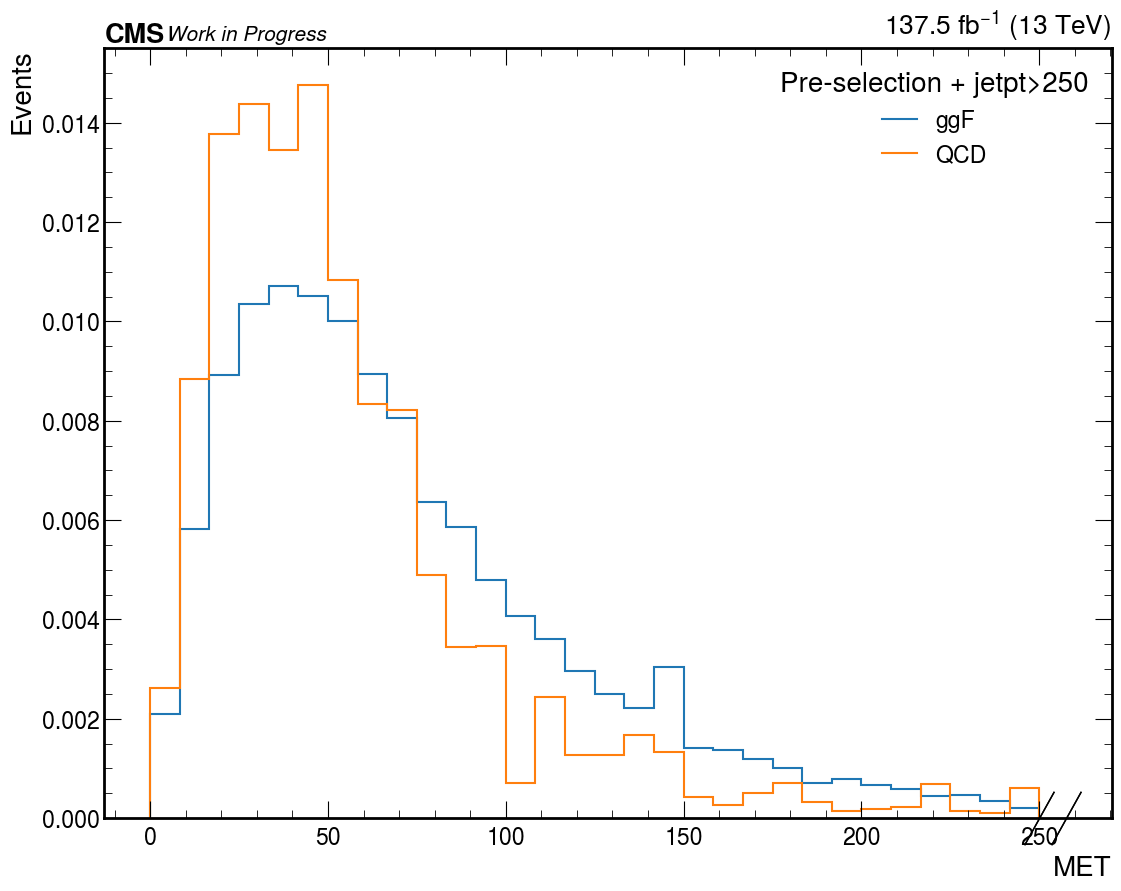

In [553]:
region = "Pre-selection + jetpt>250"
# region = "SR1"

# different regions
fig, ax = plt.subplots(figsize=(13, 10))
for sample in samples:
    hep.histplot(h[{"region": region, "samples": sample}].project("var"),
        label=sample,
        density=True,
#         yerr=True,
    )
ax.legend(title=region, loc="upper right")
ax.set_ylabel("Events")
ax.set_ylim(0)
# ax.set_yscale("log")

lum_=0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/AN/z.pdf")     

In [655]:
tagger = "fj_ParT_score"
tagger = "fj_ParT_score_finetuned"

presel = {    
    
    
    "Pre-selection + jetpt>200": f"{tagger}>0.5",    
    "Pre-selection + jetpt>250": f"{tagger}>0.5 & fj_pt>250",  
    "Pre-selection + jetpt>300": f"{tagger}>0.5 & fj_pt>300",
        
    
#     "SR1": f"({tagger}>0.98) & (n_bjets_T==0)",
#     "SR2": f"({tagger}<0.98) & ({tagger}>0.97) & (n_bjets_T==0)",
#     "WJets CR": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0)",
    
#     "WJets CR + jetpt>200": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>200",   
#     "WJets CR + jetpt>250": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>250", 
#     "WJets CR + jetpt>300": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>300", 
      
#     "WJets CR + jetpt>200 + MET>X": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>200", 
#     "WJets CR + jetpt>250 + MET>X": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>250", 
#     "WJets CR + jetpt>300 + MET>X": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>300", 
    
#     "Top CR": f"({tagger}>0.50) & (n_bjets_T>=0)",      
    

}


years = ["2018", "2017", "2016", "2016APV"]

# fill histograms
var = "met_pt"

samples = ["ggF", "VBF", "VH", "ttH"]
# samples = ["QCD"]
# samples = ["WJetsLNu"]
# samples = ["TTbar"]

h = hist2.Hist(
    hist2.axis.StrCategory([], name="channels", growth=True),        
    hist2.axis.StrCategory([], name="region", growth=True),    
#     hist2.axis.Variable(list(range(50, 240, 10)), name="var", label=r"Higgs reconstructed mass [GeV]", overflow=True)
    hist2.axis.Regular(30, 0, 250, name="var", label=r"MET", overflow=True),
    
)
ev = events_dict["new_corrections200"]
channels = ["ele", "mu"]

num, den = 0, 0
threshold = 0
for region, sel in presel.items():

    for year in years:
        for ch in channels:   
            for sample in samples:

                df = ev[year][ch][sample]

                df = df.query(sel)    

#                 if (sample == "QCD"):
#                     threshold = 200
#                     den += len(df['event_weight'])
#                     num += sum(df["event_weight"]>threshold)

#                     df = df[df["event_weight"] < threshold]
                    
                h.fill(
                    channels=ch,
                    region=region,
                    var=df[var],
                    weight=df["event_weight"],
                )     
try:
    print(f"Removing {num} out of {den} qcd events by applying event_weight<{threshold} ({(100*num/den):.2f}%)")
except:
    z=1                             

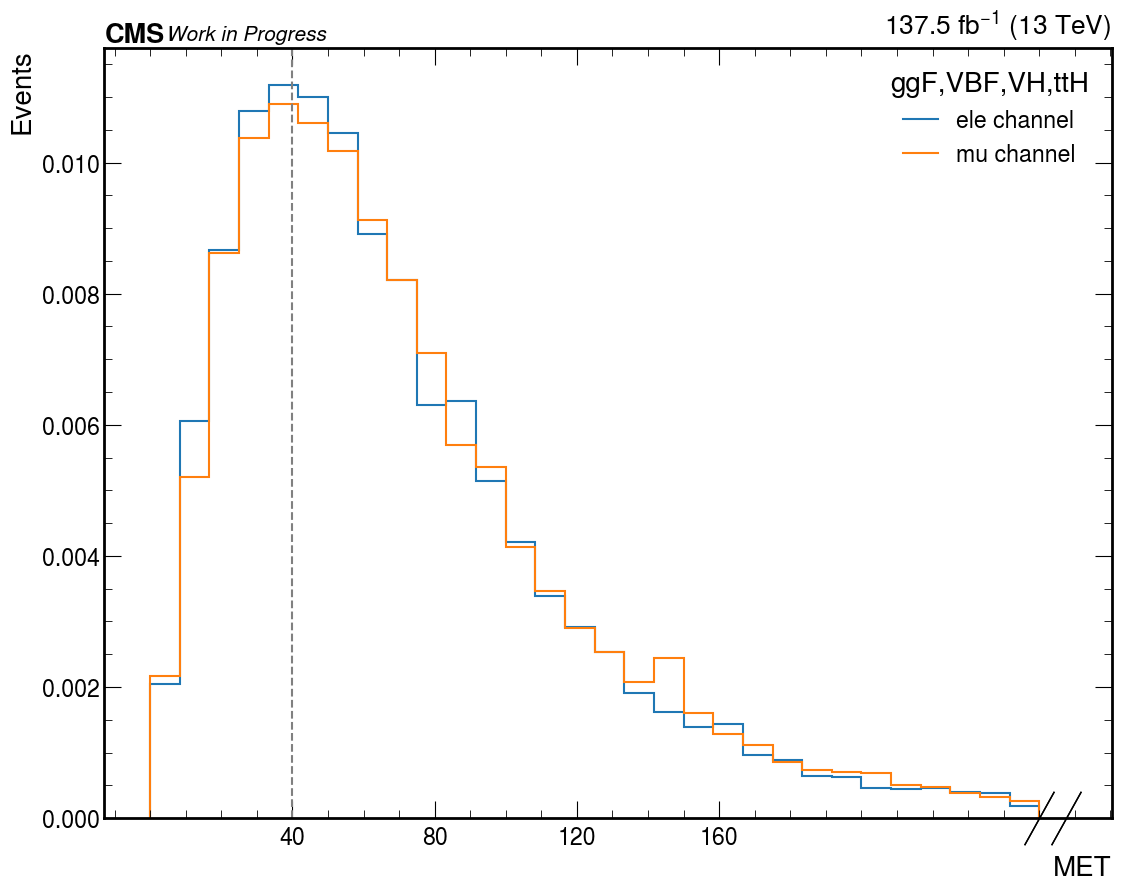

In [656]:
region = "Pre-selection + jetpt>200"
# region = "SR1"

# different regions
fig, ax = plt.subplots(figsize=(13, 10))
for ch in channels:
    hep.histplot(h[{"region": region, "channels": ch}].project("var"),
        label=ch + " channel",
        density=True,
#         yerr=True,
    )
ax.legend(title=",".join(samples), loc="upper right")
ax.set_ylabel("Events")
ax.set_ylim(0)
# ax.set_yscale("log")
ax.axvline(x=40, linestyle="--", color="grey")

ax.set_xticks([40, 80, 120, 160])
lum_=0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/AN/z.pdf")     

# WJetsLNu corrections

In [646]:
tagger = "fj_ParT_score"
tagger = "fj_ParT_score_finetuned"

presel = {    
    
    "Pre-selection": f"{tagger}>0.5",    
    
#     "SR1": f"({tagger}>0.98) & (n_bjets_T==0)",
#     "SR2": f"({tagger}<0.98) & ({tagger}>0.97) & (n_bjets_T==0)",
#     "WJets CR": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0)",
    
#     "WJets CR + jetpt>200": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>200",   
#     "WJets CR + jetpt>250": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>250", 
#     "WJets CR + jetpt>300": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>300", 
      
#     "WJets CR + jetpt>200 + MET>X": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>200", 
#     "WJets CR + jetpt>250 + MET>X": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>250", 
#     "WJets CR + jetpt>300 + MET>X": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>300", 
    
#     "Top CR": f"({tagger}>0.50) & (n_bjets_T>=0)",      
    

}

channels = ["ele", "mu"]
channels = ["ele"]
years = ["2018", "2017", "2016", "2016APV"]

# var = "rec_higgs_m"
var = "fj_pt"
# var = "event_weight"
if var=="rec_higgs_m":
    h = hist2.Hist(
        hist2.axis.StrCategory([], name="corr", growth=True),
        hist2.axis.Variable(list(range(50, 240, 20)), name="var", label=r"Higgs reconstructed mass [GeV]", overflow=True)
    )  
elif var == "fj_pt":
    h = hist2.Hist(
        hist2.axis.StrCategory([], name="corr", growth=True),
        hist2.axis.Variable(list(range(200, 800, 30)), name="var", label=r"Jet $p_T$ [GeV]", overflow=True)
    )  
    
for region, sel in presel.items():

    for year in years:
        for ch in channels:   
            for corr_ in ["old_corrections", "new_corrections"]:

                df = events_dict[corr_][year][ch]["WJetsLNu"]

                df = df.query(sel)    

                h.fill(
                    corr=corr_,
                    var=df[var],
                    weight=df["event_weight"],
                )

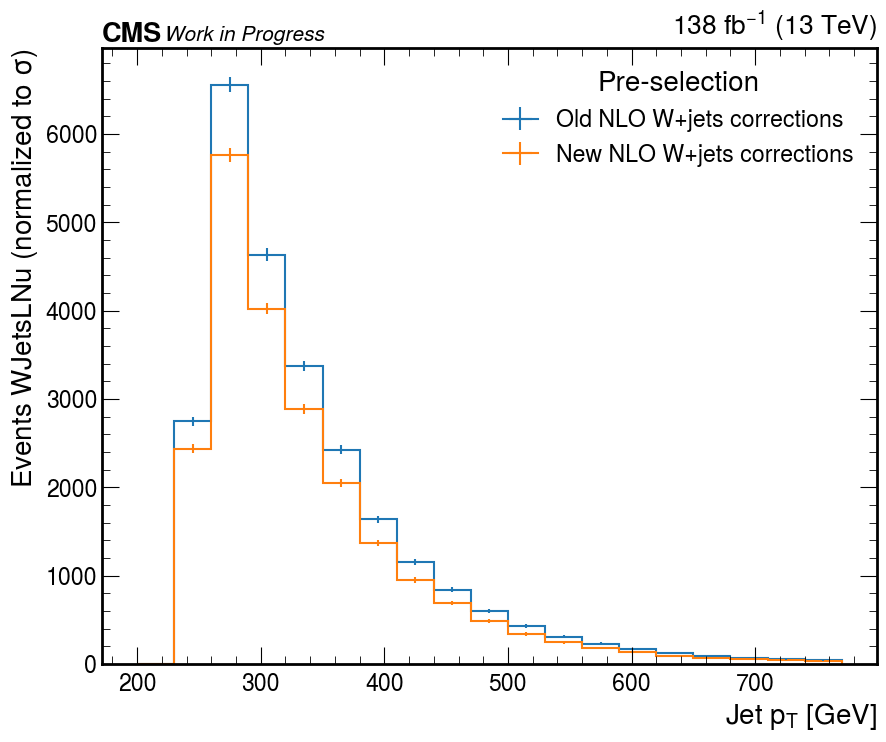

In [661]:
# different corrections

lab_dict = {
    "old_corrections": r"Old NLO W+jets corrections",
    "new_corrections": r"New NLO W+jets corrections",
}

fig, ax = plt.subplots(figsize=(10, 8))
for corr in ["old_corrections", "new_corrections"]:
    hep.histplot(h[{"corr": corr}].project("var"),
        label=lab_dict[corr],
        density=False,
        yerr=True,
        flow=None,
    )
ax.legend(title=region, loc="upper right")
ax.set_ylabel(r"Events WJetsLNu (normalized to $\sigma$)")
# ax.set_ylim(0, 0.013)
# ax.set_yscale("log")

lum_=0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.0f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/AN/wjetscorr.pdf")     

In [161]:
samples_to_plot = [
    'WJetsToLNu_HT-70To100',
    'WJetsToLNu_HT-100To200',
    'WJetsToLNu_HT-200To400',
    'WJetsToLNu_HT-400To600',
    'WJetsToLNu_HT-600To800',
    'WJetsToLNu_HT-800To1200',
    'WJetsToLNu_HT-1200To2500',
    'WJetsToLNu_HT-2500ToInf',    
]

In [181]:
tagger = "fj_ParT_score_finetuned"
presel = {
#     "Pre-selection": f"fj_pt>0",       

    "WJets control region": f"({tagger}<0.85) & ({tagger}>0.20)",
}

channels = ["ele", "mu"]
years = ["2018", "2017", "2016", "2016APV"]

# fill histograms
hists = {}

# var = "rec_higgs_m"
var = "fj_pt"
# var = "event_weight"
if var=="rec_higgs_m":
    h = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        hist2.axis.Variable(list(range(50, 240, 20)), name="var", label=r"Higgs reconstructed mass [GeV]", overflow=True)
    )  
elif var == "fj_pt":
    h = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        hist2.axis.Variable(list(range(200, 800, 30)), name="var", label=r"Jet $p_T$ [GeV]", overflow=True)
    )      

corr = "new_corrections_wjets"
ev = events_dict[corr]

for sample in samples_to_plot:
    for year in years:
        for ch in channels:

            region, sel = list(presel.items())[0]

            try:
                df = ev[year][ch][sample]
                df = df.query(sel)
                if "MET>X" in region:
                    if ch=="ele":
                        df = df[df["met_pt"]>70]
                    else:
                        df = df[df["met_pt"]>50]
                x = df[var]                            
                if len(x)==0:
                    x = 0   
                w = df["event_weight"]
                
            except:
                print(f"{sample} does not exist in {corr}")
                x = 0
                w = 0
                
            h.fill(
                samples=sample, var=x, weight=w,
            )

WJetsToLNu_HT-70To100 does not exist in new_corrections_wjets
WJetsToLNu_HT-70To100 does not exist in new_corrections_wjets
WJetsToLNu_HT-70To100 does not exist in new_corrections_wjets


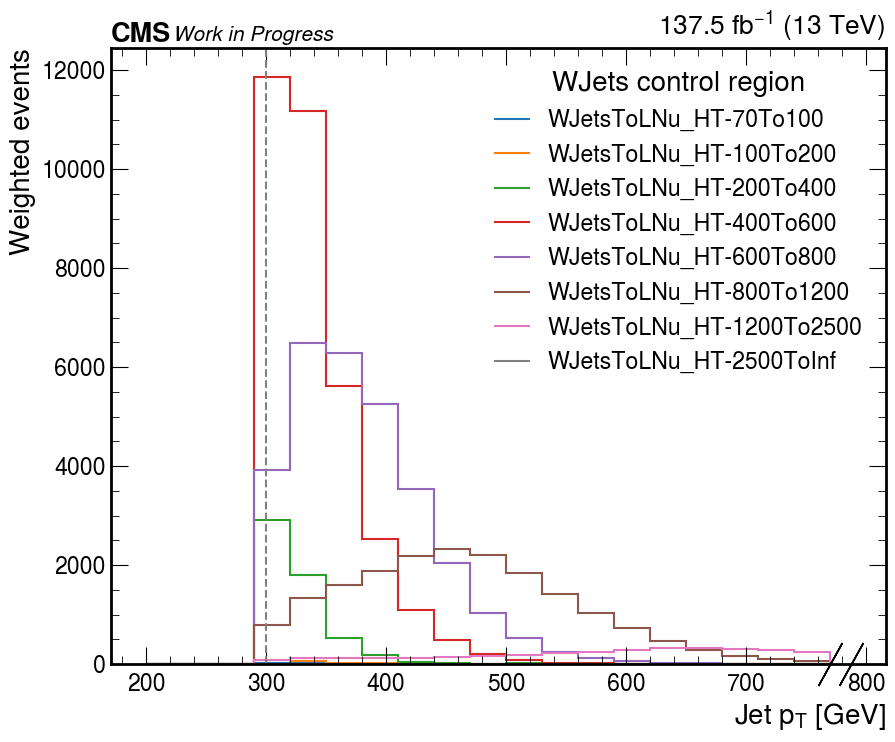

In [182]:
fig, ax = plt.subplots(figsize=(10, 8))
for sample in samples_to_plot:
    hep.histplot(h[{"samples": sample}].project("var"),
        label=sample,
#         density=True,
#         yerr=False,
    )
ax.axvline(300, linestyle="--", color="grey")
ax.legend(title=region, loc="upper right")
ax.set_ylabel("Weighted events")
# ax.set_ylim(0.01, 10e4)
# ax.set_ylim(0, 2500)
# ax.set_yscale("log")

lum_=0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku5/wjetscorr.pdf")     

# High qcd weights

In [1855]:
samples_to_plot = list(events_dictqcd["signal_region"]["2017"]["ele"].keys())
samples_to_plot

['QCD_Pt_3200toInf',
 'QCD_Pt_1800to2400',
 'QCD_Pt_2400to3200',
 'QCD_Pt_1000to1400',
 'QCD_Pt_600to800',
 'QCD_Pt_300to470',
 'QCD_Pt_170to300',
 'QCD_Pt_800to1000',
 'QCD_Pt_470to600',
 'QCD_Pt_1400to1800']

In [1856]:
tagger = "fj_ParT_score_finetuned"
presel = {
    "Pre-selection": f"fj_pt>0",       

#     "High purity signal region": f"({tagger}>0.97)",
#     "High purity signal region + MET>X": f"({tagger}>0.97)",
    
#     "Medium purity signal region": f"({tagger}<0.97) & ({tagger}>0.85)",
#     "Medium purity signal region + MET>X": f"({tagger}<0.97) & ({tagger}>0.85)",
    
#     "WJets control region": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0)",   
#     "WJets control region + MET>X": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0)",   
    
}

channels = ["ele", "mu"]
years = ["2018", "2017", "2016", "2016APV"]

# fill histograms
hists = {}

# var = "rec_higgs_m"
var = "fj_pt"
# var = "event_weight"
if var=="rec_higgs_m":
    h = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        hist2.axis.Variable(list(range(50, 240, 20)), name="var", label=r"Higgs reconstructed mass [GeV]", overflow=True)
    )  
elif var == "fj_pt":
    h = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        hist2.axis.Variable(list(range(200, 800, 30)), name="var", label=r"Jet $p_T$ [GeV]", overflow=True)
    )      
else:
    h = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        hist2.axis.Variable(list(range(0, 500, 20)), name="var", label=r"Event weight", overflow=True)
    )      

for sample in samples_to_plot:
    for year in years:
        for ch in channels:

            region, sel = list(presel.items())[0]

            df = events_dictqcd["signal_region"][year][ch][sample]
            df = df.query(sel)

            if "MET>X" in region:
                if ch=="ele":
                    df = df[df["met_pt"]>70]
                else:
                    df = df[df["met_pt"]>50]

            x = df[var]
            if len(x)==0:
                x = 0   
                
            if var=="event_weight":
                h.fill(
                    samples=sample, var=x,
                )

            else:
                h.fill(
                    samples=sample, var=x, weight=df["event_weight"],
                )

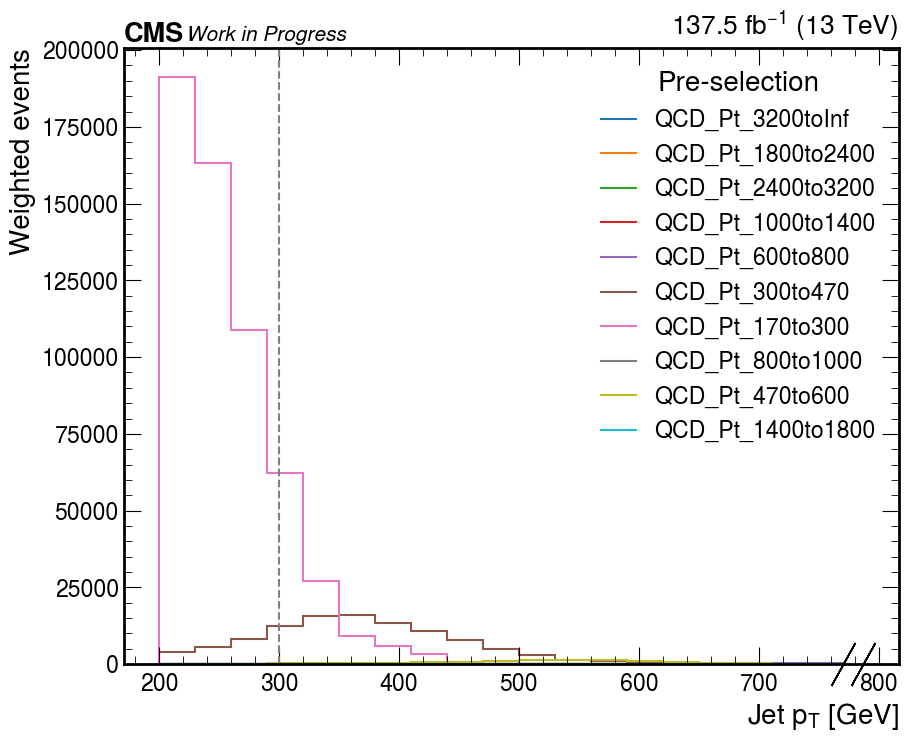

In [1857]:
fig, ax = plt.subplots(figsize=(10, 8))
for sample in samples_to_plot:
    hep.histplot(h[{"samples": sample}].project("var"),
        label=sample,
#         density=True,
#         yerr=False,
    )
ax.axvline(300, linestyle="--", color="grey")
ax.legend(title=region, loc="upper right")
ax.set_ylabel("Weighted events")
# ax.set_ylim(0.01, 10e4)
# ax.set_ylim(0, 2500)
# ax.set_yscale("log")

lum_=0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku5/qcd_high_weights_wjets_jetpt.pdf")     

# soverb

In [149]:
dominant_backgrounds = ["WJetsLNu", "TTbar", "QCD", "DYJets"]

In [150]:
samples

['ggF',
 'VH',
 'VBF',
 'ttH',
 'QCD',
 'DYJets',
 'WJetsLNu',
 'WZQQ',
 'TTbar',
 'SingleTop',
 'Diboson',
 'Data']

In [333]:
# tagger = "ParT_finetuned"
tagger = "fj_ParT_score_finetuned"

presel = {
#     "High purity signal region": f"({tagger}>0.97)",
#     "Medium purity signal region": f"({tagger}<0.97) & ({tagger}>0.85)",
    
#     "WJets control region": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0)", 
    "WJets control region": f"({tagger}<0.85) & ({tagger}>0.20)", 

#     "WJets control region + dR>0.2": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0) & (lep_fj_dr>0.2)",    

#     "Top control region": f"({tagger}<0.2) & (n_bjets_T>0)",  
#     "Top control region + dR>0.1": f"({tagger}<0.20) & (n_bjets_T>0) & (lep_fj_dr>0.1)",      

#     "QCD control region": f"({tagger}<0.20) & (n_bjets_T==0)",  
#     "Lep iso": f"fj_pt>0",
}

categories_sel = {
#     "VBF_pt200toinf": "( (mjj>1000) & (deta>3.5) )",
#     "ggF_pt200to300": "( (mjj<1000) | (deta<3.5) ) & (fj_pt<300)",    
#     "ggF_pt300toinf": "( (mjj<1000) | (deta<3.5) ) & (fj_pt>300)",
    
}

mass_window = [80, 160]

years = ["2018", "2017", "2016APV", "2016"]
channels = ["ele", "mu"]

num_sig = {
    "ggF": 0, 
    "ttH": 0, 
    "VH": 0,
    "VBF": 0,
}
num_bkg = {
    "WJetsLNu": 0, 
    "TTbar": 0, 
    "QCD": 0,
    "DYJets": 0,
    "Others": 0,
}

deno_sig, deno_bkg = 0, 0
s, b = 0, 0

for year in years:
    for ch in channels:
        for sample in samples:
            if sample=="Data":
                continue

            for k, v in presel.items():
                if "QCD" in k:
                    df = events_dict["qcd_region"][year][ch][sample]
                else:
                    df = events_dict["signal_region"][year][ch][sample]

                df = df.query(v)  
                
#                 if "High" in k:
#                     if sample == "QCD":
#                         df = df[df["event_weight"]<140]
#                 if "Medium" in k:
#                     if sample == "QCD":
#                         df = df[df["event_weight"]<200]
            
#             for category, category_sel in categories_sel.items():
#                 df = df.query(category_sel)            
            
#             if sample == "QCD":
#                 df = df[df["event_weight"]<50]
                
#             if ch=="ele":
#                 df = df[df["met_pt"]>70]
#             else:
#                 df = df[df["met_pt"]>50]
                
#             df = df[df["n_bjets_L"]==0]
#             df = df[df["lep_fj_dr"]>0.2]
            df = df[df["lep_met_mt"]>40]
    
#             df = df[(df["fj_pt"]/df["lep_pt"])<3]

#             df = df[np.abs(df["met_fj_dphi"])<2.5]

#             df = df[df["fj_ParT_mass"]<50]

#             df = df[df["fj_pt"]>250]
            ######################## composition start
            if sample in utils.signals:
                
                deno_sig += df["event_weight"].sum()
                num_sig[sample] += df["event_weight"].sum()
            else:
                deno_bkg += df["event_weight"].sum()
                
                if sample in dominant_backgrounds:
                    num_bkg[sample] += df["event_weight"].sum()
                else:
                    num_bkg["Others"] += df["event_weight"].sum()     
            ######################## composition end
            
            ######################## soverb start
            df = df[(df["rec_higgs_m"]>=mass_window[0]) & (df["rec_higgs_m"]<=mass_window[1])]
    
            if sample in utils.signals:                
                s += df["event_weight"].sum()
            else:
                b += df["event_weight"].sum()
            ######################## soverb end

In [334]:
num_sig = dict(sorted(num_sig.items(), key=lambda item: item[1]))
num_bkg = dict(sorted(num_bkg.items(), key=lambda item: item[1]))

if len(years) == 4:
    lab = "Run2"
else:
    lab = "_".join(years)

print("\033[1m" + f"{list(presel.keys())[0]} ({lab}):" + '\033[0m')
# print("Category:", category)

print("------------------------")

if "purity" in list(presel.keys())[0]:
    print("\033[1m" + rf"s/sqrt(b) in [{mass_window[0]},{mass_window[1]}]: {s/math.sqrt(b):.2f}" + '\033[0m')
    print("------------------------")

print(f"Signal: {deno_sig:.2f}")
for sample in num_sig:
    print(f"- {sample}: {100*(num_sig[sample]/deno_sig):.0f}%")
    
print("------------------------")
print(f"Background: {deno_bkg:.2f}")
for sample in num_bkg:
    if sample=="":
        print("\033[1m" + f"- {sample}: {100*(num_bkg[sample]/deno_bkg):.0f}%")
    else:
        print(f"- {sample}: {100*(num_bkg[sample]/deno_bkg):.0f}%") 

WJets control region (Run2):
------------------------
Signal: 475.17
- ttH: 16%
- VH: 17%
- VBF: 20%
- ggF: 47%
------------------------
Background: 497404.16
- Others: 2%
- QCD: 5%
- DYJets: 15%
- TTbar: 18%
- WJetsLNu: 59%


In [587]:
(0.74**2 + 0.81**2 + 0.59**2)**0.5   # VBF / ggF200-300 / ggF300-450 / ggF450-inf

1.2457126474432216

# WJetsLNu region

In [455]:
tagger = "fj_ParT_score_finetuned_v2_nor2"

# mass_window = [50, 200]

years = ["2018", "2017"]
# years = ["2017"]
channels = ["ele", "mu"]

num_sig = {
    "ggF": 0, 
    "ttH": 0, 
    "VH": 0,
    "VBF": 0,
}
num_bkg = {
    "WJetsLNu": 0, 
    "TTbar": 0, 
    "QCD": 0,
    "Others": 0,
}
deno_sig, deno_bkg = 0, 0

# tagger_cuts = [0.01, 0.02, 0.03, 0.04, 0.07, 0.09, 0.1, 0.2, 0.8]
# tagger_cuts = np.linspace(0.01, 0.8, 21)
tagger_cuts = np.linspace(0.01, 0.3, 21)
ttt = []
for tagger_cut in tagger_cuts:
    for year in years:
        for ch in channels:
            for sample in samples:
                if sample=="Data":
                    continue

                df = events_dict[year][ch][sample]

    #             df = df[(df["rec_higgs_m"]>mass_window[0]) & (df["rec_higgs_m"]<mass_window[1])]

                df = df[df["event_weight"]<140]
                df = df[df[tagger]<0.85]
                df = df[df[tagger]>tagger_cut]
                df = df[df["n_bjets_L"]==0]                


                if sample in utils.signals:
                    deno_sig += df["event_weight"].sum()
                    num_sig[sample] += df["event_weight"].sum()
                else:
                    deno_bkg += df["event_weight"].sum()
                    if sample in dominant_backgrounds:
                        num_bkg[sample] += df["event_weight"].sum()
                    else:
                        num_bkg["Others"] += df["event_weight"].sum()
                        
    ttt.append(100*(num_bkg["WJetsLNu"]/deno_bkg))  

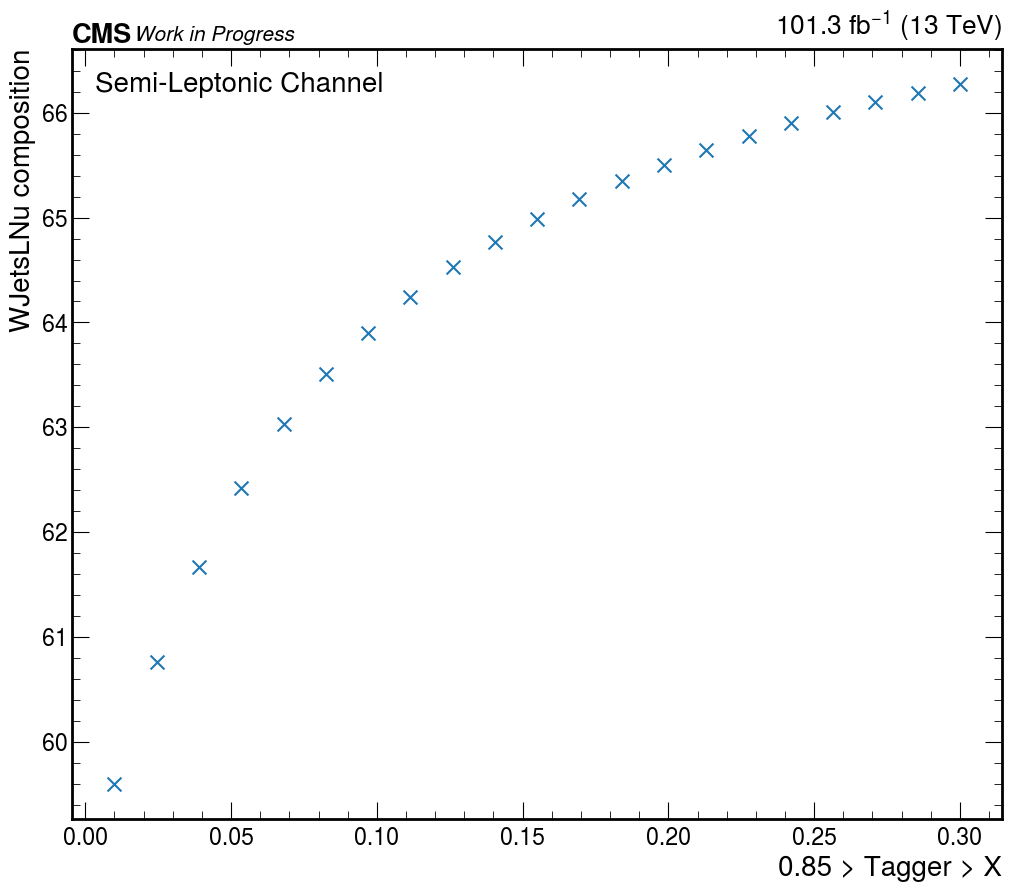

In [456]:
years = ["2018", "2017"]
fig, ax = plt.subplots(figsize=(12, 10))
ax.scatter(tagger_cuts, ttt, marker="x", s=100)

# ax.axvline(0.85, color="grey", linestyle="--")#, label=rf"125 GeV")

# ax.set_ylim(0, 1.4)
ax.legend(title=f"Semi-Leptonic Channel")
ax.set_ylabel(r"WJetsLNu composition");
ax.set_xlabel(r"0.85 > Tagger > X")
# ax.set_xlabel(rf"{wp} > Tagger > X")
# ax.set_xticks(tagger_cuts)
# ax.set_xticks([0.9, 0.92, 0.94, 0.96, 0.97, 0.98])

lum_ = 0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku/soverb_W_region4.pdf")  

# Sculpting

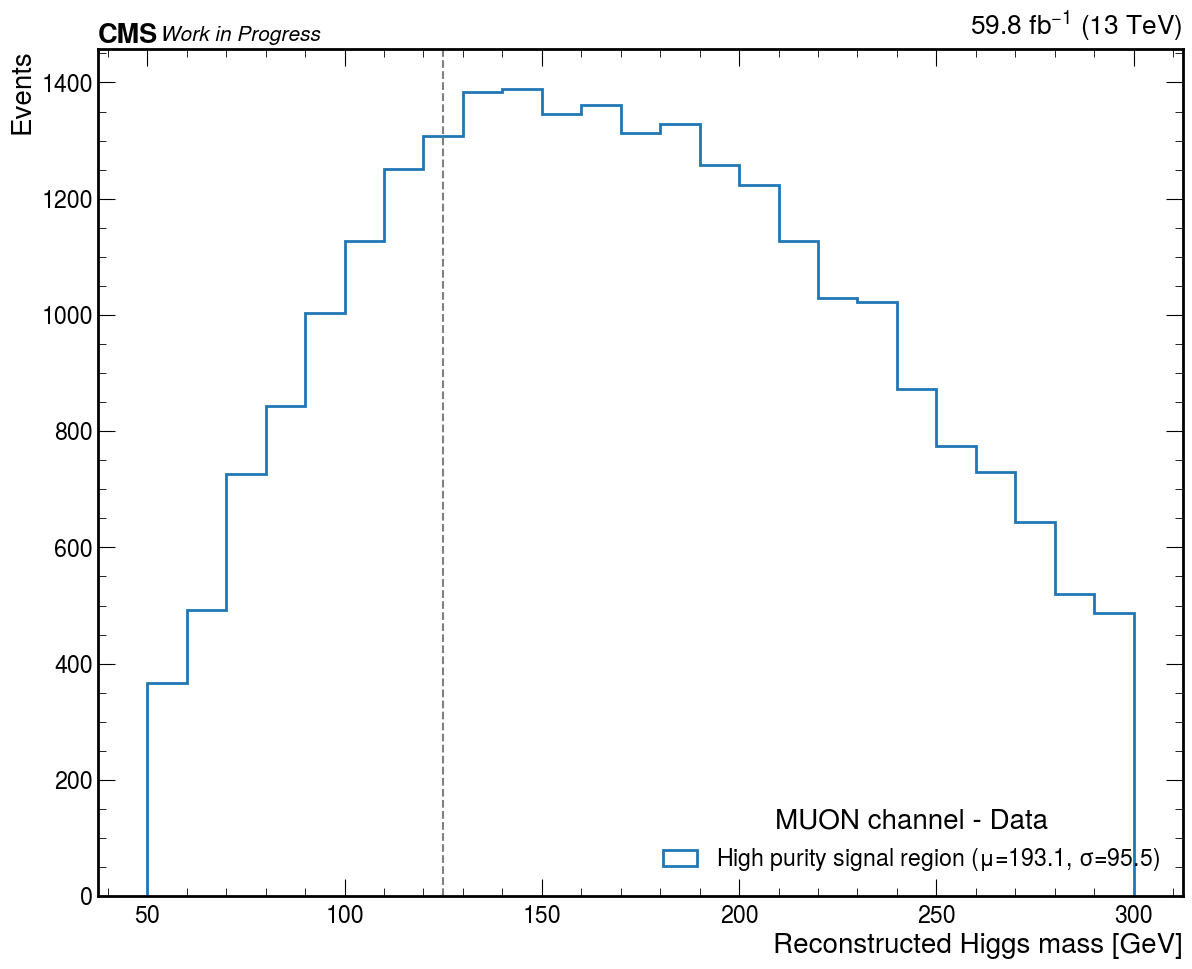

In [531]:
plt.rcParams.update({"font.size": 20})

# tagger = "fj_ParT_score_finetuned_v2_10_12"
tagger = "fj_ParT_score"
# tagger = "fj_ParT_score_finetuned"
presel = {
    "High purity signal region": f"({tagger}>0.97)",
#     "Medium purity signal region": f"({tagger}<0.97) & ({tagger}>0.85)",    
#     "Low purity signal region": f"({tagger}<0.85) & ({tagger}>0.20)",   
    
#     "Top control region": f"({tagger}<0.30) & (n_bjets_T>0)",  

#     "Top control region + dR>0.1": f"({tagger}<0.3) & (n_bjets_T>0) & (lep_fj_dr>0.1)",
#     "Top control region + dR>0.2": f"({tagger}<0.3) & (n_bjets_T>0) & (lep_fj_dr>0.2)",
#     "Top control region + dR>0.3": f"({tagger}<0.3) & (n_bjets_T>0) & (lep_fj_dr>0.3)",
#     "Top control region + dR>0.4": f"({tagger}<0.9) & (n_bjets_T>0) & (lep_fj_dr>0.4)",
    
#     "WJets control region": f"({tagger}<0.80) & ({tagger}>0.20) & (n_bjets_L==0)",

#     "QCD control region": f"({tagger}<0.20) & (n_bjets_T==0)",  
    
#     "ParT-finetuned>0.97": f"(fj_ParT_score_finetuned_v2_nor2>0.97)",
#     "ParT>0.99": f"(fj_ParT_score>0.99)"
    
    
}

nice_ch = {
    "ele": "ELECTRON",
    "mu": "MUON",
}

sample = "Data"
channels = ["mu"]#, "ele"]
years = ["2018"]#, "2017"]

fig, ax = plt.subplots(figsize=(14, 11))
for k, v in presel.items():
    
    for year in years:

        if "QCD" in k:
            region="qcd_region"
        else:
            region="signal_region"

        df1 = events_dict[region][year]["mu"][sample]    
        df2 = events_dict[region][year]["ele"][sample]

        df = pd.concat([df1, df2])

        if len(years) > 1:
            df1 = events_dict[region][years[1]]["mu"][sample]    
            df2 = events_dict[region][years[1]]["ele"][sample]

            df11 = pd.concat([df1, df2])

            df = pd.concat([df, df11])
            break
            
    bins = 26

    df1 = df.copy().query(v)

    x = df1["rec_higgs_m"]
#     w = df1["event_weight"]

    ax.hist(
        x, 
        bins=np.linspace(50,300,bins), 
#         weights=w,
#         density=True, 
        histtype="step", 
        linewidth=2, 
        label=rf"{k} ($\mu$={np.mean(x):.1f}, $\sigma$={np.std(x):.1f})"
    )

ax.axvline(125, color="grey", linestyle="--")#, label=rf"125 GeV")

if len(channels) > 1:
    ax.legend(title=f"{sample}")    
else:
    ax.legend(title=f"{nice_ch[ch]} channel - {sample}")


ax.set_ylabel("Events")
ax.set_xlabel(f"Reconstructed Higgs mass [GeV]")
ax.set_ylim(0)

lum_=0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku/mass_sculpting_{sample}.pdf")        

In [514]:
all_files = glob.glob("ttt/*")
log_files = glob.glob("ttt/log*")

In [505]:
all_files

['ttt/t', 'ttt/log.txt', 'ttt/a.txt']

In [506]:
log_files

['ttt/log.txt']

# Data

In [803]:
# get lumi
with open("../fileset/luminosity.json") as f:
    luminosity = json.load(f)
    
luminosity

{'ele': {'Run2': 137640.0,
  '2016APV': 19492.72,
  '2016': 16809.96,
  '2017': 41476.02,
  '2018': 59816.23},
 'mu': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'lep': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96}}

In [804]:
################### option 2
def blindBins(h, blind_region, blind_samples=[]):
    """
    Blind (i.e. zero) bins in histogram ``h``.
    If ``blind_samples`` specified, only blind those samples, else blinds all.

    CAREFUL: assumes axis=0 is samples, axis=3 is mass_axis

    """

    h = h.copy()

    massbins = h.axes["mass_observable"].edges

    lv = int(np.searchsorted(massbins, blind_region[0], "right"))
    rv = int(np.searchsorted(massbins, blind_region[1], "left") + 1)

    if blind_samples:
        for blind_sample in blind_samples:
            sample_index = np.argmax(np.array(list(h.axes[0])) == blind_sample)
            h.view(flow=True)[sample_index, :, :, lv:rv] = 0

    else:
        h.view(flow=True)[:, :, :, lv:rv] = 0

    return h

plt.rcParams.update({"font.size": 20})

# tagger = "fj_ParT_score"
tagger = "fj_ParT_score_finetuned"

regions_sel = {
#     "Pre-selection": f"{tagger}>0.5",    
    "SR1 (tagger>0.97 + nbjetsT==0)": f"({tagger}>0.97) & (n_bjets_T==0)",
#     "SR2 (0.97>tagger>0.85 + nbjetsT==0)": f"({tagger}<0.97) & ({tagger}>0.85) & (n_bjets_T==0)",
#     "WJets CR (0.85>tagger>0.50 + nbjetsT==0)": f"({tagger}<0.85) & ({tagger}>0.50) & (n_bjets_T==0)",    
#     "Top CR (tagger>0.85 + nbjetsT>0)": f"({tagger}>0.85) & (n_bjets_T>0)", 
    
}

categories_sel = {
    "VBF category": "(mjj>1000) & (deta>3.5)",
#     rf"ggF category ($p_T$ $\in$ [200, 450])": "(mjj<1000) & (deta<3.5) & (fj_pt>200) & (fj_pt<450)",
    rf"ggF category ($p_T$ $\in$ [300, inf])": "(mjj<1000) & (deta<3.5) & (fj_pt>300)",
}

samples = ["Data", "ggF", "VBF"]
channels = ["ele", "mu"]
# channels = ["mu"]
blind = True
blind_region = (90, 160)

years = ["2018", "2017", "2016", "2016APV"]
lum = 0
for year in years:
    lum += luminosity[ch][year] / 1000.0
    

# fill histograms
hists = hist2.Hist(
    hist2.axis.StrCategory([], name="samples", growth=True),            
    hist2.axis.StrCategory([], name="regions", growth=True),
    hist2.axis.StrCategory([], name="categories", growth=True),    
    hist2.axis.Variable(
        list(range(50, 240, 20)), name="mass_observable", label=r"Higgs reconstructed mass [GeV]", overflow=True
    ),
)        

mult = {
    "SR1 (tagger>0.97 + nbjetsT==0)": 10,
#     "SR2 (0.97>tagger>0.85 + nbjetsT==0)": 100,
}

for sample in samples:
    for year in years:
        for ch in channels:
            df = ev[year][ch][sample]
            for region, region_sel in regions_sel.items():
                for category, category_sel in categories_sel.items():
                    df1 = df.copy().query(region_sel)
                    df1 = df1.query(category_sel)

                    if ((sample=="ggF") or (sample=="VBF")):
                        df1["event_weight"]=df1["event_weight"]*mult[region]

                    hists.fill(
                        samples=sample,
                        regions=region,
                        categories=category,
                        mass_observable=df1["rec_higgs_m"],
                        weight=df1["event_weight"],
                    )

INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral


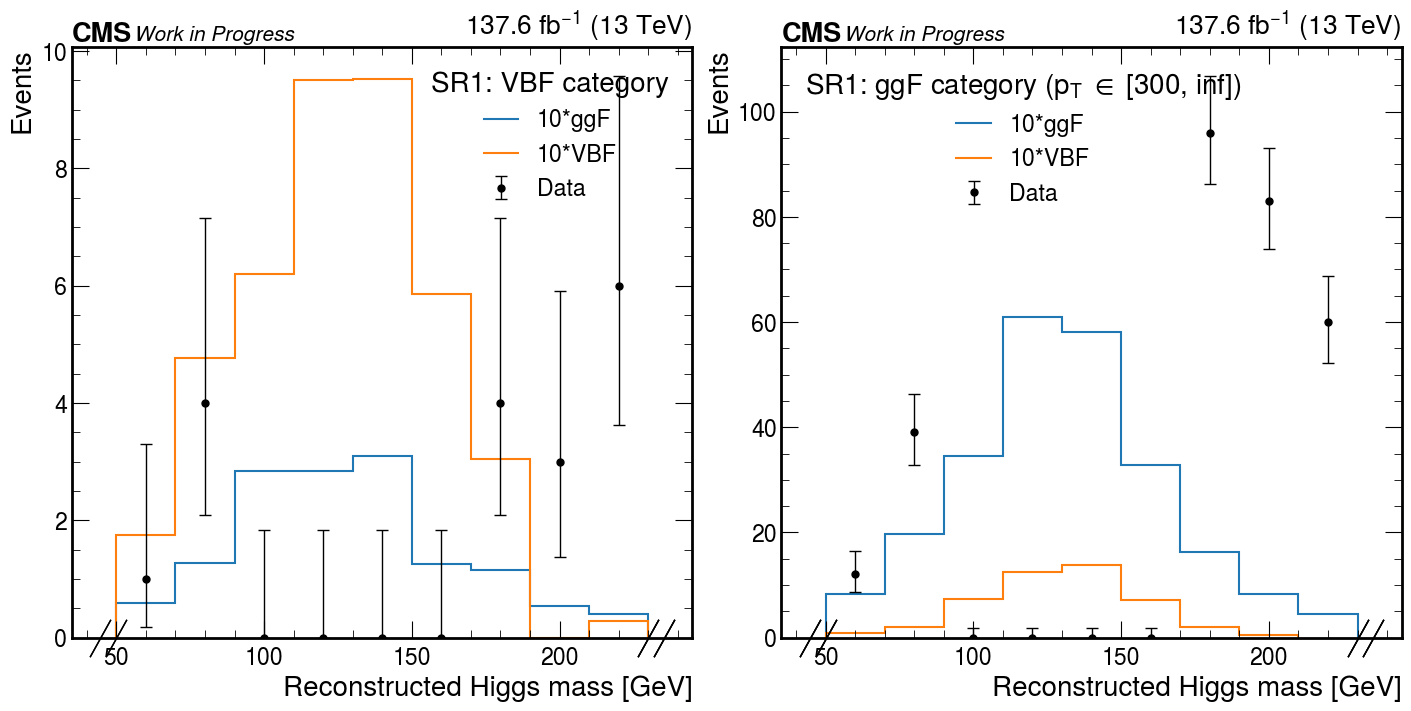

In [805]:
fig, axs = plt.subplots(1, 2, figsize=(14,7), constrained_layout=True)

region = list(regions_sel.items())[0][0]
for i, category in enumerate(categories_sel):
    for sample in samples:
        
        
        if sample == "Data":
            if blind:
                hists = blindBins(hists, (blind_region[0],blind_region[1]), blind_samples=["Data"])
            
            hep.histplot(
                hists[{"samples": sample, "regions": region, "categories": category}],
                ax=axs[i],
                label=sample,
                histtype="errorbar",
                color="k",
                capsize=4,           
            )   
            
        else:
            if mult[region]==1:
                lab = sample            
            else:
                lab = f"{mult[region]}*{sample}"
            
            hep.histplot(
                hists[{"samples": sample, "regions": region, "categories": category}],
                ax=axs[i],
                histtype="step",
                label=lab,
            )    
                

    axs[i].legend(title=f"SR1: {category}")
    axs[i].set_ylabel(f"Events")
    axs[i].set_xlabel(f"Reconstructed Higgs mass [GeV]")
    axs[i].set_ylim(0)    
    hep.cms.lumitext("%.1f " % lum + r"fb$^{-1}$ (13 TeV)", ax=axs[i], fontsize=20)
    hep.cms.text("Work in Progress", ax=axs[i], fontsize=15)
#     if i==2:
#         axs[i].set_yticks([0,4,8,12,16])
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku5/ww3.pdf")

In [1099]:
################### option 2
def blindBins(h, blind_region, blind_samples=[]):
    """
    Blind (i.e. zero) bins in histogram ``h``.
    If ``blind_samples`` specified, only blind those samples, else blinds all.

    CAREFUL: assumes axis=0 is samples, axis=3 is mass_axis

    """

    h = h.copy()

    massbins = h.axes["mass_observable"].edges

    lv = int(np.searchsorted(massbins, blind_region[0], "right"))
    rv = int(np.searchsorted(massbins, blind_region[1], "left") + 1)

    if blind_samples:
        for blind_sample in blind_samples:
            sample_index = np.argmax(np.array(list(h.axes[0])) == blind_sample)
            h.view(flow=True)[sample_index, :, :, lv:rv] = 0

    else:
        h.view(flow=True)[:, :, :, lv:rv] = 0

    return h

plt.rcParams.update({"font.size": 20})

# tagger = "fj_ParT_score"
tagger = "fj_ParT_score_finetuned"

regions_sel = {
#     "Pre-selection": f"{tagger}>0.5",    
    "SR1": f"({tagger}>0.98) & (n_bjets_T==0)",
#     "SR2": f"({tagger}>0.97) & ({tagger}<0.98) & (n_bjets_T==0)",

    
#     "SR1 (tagger>0.97 + nbjetsT==0)": f"({tagger}>0.97) & (n_bjets_T==0)",
#     "SR2 (0.97>tagger>0.85 + nbjetsT==0)": f"({tagger}<0.97) & ({tagger}>0.85) & (n_bjets_T==0)",
#     "WJets CR (0.85>tagger>0.50 + nbjetsT==0)": f"({tagger}<0.85) & ({tagger}>0.50) & (n_bjets_T==0)",    
#     "Top CR (tagger>0.85 + nbjetsT>0)": f"({tagger}>0.85) & (n_bjets_T>0)", 
    
}

categories_sel = {
    "VBF category": "(mjj>1000) & (deta>3.5)",
    rf"ggF category ($p_T$ $\in$ [300, 450])": "(mjj<1000) & (deta<3.5) & (fj_pt>300) & (fj_pt<450)",
    rf"ggF category ($p_T$ $\in$ [450, inf])": "(mjj<1000) & (deta<3.5) & (fj_pt>450)",
    
#     rf"ggF category ($p_T$ $\in$ [300, 450])": "(mjj<1000) & (deta<3.5) & (fj_pt>300) & (fj_pt<450)",
#     rf"ggF category ($p_T$ $\in$ [450, 650])": "(mjj<1000) & (deta<3.5) & (fj_pt>450) & (fj_pt<650)",
#     rf"ggF category ($p_T$ $\in$ [650, inf])": "(mjj<1000) & (deta<3.5) & (fj_pt>650)",        
}

samples = ["Data", "ggF", "VBF"]
channels = ["ele", "mu"]
blind = True
blind_region = (90, 160)

years = ["2018", "2017", "2016", "2016APV"]
lum = 0
for year in years:
    lum += luminosity[ch][year] / 1000.0
    

# fill histograms
hists = hist2.Hist(
    hist2.axis.StrCategory([], name="samples", growth=True),            
    hist2.axis.StrCategory([], name="regions", growth=True),
    hist2.axis.StrCategory([], name="categories", growth=True),    
    hist2.axis.Variable(
        list(range(50, 240, 20)), name="mass_observable", label=r"Higgs reconstructed mass [GeV]", overflow=True
    ),
)        

mult = {
    "SR1": 10,
    "SR2": 100,
}

for sample in samples:
    for year in years:
        for ch in channels:
            df = ev[year][ch][sample]
            for region, region_sel in regions_sel.items():
                for category, category_sel in categories_sel.items():
                    df1 = df.copy().query(region_sel)
                    df1 = df1.query(category_sel)

                    if ((sample=="ggF") or (sample=="VBF")):
                        df1["event_weight"]=df1["event_weight"]*mult[region]

                    hists.fill(
                        samples=sample,
                        regions=region,
                        categories=category,
                        mass_observable=df1["rec_higgs_m"],
                        weight=df1["event_weight"],
                    )

INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral


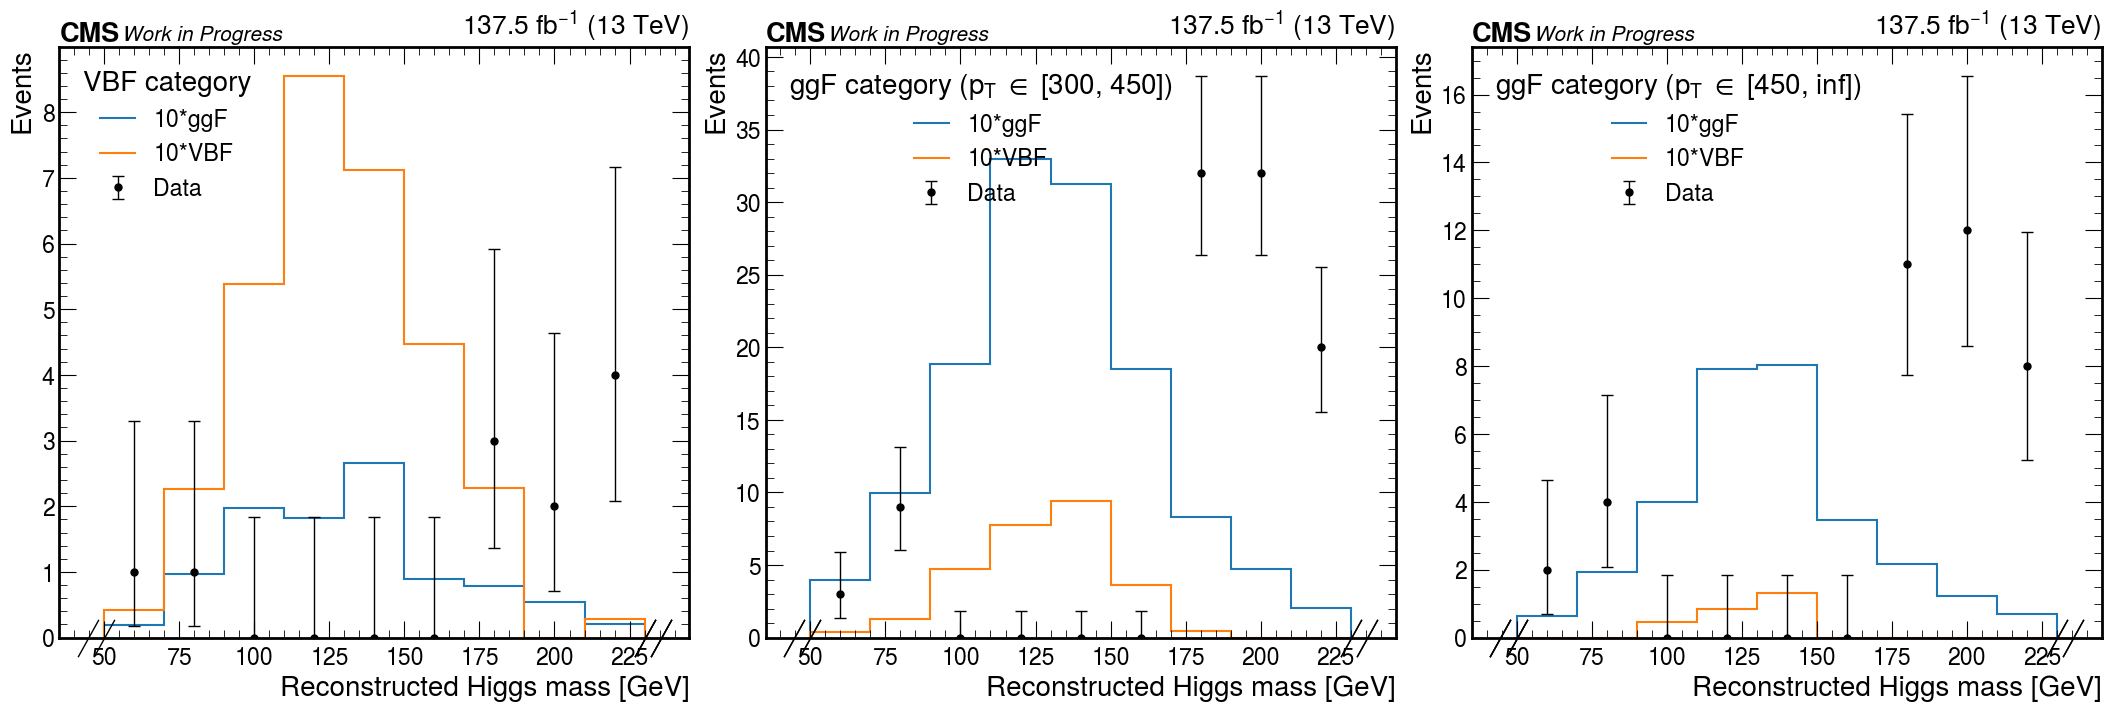

In [1100]:
fig, axs = plt.subplots(1, 3, figsize=(21,7), constrained_layout=True)

region = list(regions_sel.items())[0][0]
for i, category in enumerate(categories_sel):
    for sample in samples:
        
        
        if sample == "Data":
            if blind:
                hists = blindBins(hists, (blind_region[0],blind_region[1]), blind_samples=["Data"])
            
            hep.histplot(
                hists[{"samples": sample, "regions": region, "categories": category}],
                ax=axs[i],
                label=sample,
                histtype="errorbar",
                color="k",
                capsize=4,           
            )   
            
        else:
            if mult[region]==1:
                lab = sample            
            else:
                lab = f"{mult[region]}*{sample}"
            
            hep.histplot(
                hists[{"samples": sample, "regions": region, "categories": category}],
                ax=axs[i],
                histtype="step",
                label=lab,
            )    
            
    axs[i].legend(title=category)
    axs[i].set_ylabel(f"Events")
    axs[i].set_xlabel(f"Reconstructed Higgs mass [GeV]")
    axs[i].set_ylim(0)    
    hep.cms.lumitext("%.1f " % lum + r"fb$^{-1}$ (13 TeV)", ax=axs[i], fontsize=20)
    hep.cms.text("Work in Progress", ax=axs[i], fontsize=15)
#     if i==2:
#         axs[i].set_yticks([0,4,8,12,16])
plt.savefig(f"/Users/fmokhtar/Desktop/AN/ww2.pdf")

In [25]:
################### option 2
def blindBins(h, blind_region, blind_samples=[]):
    """
    Blind (i.e. zero) bins in histogram ``h``.
    If ``blind_samples`` specified, only blind those samples, else blinds all.

    CAREFUL: assumes axis=0 is samples, axis=3 is mass_axis

    """

    h = h.copy()

    massbins = h.axes["mass_observable"].edges

    lv = int(np.searchsorted(massbins, blind_region[0], "right"))
    rv = int(np.searchsorted(massbins, blind_region[1], "left") + 1)

    if blind_samples:
        for blind_sample in blind_samples:
            sample_index = np.argmax(np.array(list(h.axes[0])) == blind_sample)
            h.view(flow=True)[sample_index, :, :, lv:rv] = 0

    else:
        h.view(flow=True)[:, :, :, lv:rv] = 0

    return h

plt.rcParams.update({"font.size": 20})

# tagger = "fj_ParT_score"
tagger = "fj_ParT_score_finetuned"

regions_sel = {
#     "Pre-selection": f"{tagger}>0.5",   
    
    "SR1": f"(n_bjets_T==0)",
    
#     "SR1": f" & (n_bjets_T==0)",
#     "SR2": f"({tagger}>0.97) & ({tagger}<0.98) & (n_bjets_T==0)",

    
#     "SR1 (tagger>0.97 + nbjetsT==0)": f"({tagger}>0.97) & (n_bjets_T==0)",
#     "SR2 (0.97>tagger>0.85 + nbjetsT==0)": f"({tagger}<0.97) & ({tagger}>0.85) & (n_bjets_T==0)",
#     "WJets CR (0.85>tagger>0.50 + nbjetsT==0)": f"({tagger}<0.85) & ({tagger}>0.50) & (n_bjets_T==0)",    
#     "Top CR (tagger>0.85 + nbjetsT>0)": f"({tagger}>0.85) & (n_bjets_T>0)", 
    
}

# categories_sel = {
#     "VBF category": "(mjj>1000) & (deta>3.5)",
#     rf"ggF category ($p_T$ $\in$ [300, 450])": "(mjj<1000) & (deta<3.5) & (fj_pt>300) & (fj_pt<450)",
#     rf"ggF category ($p_T$ $\in$ [450, inf])": "(mjj<1000) & (deta<3.5) & (fj_pt>450)",
    
# #     rf"ggF category ($p_T$ $\in$ [300, 450])": "(mjj<1000) & (deta<3.5) & (fj_pt>300) & (fj_pt<450)",
# #     rf"ggF category ($p_T$ $\in$ [450, 650])": "(mjj<1000) & (deta<3.5) & (fj_pt>450) & (fj_pt<650)",
# #     rf"ggF category ($p_T$ $\in$ [650, inf])": "(mjj<1000) & (deta<3.5) & (fj_pt>650)",        
# }

categories_sel = {
    "SR1": {
        "VBF": f"({tagger}>0.97) & (mjj>1000) & (deta>3.5)",
        rf"ggF $p_T$ $\in$ [250, 300]": f"({tagger}>0.98) & (mjj<1000) & (deta<3.5) & (fj_pt>250) & (fj_pt<300)",        
        rf"ggF $p_T$ $\in$ [300, 450]": f"({tagger}>0.98) & (mjj<1000) & (deta<3.5) & (fj_pt>300) & (fj_pt<450)",
        rf"ggF $p_T$ $\in$ [450, Inf]": f"({tagger}>0.98) & (mjj<1000) & (deta<3.5) & (fj_pt>450)",
    },
    
    "SR2": {
    rf"all inclusive": "(mjj<1000) & (deta<3.5)",
    }
}
#     "VBF category": "(mjj>1000) & (deta>3.5)",
#     rf"ggF category ($p_T$ $\in$ [300, 450])": "(mjj<1000) & (deta<3.5) & (fj_pt>300) & (fj_pt<450)",
#     rf"ggF category ($p_T$ $\in$ [450, inf])": "(mjj<1000) & (deta<3.5) & (fj_pt>450)",
    
#     rf"ggF category ($p_T$ $\in$ [300, 450])": "(mjj<1000) & (deta<3.5) & (fj_pt>300) & (fj_pt<450)",
#     rf"ggF category ($p_T$ $\in$ [450, 650])": "(mjj<1000) & (deta<3.5) & (fj_pt>450) & (fj_pt<650)",
#     rf"ggF category ($p_T$ $\in$ [650, inf])": "(mjj<1000) & (deta<3.5) & (fj_pt>650)",        


samples = ["Data", "ggF", "VBF"]
channels = ["ele", "mu"]
blind = True
blind_region = (90, 160)

years = ["2018", "2017", "2016", "2016APV"]
lum = 0
for year in years:
    lum += luminosity[ch][year] / 1000.0
    

# fill histograms
hists = hist2.Hist(
    hist2.axis.StrCategory([], name="samples", growth=True),            
    hist2.axis.StrCategory([], name="regions", growth=True),
    hist2.axis.StrCategory([], name="categories", growth=True),    
    hist2.axis.Variable(
        list(range(50, 240, 20)), name="mass_observable", label=r"Higgs reconstructed mass [GeV]", overflow=True
    ),
)        

mult = {
    "SR1": 10,
    "SR2": 10,
}

for sample in samples:
    for year in years:
        for ch in channels:
            df = ev[year][ch][sample]
            for region, region_sel in regions_sel.items():

                for category, category_sel in categories_sel[region].items():
                    df1 = df.copy().query(region_sel)
                    df1 = df1.query(category_sel)

                    if ((sample=="ggF") or (sample=="VBF")):
                        df1["event_weight"]=df1["event_weight"]*mult[region]

                    hists.fill(
                        samples=sample,
                        regions=region,
                        categories=category,
                        mass_observable=df1["rec_higgs_m"],
                        weight=df1["event_weight"],
                    )

INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral


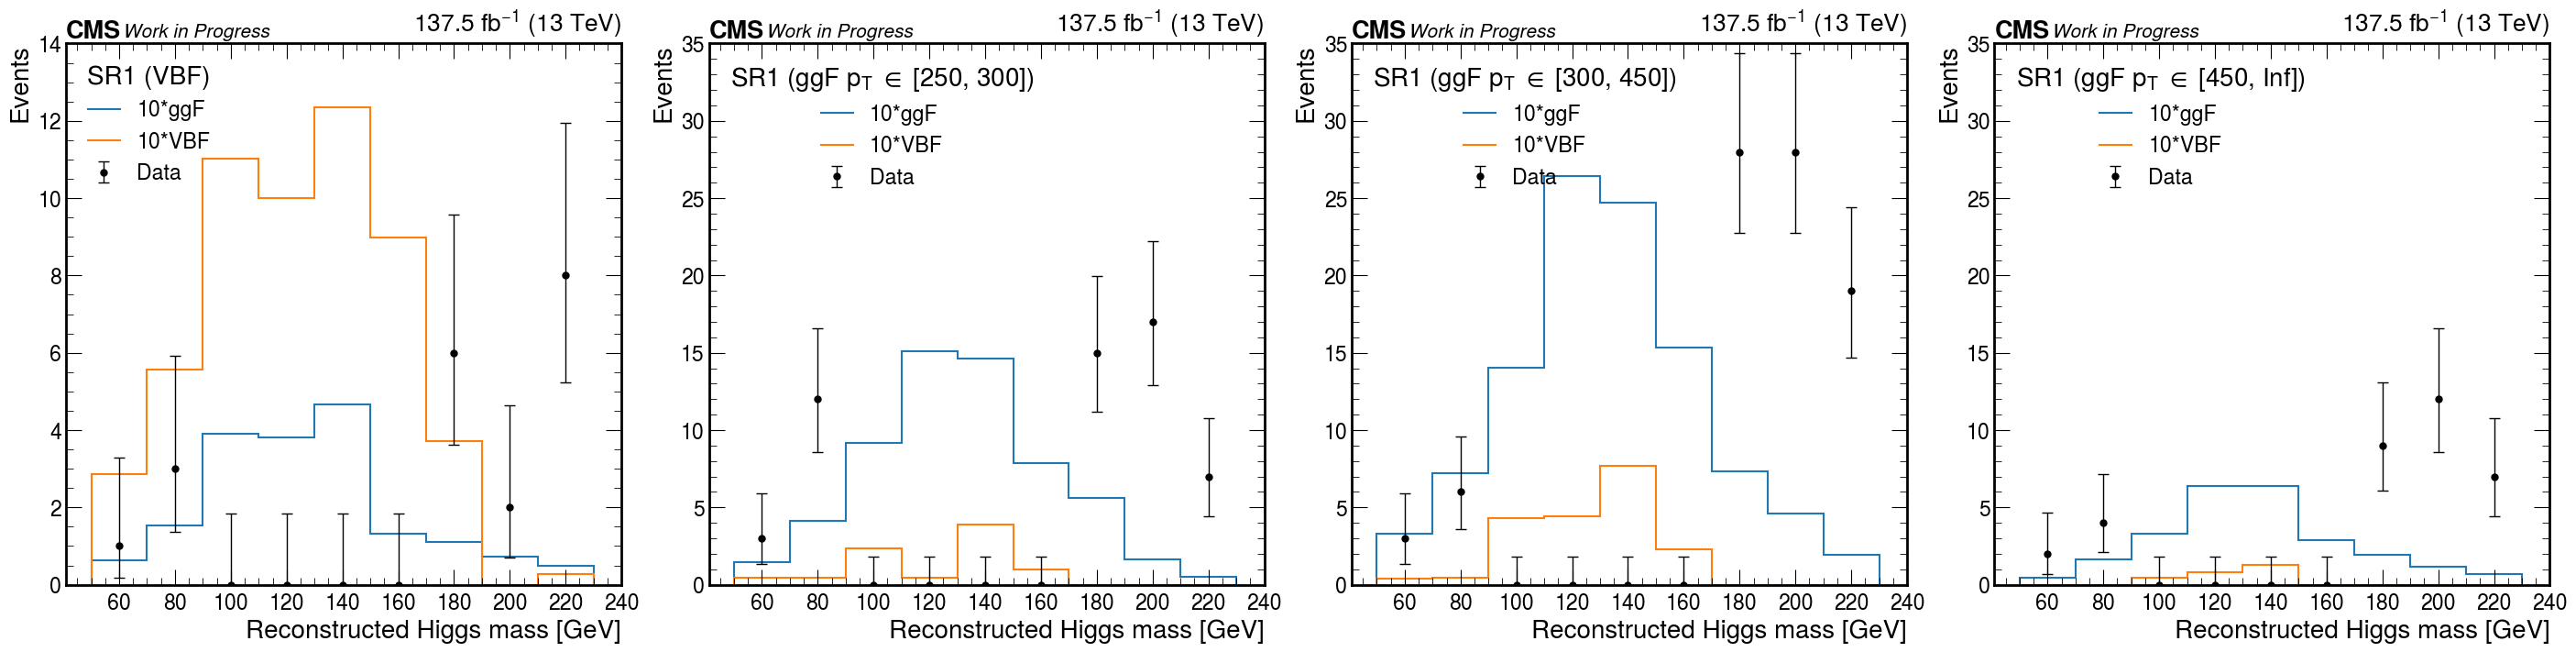

In [31]:
fig, axs = plt.subplots(1, 4, figsize=(28,7), constrained_layout=True)

for region in regions_sel:
    for i, category in enumerate(categories_sel[region]):
        if region=="SR2":
            i=3
        for sample in samples:


            if sample == "Data":
                if blind:
                    hists = blindBins(hists, (blind_region[0],blind_region[1]), blind_samples=["Data"])

                hep.histplot(
                    hists[{"samples": sample, "regions": region, "categories": category}],
                    ax=axs[i],
                    label=sample,
                    histtype="errorbar",
                    color="k",
                    capsize=4,   
                    flow="none"                    
                    
                )   

            else:
                if mult[region]==1:
                    lab = sample            
                else:
                    lab = f"{mult[region]}*{sample}"

                hep.histplot(
                    hists[{"samples": sample, "regions": region, "categories": category}],
                    ax=axs[i],
                    histtype="step",
                    label=lab,
                    flow="none"
                )    
#         if i==3:
#             axs[i].legend(title=f"{region}", loc="upper left")
#         else:
#             axs[i].legend(title=f"{region} ({category})", loc="upper left")

        axs[i].legend(title=f"{region} ({category})", loc="upper left")                

            
        if i==0:
            axs[i].set_ylim(0,14)
        if i==1:
            axs[i].set_ylim(0,35)
        if i==2:
            axs[i].set_ylim(0,35)            
        if i==3:
            axs[i].set_ylim(0,35)
            
            
        axs[i].set_ylabel(f"Events")
        axs[i].set_xlabel(f"Reconstructed Higgs mass [GeV]")
        axs[i].set_ylim(0)    
        hep.cms.lumitext("%.1f " % lum + r"fb$^{-1}$ (13 TeV)", ax=axs[i], fontsize=20)
        hep.cms.text("Work in Progress", ax=axs[i], fontsize=15)
        
        axs[i].set_xticks(np.array(list(range(50, 240, 20))) + 10)
    plt.savefig(f"/Users/fmokhtar/Desktop/AN/ww2.pdf")

# QCD

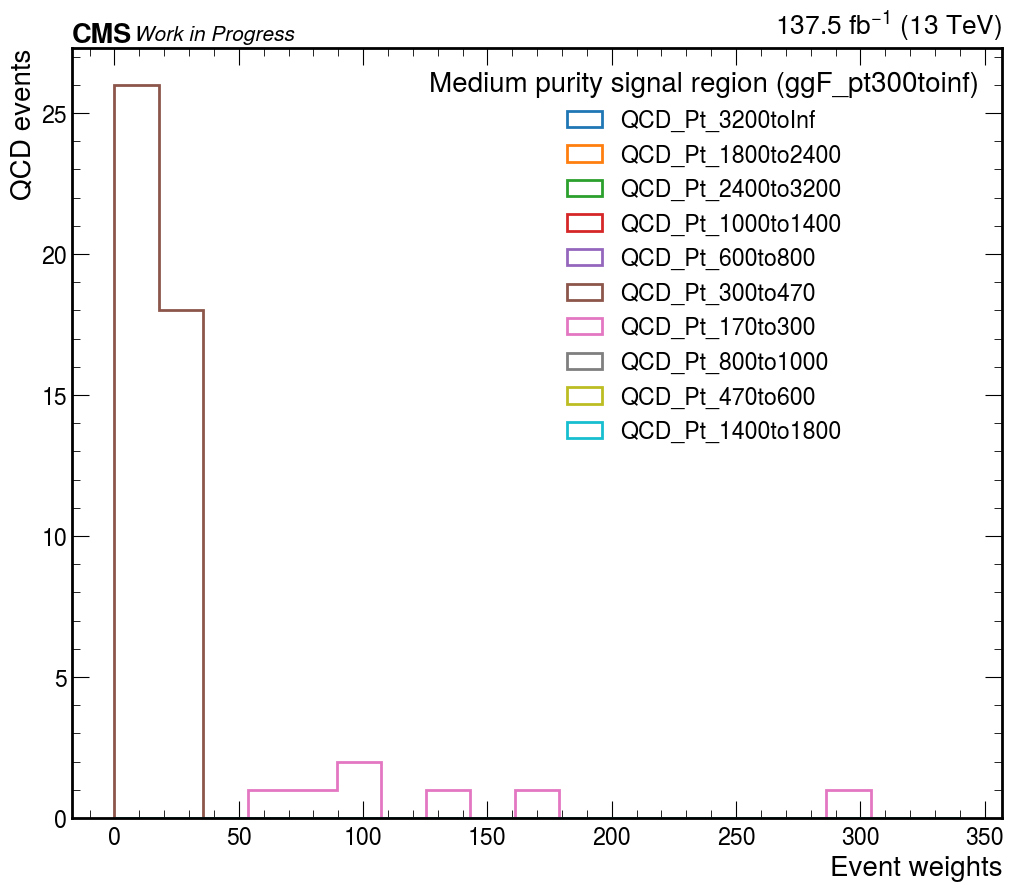

In [573]:
################### option 1
plt.rcParams.update({"font.size": 20})
nice_ch = {
    "ele": "Electron",
    "mu": "Muon",
}

# tagger = "fj_ParT_score"
tagger = "fj_ParT_score_finetuned"

region_sel = {
#     "High purity signal region": f"({tagger}>0.97)",
    "Medium purity signal region": f"({tagger}<0.97) & ({tagger}>0.85)",    
#     "Low purity signal region": f"({tagger}<0.85) & ({tagger}>0.20)",   
    
#     "WJets control region": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0)",
#     "Top control region": f"({tagger}<0.30) & (n_bjets_T>0)",  
#     "QCD control region": f"({tagger}<0.20) & (n_bjets_T==0)",  
}
categories_sel = {
#     "VBF_pt200toinf": "( (mjj>1000) & (deta>3.5) )",
#     "ggF_pt200to300": "( (mjj<1000) & (deta<3.5) & (fj_pt<300) )",
    "ggF_pt300toinf": "( (mjj<1000) & (deta<3.5) & (fj_pt>300) )",
    
}
blind = True
blind_region = (80, 160)
mult = 10

years = ["2018", "2017", "2016APV", "2016"]
sample="QCD"

fig, ax = plt.subplots(figsize=(12,10))    

ws = {}

for sample in events_dict2["signal_region"]["2017"][ch]:
    ws[sample] = []
    for year in years:
        for ch in ["ele", "mu"]:
            try:
                df = events_dict2["signal_region"][year][ch][sample]
            except:
                continue

            for region, sel in region_sel.items():
                df = df.query(sel)

            for category, category_sel in categories_sel.items():
                df = df.query(category_sel)

            w = df[f"event_weight"]
            ws[sample] += w.tolist() 
    
    ws[sample] = np.array(ws[sample])
    ws[sample] = ws[sample][ws[sample]>10]

    bins = 20
    ax.hist(
        ws[sample],
        bins=np.linspace(0,340,bins), 
        histtype="step", 
        linewidth=2, 
        label=sample
    )
#     break

lum = 0
for year in years:
    lum += luminosity[ch][year] / 1000.0

ax.legend(title=f"{region} ({category})", loc="upper right")

ax.set_ylabel(f"QCD events")
ax.set_xlabel(f"Event weights")  
ax.set_ylim(0)

hep.cms.lumitext("%.1f " % lum + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku2/WWW_QCD_weights_medium_{category}.pdf")        

In [740]:
def plot_ratio(h, years, region1 = "Medium_signal_region", region2 = "QCD_region", sample="QCD", category="VBF", tag=""):
    
    fig, (ax, rax) = plt.subplots(
        nrows=2,
        ncols=1,
        figsize=(10, 10),
        gridspec_kw={"height_ratios": (4, 2), "hspace": 0.07},
        sharex=True,
    )

    hep.histplot(
        h[{"region": region1, "categories": category}],
        ax=ax,
#         histtype="step",
        histtype="errorbar",        
        label=region1,
        density=True
    )
    hep.histplot(
        h[{"region": region2, "categories": category}],
        ax=ax,
        histtype="step",
        label=region2,
        density=True    
    )

    from hist.intervals import ratio_uncertainty

    data_val = h[{"region": region1, "categories": category}].values()
    tot_val = h[{"region": region2, "categories": category}].values()
    yerr = ratio_uncertainty(data_val, tot_val, "poisson")
    

    data_val /= data_val.sum()
    tot_val /= tot_val.sum()


    hep.histplot(
        data_val / tot_val,
        h[{"region": region1, "categories": category}].axes.edges[0],
        yerr=yerr,
        ax=rax,
        histtype="step",
        color="k",
#         capsize=4,
    )
    ax.set_xlabel("")
    rax.set_xlabel(f"{h.axes[-1].label}")  # assumes the variable to be plotted is at the last axis

    rax.set_ylabel("Ratio", fontsize=20, loc="center")

    
#     rax.set_ylim(0, 0.004)
#     rax.set_yticks([0, 0.4, 1, 1.4])
    
    rax.axhline(1, ls="--", color="k")    
#     rax.set_ylim(0, 2.5)
#     rax.set_yticks([0, 0.4, 1, 1.4])

    ax.legend(title=category)
    
    lum_ = 0
    for year in years:
        lum = 0
        for ch in ["ele", "mu"]:
            with open("../fileset/luminosity.json") as f:
                lum += json.load(f)[ch][year] / 1000.0

        lum_ += lum / len(channels)

    hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)

    hep.cms.text("Work in Progress", ax=ax, fontsize=15)
    
    
    ax.set_ylabel(f"Normalized {sample} events")
    
    if tag:
        plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku3/ratio_{sample}_{tag}.pdf")        
    else:
        plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku3/ratio_{sample}.pdf")   

In [741]:
tagger = "fj_ParT_score_finetuned"
presel = {
    "High purity signal region": f"({tagger}>0.97)",
    "Medium purity signal region": f"({tagger}<0.97) & ({tagger}>0.85)",
    "Low purity signal region": f"({tagger}<0.85) & ({tagger}>0.20)",
    "0.85>Tagger>0.20": f"({tagger}<0.85) & ({tagger}>0.20)",

#     "WJets control region": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0)",   
    
#     "Top control region": f"({tagger}<0.20) & (n_bjets_T>0)",  
    "QCD control region": f"({tagger}<0.20) & (n_bjets_T==0)",  

}

categories_sel = {
    "VBF_pt200toinf": "( (mjj>1000) & (deta>3.5) )",
    "ggF_pt200to300": "( (mjj<1000) & (deta<3.5) & (fj_pt<300) )",
    "ggF_pt300toinf": "( (mjj<1000) & (deta<3.5) & (fj_pt>300) )",
    
}
            
channels = ["ele", "mu"]
years = ["2018", "2017", "2016", "2016APV"]

sample = "QCD"

# fill histograms
hists = {}
for var in vars_to_plot:
            
    if var == "rec_higgs_m":
        hists[var] = hist2.Hist(
            hist2.axis.StrCategory([], name="region", growth=True),
            hist2.axis.StrCategory([], name="categories", growth=True),            
            hist2.axis.Variable(
                list(range(50, 240, 20)), name="mass_observable", label=r"Higgs reconstructed mass [GeV]", overflow=True
            )
        )
    else:
        hists[var] = hist2.Hist(
            hist2.axis.StrCategory([], name="region", growth=True),
            utils.axis_dict[var],
        )
        
    for year in years:
        for ch in channels:
                
            for region, region_sel in presel.items():
                for category, category_sel in categories_sel.items():
                
                    if "QCD control region" in region:
                        df = events_dict["qcd_region"][year][ch][sample]
                    else:
                        df = events_dict["signal_region"][year][ch][sample]

                    if "High" in region:
                        if sample == "QCD":
                            df = df[df["event_weight"]<140]
                    elif "Medium" in region:
                        if sample == "QCD":
                            df = df[df["event_weight"]<200]

                    df = df.query(region_sel)
                    df = df.query(category_sel)

                    hists[var].fill(
                        region=region,
                        categories=category,
                        mass_observable=df[var],
                        weight=df["event_weight"],
                    )     

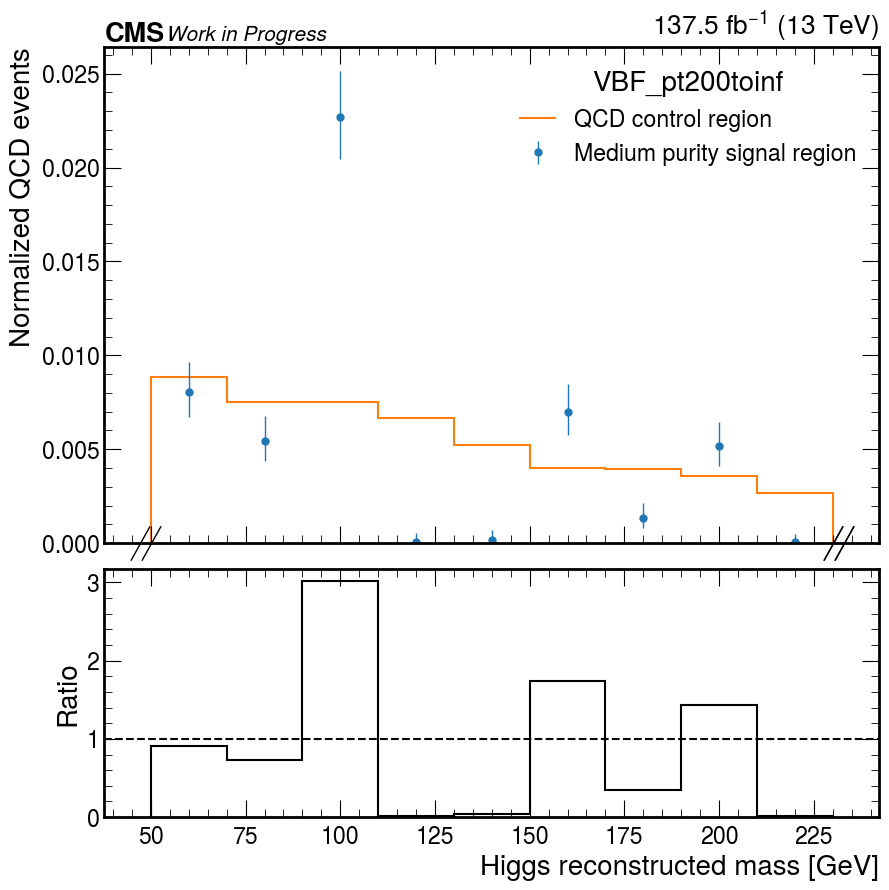

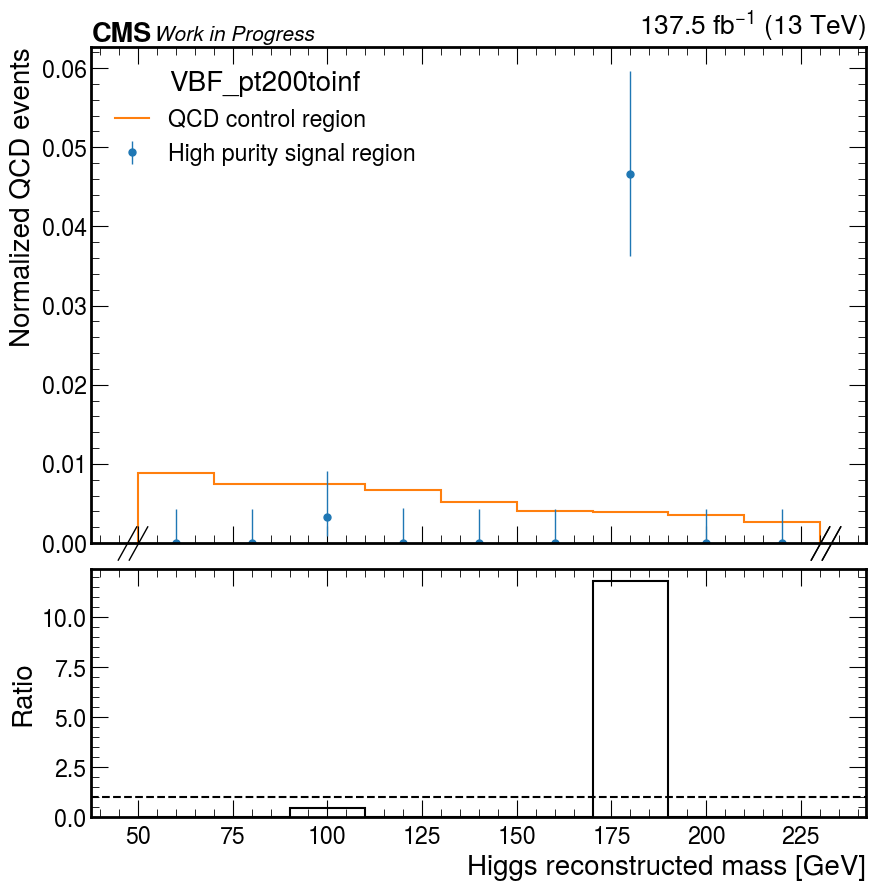

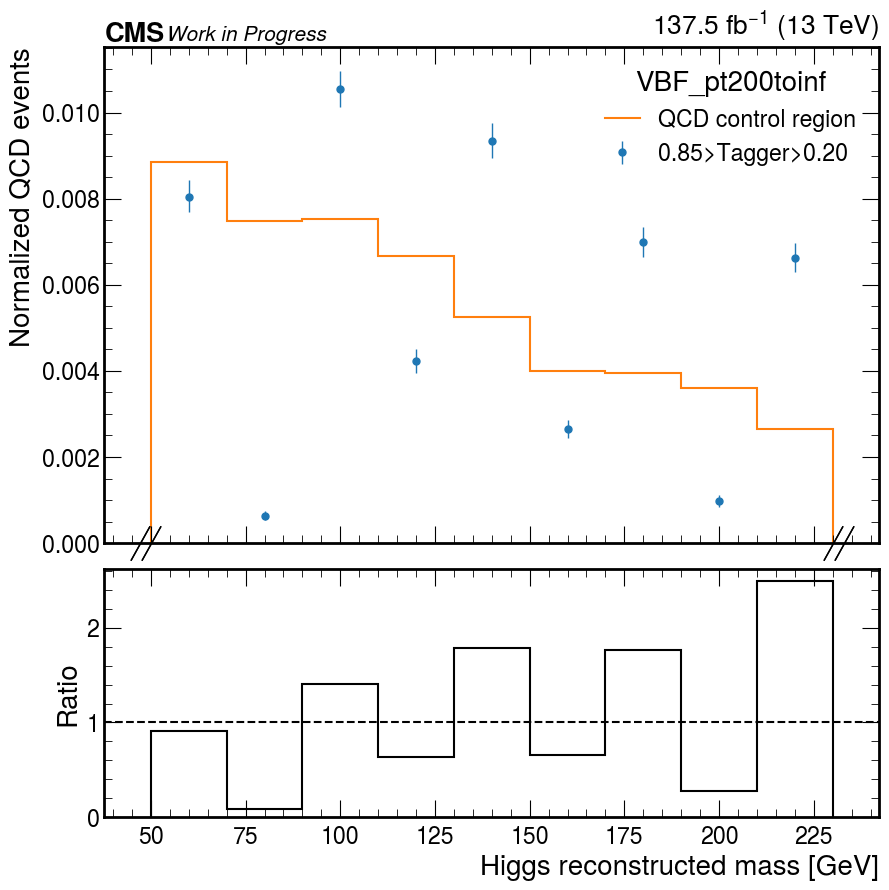

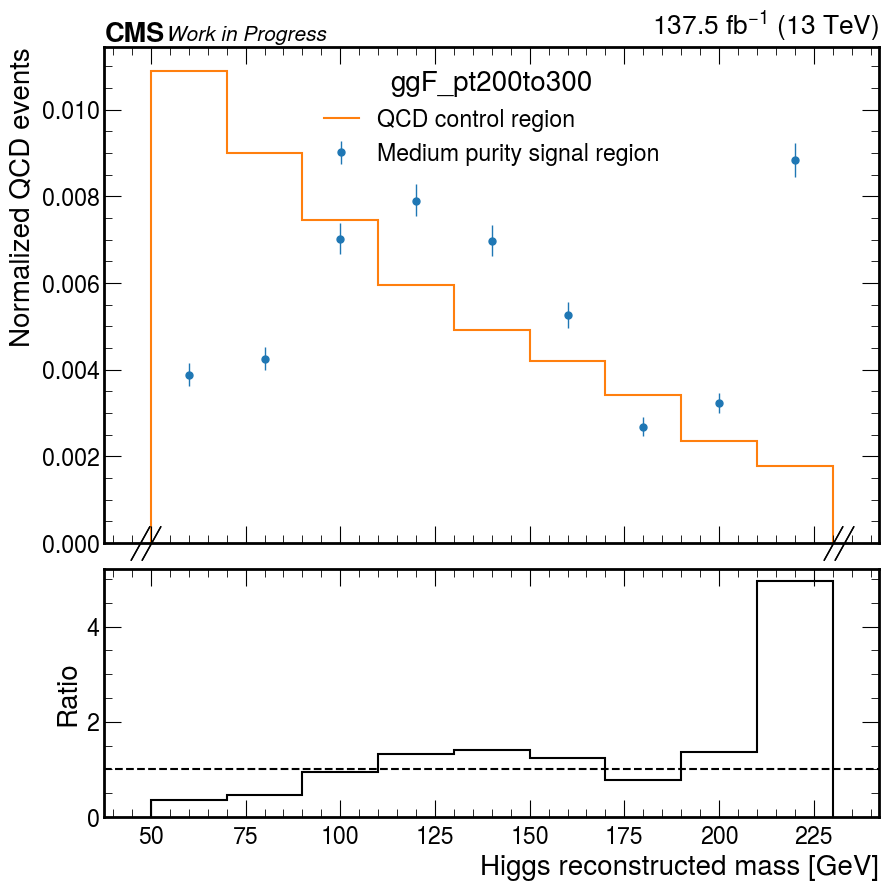

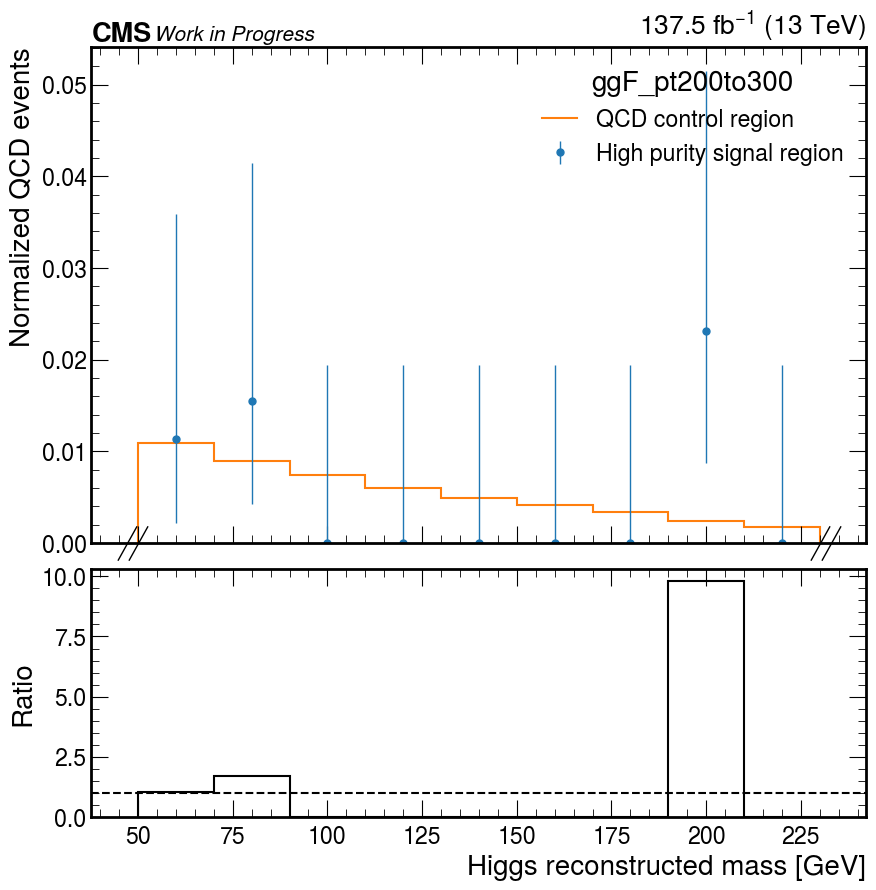

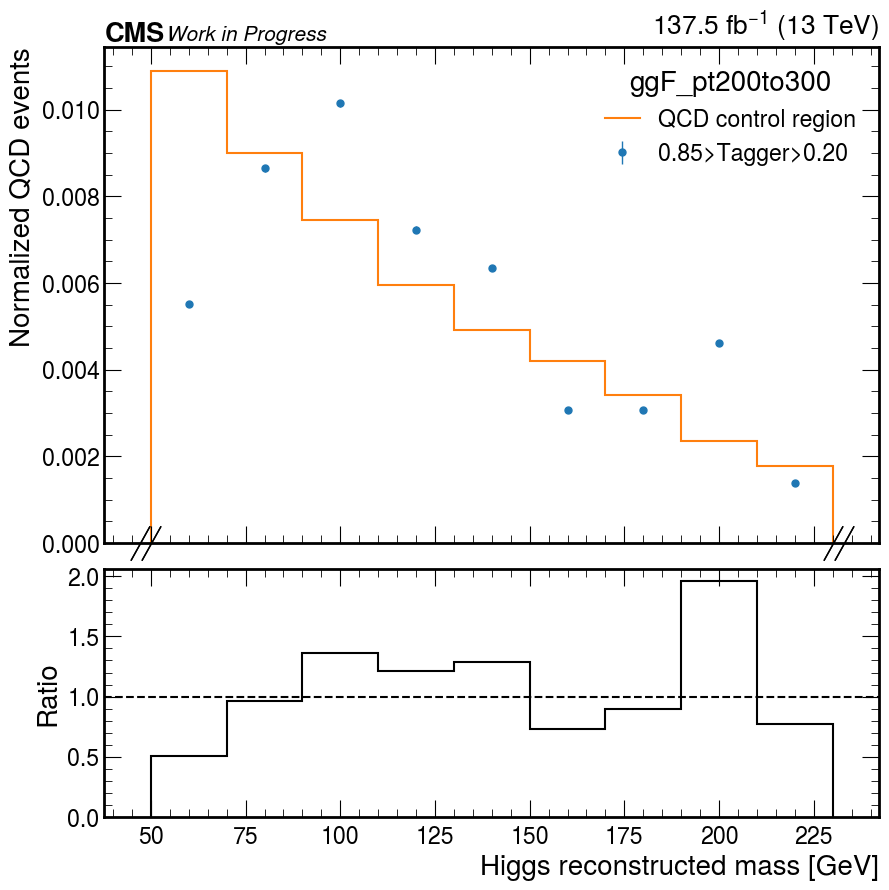

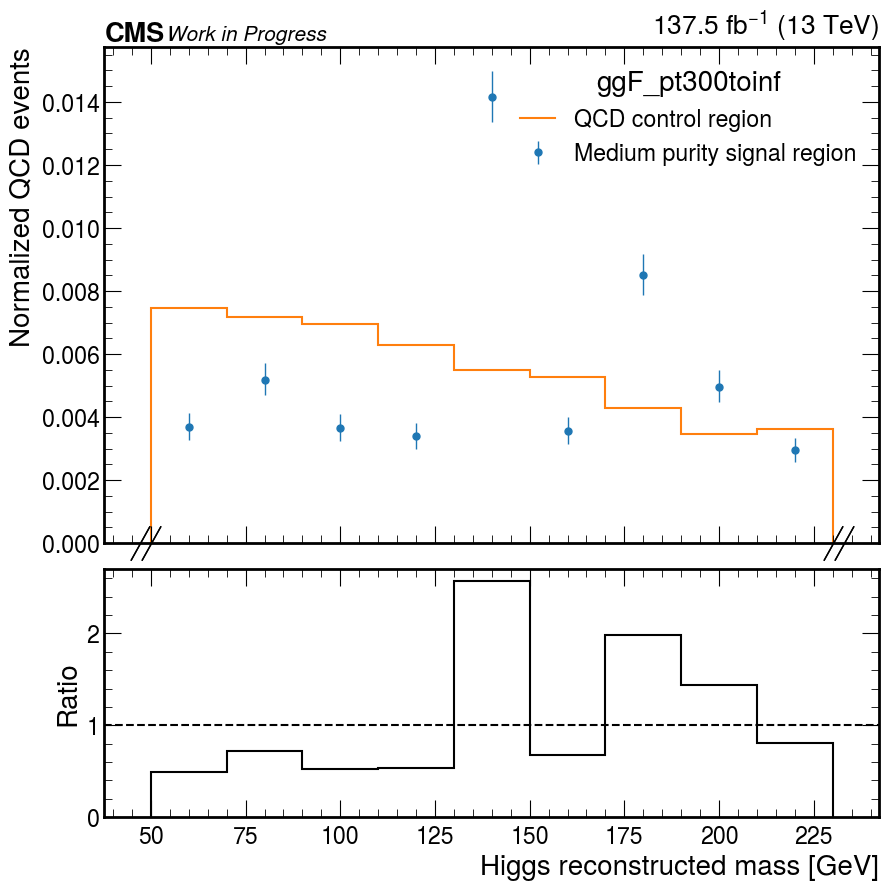

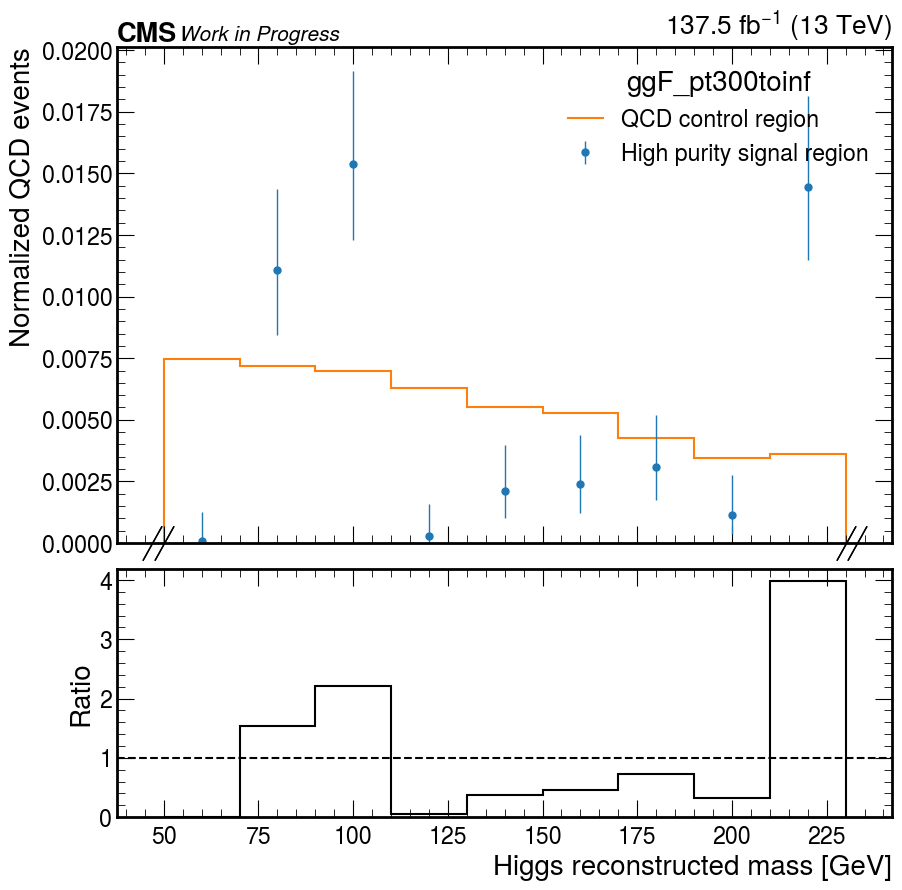

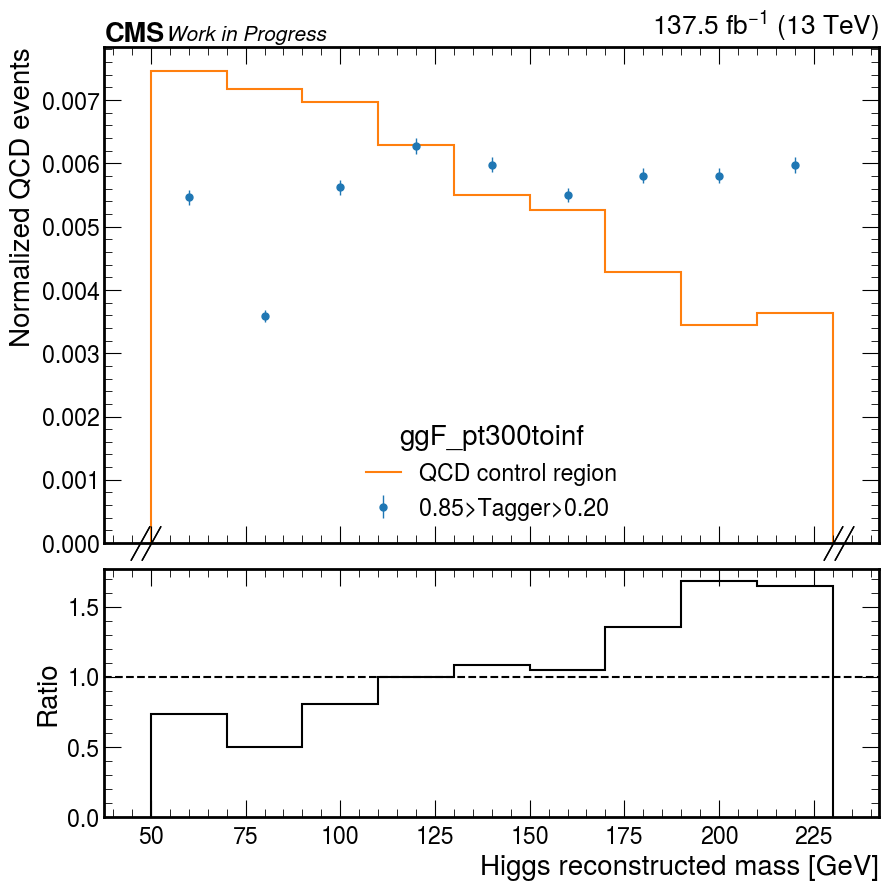

In [754]:
region_dic = {
    "Medium purity signal region": "medium",
    "High purity signal region": "high",
    "0.85>Tagger>0.20": "low",    
}

for category in ["VBF_pt200toinf", "ggF_pt200to300", "ggF_pt300toinf"]:
    
    for region in region_dic:
        plot_ratio(hists["rec_higgs_m"], 
                   years, 
                   region1 = region,
                   region2 = "QCD control region",
                   sample=sample,
                   category=category,
                   tag=f"{category}_{region_dic[region]}"
                  )

In [ ]:
fig, ax = plt.subplots(figsize=(14, 11))
ax.hist(
    x, 
    bins=np.linspace(50,300,bins), 
    weights=w,
    density=True, 
    histtype="step", 
    linewidth=2, 
    label=rf"{k} ($\mu$={np.mean(x):.1f}, $\sigma$={np.std(x):.1f})"
)

ax.axvline(125, color="grey", linestyle="--", label=rf"125 GeV")

if len(channels) > 1:
    ax.legend(title=f"{sample}")    
else:
    ax.legend(title=f"{nice_ch[ch]} channel - {sample}")


ax.set_ylabel("Events")
ax.set_xlabel(f"Reconstructed Higgs mass [GeV]")
ax.set_ylim(0)

lum_=0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku/mass_sculpting_{sample}.pdf")        

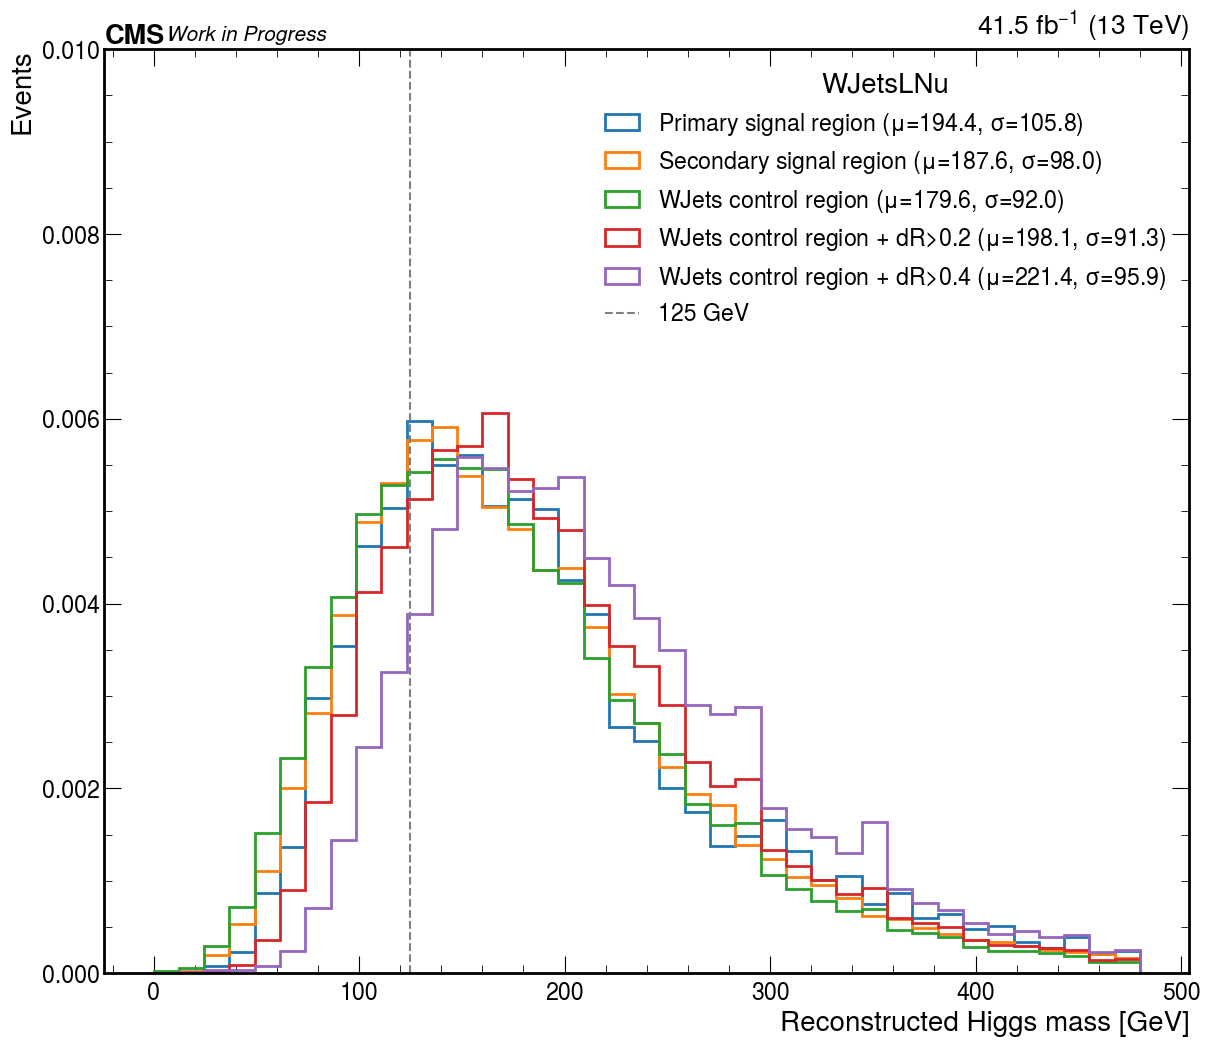

In [140]:
fig, ax = plt.subplots(figsize=(14, 12))
for region, sel in presel.items():

    df1 = df.copy().query(sel)

    x = df1["rec_higgs_m"]
    ax.hist(
        x, 
        bins=np.linspace(0,480,bins), 
        weights=df1["weight"],
        density=True, 
        histtype="step", 
        linewidth=2, 
        label=rf"{region} ($\mu$={np.mean(x):.1f}, $\sigma$={np.std(x):.1f})"
    )

ax.axvline(125, color="grey", linestyle="--", label=rf"125 GeV")

if len(channels) > 1:
    ax.legend(title=f"{sample}")    
else:
    ax.legend(title=f"{nice_ch[ch]} channel - {sample}")


ax.set_ylabel("Events")
ax.set_xlabel(f"Reconstructed Higgs mass [GeV]")
ax.set_ylim(0, 0.01)

luminosity = 0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    luminosity += lum / len(channels)    
        
hep.cms.lumitext("%.1f " % luminosity + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakiko/{sample}.pdf")  